In [1]:
#ライブラリのインポート
import glob
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import df_pre as df_pre
import optuna

#lgb用
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import KFold
import optuna.integration.lightgbm as o_lgb

#警告を非表示
import warnings
warnings.simplefilter('ignore')

In [2]:
#ファイルの読み込み
files = glob.glob("../../data/train/*.csv")
data_list = []
for file in files:
    data_list.append(pd.read_csv(file, index_col=0))
data_list
df = pd.concat(data_list)

In [3]:
#変換処理の適用
df = df_pre.data_pre(df)
df

test


,市区町村コード,都道府県名_num,地区名,最寄駅：名称,最寄駅：距離（分）_min,間取り,面積（㎡）_num,建築年_year,建物の構造_num,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点_num,改装,取引の事情等,取引価格（総額）_log
ID,,,,,,,,,,,,,,,,,,
1088170,1204,1,７条通,旭川,16.0,２ＤＫ,45,33.0,5.0,住宅,NaN,近隣商業地域,80.0,300.0,2011.99,未改装,NaN,6.740363
1048405,1106,1,真駒内柏丘,真駒内,25.0,３ＬＤＫ,70,30.0,5.0,住宅,住宅,第１種住居地域,60.0,200.0,2017.50,改装済,NaN,6.875061
1030233,1104,1,菊水１条,菊水,6.0,４ＬＤＫ,105,14.0,5.0,NaN,住宅,第１種住居地域,60.0,200.0,2020.50,未改装,NaN,7.518514
1000080,1101,1,大通西,西１１丁目,4.0,３ＬＤＫ,100,17.0,5.0,住宅,住宅,商業地域,80.0,600.0,2019.99,未改装,NaN,7.792392
1065071,1108,1,大谷地東,ひばりが丘(北海道),9.0,３ＬＤＫ,75,15.0,5.0,住宅,NaN,近隣商業地域,80.0,300.0,2009.50,未改装,NaN,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47014161,47208,47,勢理客,NaN,NaN,３ＬＤＫ,70,20.0,5.0,住宅,NaN,第１種住居地域,60.0,200.0,2010.50,未改装,NaN,7.255273
47027826,47208,47,牧港,NaN,NaN,３ＬＤＫ,65,24.0,5.0,住宅,NaN,準工業地域,60.0,200.0,2013.99,改装済,NaN,7.278754
47003754,47208,47,港川,NaN,NaN,３ＬＤＫ,65,17.0,5.0,NaN,その他,商業地域,80.0,400.0,2018.50,改装済,NaN,7.397940


In [4]:
#テストデータの用意
df_train, df_val =train_test_split(df, test_size=0.2)
col = "取引価格（総額）_log"
train_y = df_train[col]
train_x = df_train.drop(col, axis=1)

val_y = df_val[col]
val_x = df_val.drop(col, axis=1)


In [6]:
"""Optuna実施時の条件１
#Optunaの実装（テスト）
def objective(trial):
    params = {
        "objective":"regression_l2",    #MAEを指標とした回帰を指定
        "random_seed":1234,             #乱数シードを固定
        "learning_rate":0.05,           #どれだけ1回の学習を次の学習に反映させるか
        "n_estimators":1000,              #学習回数（1round）
        "verbosity":-1,                 #学習過程の非表示/各回最終の学習結果は表示される

        "num_leaves":trial.suggest_int("num_leaves", 4, 64),                             #先端の葉の最大数
        "max_bin":trial.suggest_int("max_bin", 50, 200),                                 #1特徴量の分割条件を増やす
        "max_depth":trial.suggest_int("max_depth", 3, 10),                               #決定木の深さを指定
        "bagging_fraction":trial.suggest_uniform("bagging_fraction", 0.4, 0.9),          #何％の訓練データをランダムに利用するか
        "bagging_freq":trial.suggest_int("bagging_freq", 1, 10),                         #何回ごとにランダムサンプリングをするかを制御
        "feature_fraction":trial.suggest_uniform("feature_fraction", 0.4, 0.9),          #各木を作成するときに何パーセントの特徴量をランダムで利用するか
        "min_data_in_leaf":trial.suggest_int("min_data_in_leaf", 2, 16),                 #各葉に所属する最小データ数
        "min_sum_hessian_in_leaf":trial.suggest_int("min_sum_hessian_in_leaf", 1, 10),   #葉を分割するのに必要なhessianの合計値？？->値が小さいと葉を分割し、オーバーフィッティングへ。デフォルト値が0.001で設定おかしい？
    }
    categorical_features = ["地区名", "最寄駅：名称", "間取り", "用途", "今後の利用目的", "都市計画", "改装", "取引の事情等"]
    lgb_train = lgb.Dataset(train_x, train_y)
    lgb_eval = lgb.Dataset(val_x, val_y, reference=lgb_train)

    model_lgb = lgb.train(params, lgb_train,
                         valid_sets=lgb_eval,
                         num_boost_round=1000,        #学習回数(1round)->n_estimatorsと被る？？
                         early_stopping_rounds=50,    #何回連続でscoreが改善されなかった場合に打ち切るかの指定
                         verbose_eval=500)            #何回の学習毎に結果を表示させるか
    y_pred = model_lgb.predict(val_x, num_iteration=model_lgb.best_iteration)
    score=mae(val_y, y_pred)
    return score

"""


In [7]:
"""Optuna実施時の条件2
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, timeout=21600)#n_trials=50がdefault、timeout=60と設定すると60秒間試行する
study.best_params #学習結果の表示
"""

[I 2022-01-13 21:55:15,020] A new study created in memory with name: no-name-b79ca420-1a4a-4f91-a483-83fcddace582


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178438
[1000]	valid_0's l2: 0.0173165
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0173165


[I 2022-01-13 21:55:53,193] Trial 0 finished with value: 0.08005334550539164 and parameters: {'num_leaves': 37, 'max_bin': 157, 'max_depth': 7, 'bagging_fraction': 0.6724415914984485, 'bagging_freq': 5, 'feature_fraction': 0.722947056533328, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 9}. Best is trial 0 with value: 0.08005334550539164.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0173967
[1000]	valid_0's l2: 0.0171621
Did not meet early stopping. Best iteration is:
[990]	valid_0's l2: 0.0171602


[I 2022-01-13 21:56:40,199] Trial 1 finished with value: 0.07930858264554472 and parameters: {'num_leaves': 62, 'max_bin': 107, 'max_depth': 9, 'bagging_fraction': 0.6644474598764523, 'bagging_freq': 6, 'feature_fraction': 0.8627983191463305, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 1}. Best is trial 1 with value: 0.07930858264554472.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0217461
[1000]	valid_0's l2: 0.0195481
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195481


[I 2022-01-13 21:57:02,801] Trial 2 finished with value: 0.08823138035338716 and parameters: {'num_leaves': 5, 'max_bin': 175, 'max_depth': 9, 'bagging_fraction': 0.8350060741234095, 'bagging_freq': 10, 'feature_fraction': 0.7995792821083618, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 8}. Best is trial 1 with value: 0.07930858264554472.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0199566
[1000]	valid_0's l2: 0.0184068
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0184068


[I 2022-01-13 21:57:26,564] Trial 3 finished with value: 0.08423186317417238 and parameters: {'num_leaves': 11, 'max_bin': 146, 'max_depth': 4, 'bagging_fraction': 0.872334458524792, 'bagging_freq': 6, 'feature_fraction': 0.6073309699952618, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 8}. Best is trial 1 with value: 0.07930858264554472.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214065
[1000]	valid_0's l2: 0.0193774
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193774


[I 2022-01-13 21:57:45,681] Trial 4 finished with value: 0.08798173633108954 and parameters: {'num_leaves': 31, 'max_bin': 135, 'max_depth': 3, 'bagging_fraction': 0.7088177485379386, 'bagging_freq': 7, 'feature_fraction': 0.7084669984373785, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 7}. Best is trial 1 with value: 0.07930858264554472.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018315
[1000]	valid_0's l2: 0.0178885
Did not meet early stopping. Best iteration is:
[982]	valid_0's l2: 0.0178824


[I 2022-01-13 21:58:17,790] Trial 5 finished with value: 0.08214449973308391 and parameters: {'num_leaves': 25, 'max_bin': 115, 'max_depth': 8, 'bagging_fraction': 0.43011273581463494, 'bagging_freq': 7, 'feature_fraction': 0.7353189348090797, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 1 with value: 0.07930858264554472.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018209
[1000]	valid_0's l2: 0.0174518
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174518


[I 2022-01-13 21:58:45,961] Trial 6 finished with value: 0.08075617126671467 and parameters: {'num_leaves': 23, 'max_bin': 104, 'max_depth': 7, 'bagging_fraction': 0.6193007567311601, 'bagging_freq': 10, 'feature_fraction': 0.45102240537401406, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 1 with value: 0.07930858264554472.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180695
[1000]	valid_0's l2: 0.017302
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017302


[I 2022-01-13 21:59:14,333] Trial 7 finished with value: 0.08016680280195765 and parameters: {'num_leaves': 43, 'max_bin': 88, 'max_depth': 6, 'bagging_fraction': 0.5222127960008014, 'bagging_freq': 2, 'feature_fraction': 0.4551875705821526, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 2}. Best is trial 1 with value: 0.07930858264554472.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186711
[1000]	valid_0's l2: 0.0179229
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0179229


[I 2022-01-13 21:59:42,265] Trial 8 finished with value: 0.08233285977257163 and parameters: {'num_leaves': 15, 'max_bin': 105, 'max_depth': 9, 'bagging_fraction': 0.44855063789653066, 'bagging_freq': 9, 'feature_fraction': 0.44804920394698156, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 5}. Best is trial 1 with value: 0.07930858264554472.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175022
[1000]	valid_0's l2: 0.0170382
Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 0.0170374


[I 2022-01-13 22:00:16,321] Trial 9 finished with value: 0.07908854636191699 and parameters: {'num_leaves': 63, 'max_bin': 141, 'max_depth': 8, 'bagging_fraction': 0.41959389612716036, 'bagging_freq': 3, 'feature_fraction': 0.4600982806065845, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 9 with value: 0.07908854636191699.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215417
[1000]	valid_0's l2: 0.0194137
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194137


[I 2022-01-13 22:00:37,847] Trial 10 finished with value: 0.08811902179115362 and parameters: {'num_leaves': 23, 'max_bin': 112, 'max_depth': 3, 'bagging_fraction': 0.74623605968501, 'bagging_freq': 6, 'feature_fraction': 0.5326947454697227, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 1}. Best is trial 9 with value: 0.07908854636191699.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018664
[1000]	valid_0's l2: 0.0177939
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177939


[I 2022-01-13 22:01:10,613] Trial 11 finished with value: 0.08197359709803825 and parameters: {'num_leaves': 39, 'max_bin': 190, 'max_depth': 5, 'bagging_fraction': 0.7337051899818409, 'bagging_freq': 2, 'feature_fraction': 0.7581636020592828, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 9 with value: 0.07908854636191699.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178538
[1000]	valid_0's l2: 0.0173666
Did not meet early stopping. Best iteration is:
[984]	valid_0's l2: 0.0173588


[I 2022-01-13 22:01:46,363] Trial 12 finished with value: 0.0802176629101891 and parameters: {'num_leaves': 39, 'max_bin': 53, 'max_depth': 9, 'bagging_fraction': 0.40234773809627356, 'bagging_freq': 7, 'feature_fraction': 0.5350039865960825, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 10}. Best is trial 9 with value: 0.07908854636191699.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0183308
[1000]	valid_0's l2: 0.0178044
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178044


[I 2022-01-13 22:02:24,069] Trial 13 finished with value: 0.08192029437396901 and parameters: {'num_leaves': 19, 'max_bin': 136, 'max_depth': 7, 'bagging_fraction': 0.6861259528954367, 'bagging_freq': 3, 'feature_fraction': 0.8763745057584925, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 9}. Best is trial 9 with value: 0.07908854636191699.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175352
[1000]	valid_0's l2: 0.0171549
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171549


[I 2022-01-13 22:03:06,826] Trial 14 finished with value: 0.0792977707658907 and parameters: {'num_leaves': 46, 'max_bin': 94, 'max_depth': 9, 'bagging_fraction': 0.5982528704234924, 'bagging_freq': 9, 'feature_fraction': 0.6906364363179294, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 7}. Best is trial 9 with value: 0.07908854636191699.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.017242
[1000]	valid_0's l2: 0.0169244
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0169244


[I 2022-01-13 22:03:55,546] Trial 15 finished with value: 0.07853283619149962 and parameters: {'num_leaves': 48, 'max_bin': 125, 'max_depth': 10, 'bagging_fraction': 0.7219950996148188, 'bagging_freq': 5, 'feature_fraction': 0.7031966070639621, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177627
[1000]	valid_0's l2: 0.0171461
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171461


[I 2022-01-13 22:04:29,673] Trial 16 finished with value: 0.07951558325010796 and parameters: {'num_leaves': 44, 'max_bin': 93, 'max_depth': 7, 'bagging_fraction': 0.6143843504728831, 'bagging_freq': 2, 'feature_fraction': 0.5491411629780154, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 6}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176746
[1000]	valid_0's l2: 0.0171553
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171553


[I 2022-01-13 22:05:03,770] Trial 17 finished with value: 0.07943467606320948 and parameters: {'num_leaves': 39, 'max_bin': 148, 'max_depth': 8, 'bagging_fraction': 0.615709217716987, 'bagging_freq': 9, 'feature_fraction': 0.5837809350239482, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 9}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0212167
[1000]	valid_0's l2: 0.0191731
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0191731


[I 2022-01-13 22:05:24,534] Trial 18 finished with value: 0.08715142833774331 and parameters: {'num_leaves': 53, 'max_bin': 156, 'max_depth': 3, 'bagging_fraction': 0.8597413068723367, 'bagging_freq': 8, 'feature_fraction': 0.8994235032839333, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 9}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0213707
[1000]	valid_0's l2: 0.0192348
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0192348


[I 2022-01-13 22:05:44,740] Trial 19 finished with value: 0.08749509093591422 and parameters: {'num_leaves': 13, 'max_bin': 142, 'max_depth': 3, 'bagging_fraction': 0.8240041146611172, 'bagging_freq': 9, 'feature_fraction': 0.6845503693072967, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0173435
[1000]	valid_0's l2: 0.0169839
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0169834


[I 2022-01-13 22:06:32,560] Trial 20 finished with value: 0.07868955349338441 and parameters: {'num_leaves': 46, 'max_bin': 118, 'max_depth': 8, 'bagging_fraction': 0.8331911629643146, 'bagging_freq': 10, 'feature_fraction': 0.8279016711963055, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178656
[1000]	valid_0's l2: 0.0171974
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171974


[I 2022-01-13 22:07:02,081] Trial 21 finished with value: 0.07971478014703258 and parameters: {'num_leaves': 48, 'max_bin': 75, 'max_depth': 7, 'bagging_fraction': 0.42716899416962684, 'bagging_freq': 2, 'feature_fraction': 0.409260897230307, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 3}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0183611
[1000]	valid_0's l2: 0.0178417
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0178412


[I 2022-01-13 22:07:35,186] Trial 22 finished with value: 0.08199536981236578 and parameters: {'num_leaves': 25, 'max_bin': 190, 'max_depth': 8, 'bagging_fraction': 0.41591946476565395, 'bagging_freq': 2, 'feature_fraction': 0.7107392007498818, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175007
[1000]	valid_0's l2: 0.0169234
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169234


[I 2022-01-13 22:08:11,081] Trial 23 finished with value: 0.07859817642544777 and parameters: {'num_leaves': 60, 'max_bin': 142, 'max_depth': 7, 'bagging_fraction': 0.6949549881772855, 'bagging_freq': 8, 'feature_fraction': 0.555972497739801, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 3}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185239
[1000]	valid_0's l2: 0.017746
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017746


[I 2022-01-13 22:08:44,232] Trial 24 finished with value: 0.08171104016673217 and parameters: {'num_leaves': 15, 'max_bin': 192, 'max_depth': 8, 'bagging_fraction': 0.6452294043087836, 'bagging_freq': 3, 'feature_fraction': 0.5271782408851965, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 5}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018497
[1000]	valid_0's l2: 0.0176096
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176096


[I 2022-01-13 22:09:11,651] Trial 25 finished with value: 0.08127144944797599 and parameters: {'num_leaves': 23, 'max_bin': 155, 'max_depth': 6, 'bagging_fraction': 0.4898018387798174, 'bagging_freq': 1, 'feature_fraction': 0.4336248157316243, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 5}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.017657
[1000]	valid_0's l2: 0.0171855
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0171854


[I 2022-01-13 22:09:47,746] Trial 26 finished with value: 0.07958436388602248 and parameters: {'num_leaves': 36, 'max_bin': 185, 'max_depth': 10, 'bagging_fraction': 0.5084484921992369, 'bagging_freq': 7, 'feature_fraction': 0.5316611883685753, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179212
[1000]	valid_0's l2: 0.0173661
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173661


[I 2022-01-13 22:10:24,644] Trial 27 finished with value: 0.08023038230256899 and parameters: {'num_leaves': 23, 'max_bin': 107, 'max_depth': 7, 'bagging_fraction': 0.8155242276180952, 'bagging_freq': 7, 'feature_fraction': 0.8363253277236977, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 8}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018588
[1000]	valid_0's l2: 0.0180488
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0180483


[I 2022-01-13 22:10:56,206] Trial 28 finished with value: 0.08277850804680911 and parameters: {'num_leaves': 15, 'max_bin': 193, 'max_depth': 8, 'bagging_fraction': 0.5077538385567792, 'bagging_freq': 10, 'feature_fraction': 0.7654279033850789, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 3}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.019832
[1000]	valid_0's l2: 0.0185189
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0185189


[I 2022-01-13 22:11:16,871] Trial 29 finished with value: 0.08479703048176293 and parameters: {'num_leaves': 35, 'max_bin': 53, 'max_depth': 4, 'bagging_fraction': 0.6123427343757532, 'bagging_freq': 4, 'feature_fraction': 0.6317877121824054, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 6}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178527
[1000]	valid_0's l2: 0.0172923
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0172922


[I 2022-01-13 22:11:46,207] Trial 30 finished with value: 0.07988602028278614 and parameters: {'num_leaves': 56, 'max_bin': 67, 'max_depth': 7, 'bagging_fraction': 0.4660340531725767, 'bagging_freq': 8, 'feature_fraction': 0.5980298514036468, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0191276
[1000]	valid_0's l2: 0.017951
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017951


[I 2022-01-13 22:12:15,629] Trial 31 finished with value: 0.08240054638031045 and parameters: {'num_leaves': 12, 'max_bin': 123, 'max_depth': 5, 'bagging_fraction': 0.8702159726264065, 'bagging_freq': 8, 'feature_fraction': 0.7743318099252736, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 1}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175401
[1000]	valid_0's l2: 0.0170456
Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 0.0170455


[I 2022-01-13 22:12:53,283] Trial 32 finished with value: 0.07908664613582293 and parameters: {'num_leaves': 37, 'max_bin': 138, 'max_depth': 10, 'bagging_fraction': 0.5460737633962744, 'bagging_freq': 3, 'feature_fraction': 0.45014697113274893, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 10}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187721
[1000]	valid_0's l2: 0.0178088
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178088


[I 2022-01-13 22:13:21,913] Trial 33 finished with value: 0.08192318616525576 and parameters: {'num_leaves': 44, 'max_bin': 168, 'max_depth': 5, 'bagging_fraction': 0.6932050830931633, 'bagging_freq': 1, 'feature_fraction': 0.6428137979673114, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 9}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0195201
[1000]	valid_0's l2: 0.0181464
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0181464


[I 2022-01-13 22:13:59,076] Trial 34 finished with value: 0.08335326680612881 and parameters: {'num_leaves': 24, 'max_bin': 195, 'max_depth': 4, 'bagging_fraction': 0.8746594112078407, 'bagging_freq': 10, 'feature_fraction': 0.7996012936761958, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018466
[1000]	valid_0's l2: 0.0177291
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177291


[I 2022-01-13 22:14:30,976] Trial 35 finished with value: 0.08168305874068615 and parameters: {'num_leaves': 21, 'max_bin': 178, 'max_depth': 7, 'bagging_fraction': 0.40661842887944977, 'bagging_freq': 4, 'feature_fraction': 0.47407043047408254, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 5}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187728
[1000]	valid_0's l2: 0.0177757
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177757


[I 2022-01-13 22:14:53,652] Trial 36 finished with value: 0.08194281254317343 and parameters: {'num_leaves': 34, 'max_bin': 146, 'max_depth': 5, 'bagging_fraction': 0.4684501358427995, 'bagging_freq': 9, 'feature_fraction': 0.494923955951379, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 3}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0192676
[1000]	valid_0's l2: 0.0179925
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0179925


[I 2022-01-13 22:15:25,574] Trial 37 finished with value: 0.08255267889023434 and parameters: {'num_leaves': 9, 'max_bin': 180, 'max_depth': 10, 'bagging_fraction': 0.8804173290315, 'bagging_freq': 10, 'feature_fraction': 0.7870236663493194, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 1}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0199133
[1000]	valid_0's l2: 0.018461
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.018461


[I 2022-01-13 22:15:43,245] Trial 38 finished with value: 0.08459033463327399 and parameters: {'num_leaves': 28, 'max_bin': 85, 'max_depth': 4, 'bagging_fraction': 0.42671359089341265, 'bagging_freq': 8, 'feature_fraction': 0.40571372931251554, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 2}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198566
[1000]	valid_0's l2: 0.018857
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.018857


[I 2022-01-13 22:16:10,188] Trial 39 finished with value: 0.08558173277509709 and parameters: {'num_leaves': 8, 'max_bin': 63, 'max_depth': 8, 'bagging_fraction': 0.5226836049264224, 'bagging_freq': 5, 'feature_fraction': 0.6786843956619585, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 8}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0216198
[1000]	valid_0's l2: 0.0196249
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0196249


[I 2022-01-13 22:16:27,205] Trial 40 finished with value: 0.0888177405356482 and parameters: {'num_leaves': 20, 'max_bin': 69, 'max_depth': 3, 'bagging_fraction': 0.5507993172404713, 'bagging_freq': 3, 'feature_fraction': 0.6280702834002398, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 7}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0196824
[1000]	valid_0's l2: 0.0183419
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183419


[I 2022-01-13 22:16:49,328] Trial 41 finished with value: 0.08404120445461473 and parameters: {'num_leaves': 21, 'max_bin': 107, 'max_depth': 4, 'bagging_fraction': 0.7942727561532594, 'bagging_freq': 1, 'feature_fraction': 0.7484986208624937, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 8}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018503
[1000]	valid_0's l2: 0.0177054
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177054


[I 2022-01-13 22:17:17,362] Trial 42 finished with value: 0.08156018669388064 and parameters: {'num_leaves': 19, 'max_bin': 106, 'max_depth': 7, 'bagging_fraction': 0.5364109512122335, 'bagging_freq': 4, 'feature_fraction': 0.49852714009281984, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179828
[1000]	valid_0's l2: 0.0176225
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176225


[I 2022-01-13 22:17:51,741] Trial 43 finished with value: 0.08115830393721139 and parameters: {'num_leaves': 52, 'max_bin': 61, 'max_depth': 7, 'bagging_fraction': 0.5534050497725981, 'bagging_freq': 6, 'feature_fraction': 0.8797166704167125, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 1}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178948
[1000]	valid_0's l2: 0.0171796
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171796


[I 2022-01-13 22:18:25,846] Trial 44 finished with value: 0.07955069563078238 and parameters: {'num_leaves': 30, 'max_bin': 127, 'max_depth': 7, 'bagging_fraction': 0.740696255301919, 'bagging_freq': 3, 'feature_fraction': 0.4644302827331601, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 10}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186016
[1000]	valid_0's l2: 0.0178696
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178696


[I 2022-01-13 22:18:56,610] Trial 45 finished with value: 0.082086940698042 and parameters: {'num_leaves': 15, 'max_bin': 186, 'max_depth': 7, 'bagging_fraction': 0.628455710822883, 'bagging_freq': 9, 'feature_fraction': 0.629301980884293, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 4}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.01759
[1000]	valid_0's l2: 0.0171921
Did not meet early stopping. Best iteration is:
[985]	valid_0's l2: 0.0171912


[I 2022-01-13 22:19:33,512] Trial 46 finished with value: 0.07953525681962592 and parameters: {'num_leaves': 59, 'max_bin': 154, 'max_depth': 8, 'bagging_fraction': 0.5638602007785595, 'bagging_freq': 8, 'feature_fraction': 0.7180305277235707, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179563
[1000]	valid_0's l2: 0.0172935
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172935


[I 2022-01-13 22:20:04,641] Trial 47 finished with value: 0.07987374174689583 and parameters: {'num_leaves': 52, 'max_bin': 194, 'max_depth': 6, 'bagging_fraction': 0.6954920826618425, 'bagging_freq': 9, 'feature_fraction': 0.6286117266769286, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 6}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175456
[1000]	valid_0's l2: 0.0171303
Did not meet early stopping. Best iteration is:
[986]	valid_0's l2: 0.0171253


[I 2022-01-13 22:20:40,265] Trial 48 finished with value: 0.07926926516522742 and parameters: {'num_leaves': 54, 'max_bin': 187, 'max_depth': 9, 'bagging_fraction': 0.479707231724478, 'bagging_freq': 7, 'feature_fraction': 0.5992171293098385, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 5}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214503
[1000]	valid_0's l2: 0.0193523
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193523


[I 2022-01-13 22:20:59,765] Trial 49 finished with value: 0.08791485660122397 and parameters: {'num_leaves': 19, 'max_bin': 178, 'max_depth': 3, 'bagging_fraction': 0.8794913609317367, 'bagging_freq': 4, 'feature_fraction': 0.5783534452012715, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.021349
[1000]	valid_0's l2: 0.0192493
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0192493


[I 2022-01-13 22:21:19,554] Trial 50 finished with value: 0.08755038156579831 and parameters: {'num_leaves': 28, 'max_bin': 190, 'max_depth': 3, 'bagging_fraction': 0.8726507667395398, 'bagging_freq': 9, 'feature_fraction': 0.6270811984537759, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 3}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.021547
[1000]	valid_0's l2: 0.0195101
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195101


[I 2022-01-13 22:21:37,144] Trial 51 finished with value: 0.08852986714685125 and parameters: {'num_leaves': 41, 'max_bin': 54, 'max_depth': 3, 'bagging_fraction': 0.614397861249119, 'bagging_freq': 1, 'feature_fraction': 0.5259704941230465, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 3}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0212918
[1000]	valid_0's l2: 0.0193221
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193221


[I 2022-01-13 22:21:56,582] Trial 52 finished with value: 0.08788178144341384 and parameters: {'num_leaves': 11, 'max_bin': 51, 'max_depth': 3, 'bagging_fraction': 0.709240129756374, 'bagging_freq': 10, 'feature_fraction': 0.895172500780447, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 2}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176489
[1000]	valid_0's l2: 0.017227
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.0172265


[I 2022-01-13 22:22:33,493] Trial 53 finished with value: 0.07966505110360114 and parameters: {'num_leaves': 42, 'max_bin': 124, 'max_depth': 10, 'bagging_fraction': 0.4326521035758901, 'bagging_freq': 8, 'feature_fraction': 0.544199248665747, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 7}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0184489
[1000]	valid_0's l2: 0.0176869
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176869


[I 2022-01-13 22:23:02,543] Trial 54 finished with value: 0.08147528962845907 and parameters: {'num_leaves': 19, 'max_bin': 150, 'max_depth': 7, 'bagging_fraction': 0.6120444942179246, 'bagging_freq': 6, 'feature_fraction': 0.5435257599598149, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 5}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181121
[1000]	valid_0's l2: 0.0175998
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 0.0175981


[I 2022-01-13 22:23:38,079] Trial 55 finished with value: 0.08103979752456454 and parameters: {'num_leaves': 25, 'max_bin': 175, 'max_depth': 10, 'bagging_fraction': 0.4230036554436485, 'bagging_freq': 3, 'feature_fraction': 0.5742596847462816, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 10}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185803
[1000]	valid_0's l2: 0.0174902
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174902


[I 2022-01-13 22:24:09,189] Trial 56 finished with value: 0.08069265361058195 and parameters: {'num_leaves': 63, 'max_bin': 186, 'max_depth': 5, 'bagging_fraction': 0.8960056217072371, 'bagging_freq': 3, 'feature_fraction': 0.4529530774411161, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 3}. Best is trial 15 with value: 0.07853283619149962.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174057
[1000]	valid_0's l2: 0.0169007
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169007


[I 2022-01-13 22:24:49,192] Trial 57 finished with value: 0.07837243536864454 and parameters: {'num_leaves': 46, 'max_bin': 58, 'max_depth': 8, 'bagging_fraction': 0.8408601061669199, 'bagging_freq': 3, 'feature_fraction': 0.5895284480387143, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 57 with value: 0.07837243536864454.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187471
[1000]	valid_0's l2: 0.0178546
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178546


[I 2022-01-13 22:25:15,541] Trial 58 finished with value: 0.0821842070700713 and parameters: {'num_leaves': 18, 'max_bin': 75, 'max_depth': 6, 'bagging_fraction': 0.5522342036886598, 'bagging_freq': 9, 'feature_fraction': 0.5188709130078194, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 10}. Best is trial 57 with value: 0.07837243536864454.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0173291
[1000]	valid_0's l2: 0.0170648
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170648


[I 2022-01-13 22:26:12,007] Trial 59 finished with value: 0.0789079633889006 and parameters: {'num_leaves': 42, 'max_bin': 180, 'max_depth': 10, 'bagging_fraction': 0.775382430943176, 'bagging_freq': 7, 'feature_fraction': 0.8839827833021136, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 5}. Best is trial 57 with value: 0.07837243536864454.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0204836
[1000]	valid_0's l2: 0.0190385
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0190385


[I 2022-01-13 22:26:37,055] Trial 60 finished with value: 0.08655769437968255 and parameters: {'num_leaves': 8, 'max_bin': 94, 'max_depth': 4, 'bagging_fraction': 0.6087431873980059, 'bagging_freq': 2, 'feature_fraction': 0.7020589020104411, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 9}. Best is trial 57 with value: 0.07837243536864454.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187184
[1000]	valid_0's l2: 0.0177336
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177336


[I 2022-01-13 22:27:08,332] Trial 61 finished with value: 0.08178550480495349 and parameters: {'num_leaves': 63, 'max_bin': 132, 'max_depth': 5, 'bagging_fraction': 0.6961152093809184, 'bagging_freq': 9, 'feature_fraction': 0.6033666729178742, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3}. Best is trial 57 with value: 0.07837243536864454.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198612
[1000]	valid_0's l2: 0.018509
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.018509


[I 2022-01-13 22:27:34,778] Trial 62 finished with value: 0.08466305128906323 and parameters: {'num_leaves': 31, 'max_bin': 110, 'max_depth': 4, 'bagging_fraction': 0.6529331919126542, 'bagging_freq': 4, 'feature_fraction': 0.5865174319403738, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 8}. Best is trial 57 with value: 0.07837243536864454.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182379
[1000]	valid_0's l2: 0.0177309
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 0.0177277


[I 2022-01-13 22:28:16,669] Trial 63 finished with value: 0.08158539681118654 and parameters: {'num_leaves': 24, 'max_bin': 189, 'max_depth': 9, 'bagging_fraction': 0.4243451479877643, 'bagging_freq': 3, 'feature_fraction': 0.623067756329601, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 4}. Best is trial 57 with value: 0.07837243536864454.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176232
[1000]	valid_0's l2: 0.0170321
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170321


[I 2022-01-13 22:28:52,343] Trial 64 finished with value: 0.07887165149160716 and parameters: {'num_leaves': 49, 'max_bin': 152, 'max_depth': 7, 'bagging_fraction': 0.7552642013611728, 'bagging_freq': 3, 'feature_fraction': 0.5708490574323661, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 9}. Best is trial 57 with value: 0.07837243536864454.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214945
[1000]	valid_0's l2: 0.0194199
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194199


[I 2022-01-13 22:29:10,298] Trial 65 finished with value: 0.08818743728716436 and parameters: {'num_leaves': 37, 'max_bin': 92, 'max_depth': 3, 'bagging_fraction': 0.7551684144871067, 'bagging_freq': 1, 'feature_fraction': 0.5863395349104978, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 10}. Best is trial 57 with value: 0.07837243536864454.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215323
[1000]	valid_0's l2: 0.0194789
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194789


[I 2022-01-13 22:29:28,701] Trial 66 finished with value: 0.08838304309507965 and parameters: {'num_leaves': 9, 'max_bin': 111, 'max_depth': 3, 'bagging_fraction': 0.5713054921707952, 'bagging_freq': 7, 'feature_fraction': 0.5395339741142993, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 57 with value: 0.07837243536864454.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174392
[1000]	valid_0's l2: 0.0169591
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0169591


[I 2022-01-13 22:30:09,022] Trial 67 finished with value: 0.0785567683509143 and parameters: {'num_leaves': 39, 'max_bin': 154, 'max_depth': 8, 'bagging_fraction': 0.8744305103602537, 'bagging_freq': 1, 'feature_fraction': 0.7235983269470181, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 6}. Best is trial 57 with value: 0.07837243536864454.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0173332
[1000]	valid_0's l2: 0.0168564
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0168563


[I 2022-01-13 22:30:52,325] Trial 68 finished with value: 0.07817019796399696 and parameters: {'num_leaves': 62, 'max_bin': 52, 'max_depth': 8, 'bagging_fraction': 0.8068393248509318, 'bagging_freq': 6, 'feature_fraction': 0.5669824347984046, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 1}. Best is trial 68 with value: 0.07817019796399696.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180821
[1000]	valid_0's l2: 0.0175402
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 0.0175393


[I 2022-01-13 22:31:27,481] Trial 69 finished with value: 0.08087637906734095 and parameters: {'num_leaves': 30, 'max_bin': 128, 'max_depth': 8, 'bagging_fraction': 0.44544286601620475, 'bagging_freq': 3, 'feature_fraction': 0.6051507813450628, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 68 with value: 0.07817019796399696.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172407
[1000]	valid_0's l2: 0.01697
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.01697


[I 2022-01-13 22:32:23,241] Trial 70 finished with value: 0.07854179200128082 and parameters: {'num_leaves': 41, 'max_bin': 70, 'max_depth': 10, 'bagging_fraction': 0.8358928673777465, 'bagging_freq': 6, 'feature_fraction': 0.8611739908983165, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 68 with value: 0.07817019796399696.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175805
[1000]	valid_0's l2: 0.0171718
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0171709


[I 2022-01-13 22:33:04,327] Trial 71 finished with value: 0.07937468860779621 and parameters: {'num_leaves': 54, 'max_bin': 196, 'max_depth': 10, 'bagging_fraction': 0.41801690871428476, 'bagging_freq': 2, 'feature_fraction': 0.594567338550593, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 4}. Best is trial 68 with value: 0.07817019796399696.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187664
[1000]	valid_0's l2: 0.0178
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178


[I 2022-01-13 22:33:38,979] Trial 72 finished with value: 0.08178092938430656 and parameters: {'num_leaves': 13, 'max_bin': 183, 'max_depth': 6, 'bagging_fraction': 0.8539377971771631, 'bagging_freq': 2, 'feature_fraction': 0.7305587557540498, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 68 with value: 0.07817019796399696.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0216761
[1000]	valid_0's l2: 0.019959
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.019959


[I 2022-01-13 22:34:00,491] Trial 73 finished with value: 0.08998042468216924 and parameters: {'num_leaves': 46, 'max_bin': 87, 'max_depth': 3, 'bagging_fraction': 0.42997214912478665, 'bagging_freq': 1, 'feature_fraction': 0.8538664787425198, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 9}. Best is trial 68 with value: 0.07817019796399696.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185708
[1000]	valid_0's l2: 0.0175845
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175845


[I 2022-01-13 22:34:31,913] Trial 74 finished with value: 0.08105606148301699 and parameters: {'num_leaves': 45, 'max_bin': 129, 'max_depth': 5, 'bagging_fraction': 0.8989811256643367, 'bagging_freq': 4, 'feature_fraction': 0.6353244746069548, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 10}. Best is trial 68 with value: 0.07817019796399696.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0188005
[1000]	valid_0's l2: 0.0181762
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0181718


[I 2022-01-13 22:35:03,430] Trial 75 finished with value: 0.083210199225071 and parameters: {'num_leaves': 14, 'max_bin': 99, 'max_depth': 8, 'bagging_fraction': 0.43160380916931534, 'bagging_freq': 7, 'feature_fraction': 0.6388232514382081, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 3}. Best is trial 68 with value: 0.07817019796399696.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181109
[1000]	valid_0's l2: 0.0173441
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0173439


[I 2022-01-13 22:35:32,106] Trial 76 finished with value: 0.08034917849084877 and parameters: {'num_leaves': 35, 'max_bin': 105, 'max_depth': 6, 'bagging_fraction': 0.5687386908821199, 'bagging_freq': 10, 'feature_fraction': 0.46671971587280203, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 4}. Best is trial 68 with value: 0.07817019796399696.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178717
[1000]	valid_0's l2: 0.0171926
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171926


[I 2022-01-13 22:36:10,007] Trial 77 finished with value: 0.07946599244765395 and parameters: {'num_leaves': 40, 'max_bin': 149, 'max_depth': 6, 'bagging_fraction': 0.8996389969610856, 'bagging_freq': 4, 'feature_fraction': 0.7607033339799762, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 68 with value: 0.07817019796399696.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0170882
[1000]	valid_0's l2: 0.0166377
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0166377


[I 2022-01-13 22:36:54,860] Trial 78 finished with value: 0.07758959562554563 and parameters: {'num_leaves': 63, 'max_bin': 184, 'max_depth': 9, 'bagging_fraction': 0.7491242389091453, 'bagging_freq': 4, 'feature_fraction': 0.4738427891033537, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175403
[1000]	valid_0's l2: 0.0169283
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169283


[I 2022-01-13 22:37:38,372] Trial 79 finished with value: 0.0785587128097987 and parameters: {'num_leaves': 30, 'max_bin': 128, 'max_depth': 9, 'bagging_fraction': 0.8793704615282965, 'bagging_freq': 2, 'feature_fraction': 0.4535020700968958, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172334
[1000]	valid_0's l2: 0.0167965
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.016796


[I 2022-01-13 22:38:20,727] Trial 80 finished with value: 0.07812123968432914 and parameters: {'num_leaves': 55, 'max_bin': 191, 'max_depth': 10, 'bagging_fraction': 0.599900846112263, 'bagging_freq': 4, 'feature_fraction': 0.4739043383486362, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179321
[1000]	valid_0's l2: 0.0171627
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171627


[I 2022-01-13 22:38:53,509] Trial 81 finished with value: 0.07954431093587044 and parameters: {'num_leaves': 56, 'max_bin': 64, 'max_depth': 6, 'bagging_fraction': 0.6905409648360316, 'bagging_freq': 3, 'feature_fraction': 0.48451270306458066, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179326
[1000]	valid_0's l2: 0.0173007
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173007


[I 2022-01-13 22:39:31,364] Trial 82 finished with value: 0.07998853755694893 and parameters: {'num_leaves': 32, 'max_bin': 67, 'max_depth': 6, 'bagging_fraction': 0.8899811631711547, 'bagging_freq': 5, 'feature_fraction': 0.8285624587522837, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179988
[1000]	valid_0's l2: 0.0175158
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175158


[I 2022-01-13 22:40:09,960] Trial 83 finished with value: 0.08080800579507592 and parameters: {'num_leaves': 28, 'max_bin': 110, 'max_depth': 8, 'bagging_fraction': 0.5723590636877538, 'bagging_freq': 8, 'feature_fraction': 0.7195934496126963, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.017421
[1000]	valid_0's l2: 0.0169896
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169896


[I 2022-01-13 22:40:56,027] Trial 84 finished with value: 0.07886010021401893 and parameters: {'num_leaves': 41, 'max_bin': 60, 'max_depth': 9, 'bagging_fraction': 0.7267105805568185, 'bagging_freq': 8, 'feature_fraction': 0.6684615005411952, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0213895
[1000]	valid_0's l2: 0.0193965
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193965


[I 2022-01-13 22:41:17,105] Trial 85 finished with value: 0.0880322645012523 and parameters: {'num_leaves': 28, 'max_bin': 98, 'max_depth': 3, 'bagging_fraction': 0.7686271212982387, 'bagging_freq': 2, 'feature_fraction': 0.7031540665225426, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175776
[1000]	valid_0's l2: 0.0171546
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171546


[I 2022-01-13 22:41:56,448] Trial 86 finished with value: 0.07945079654883133 and parameters: {'num_leaves': 62, 'max_bin': 65, 'max_depth': 9, 'bagging_fraction': 0.41459511742445665, 'bagging_freq': 6, 'feature_fraction': 0.6021218089696294, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 4}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186085
[1000]	valid_0's l2: 0.0177095
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177095


[I 2022-01-13 22:42:36,030] Trial 87 finished with value: 0.08160444481698456 and parameters: {'num_leaves': 15, 'max_bin': 52, 'max_depth': 7, 'bagging_fraction': 0.8213884313424211, 'bagging_freq': 4, 'feature_fraction': 0.5114319090074901, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0193543
[1000]	valid_0's l2: 0.0185793
Did not meet early stopping. Best iteration is:
[984]	valid_0's l2: 0.0185793


[I 2022-01-13 22:43:06,215] Trial 88 finished with value: 0.0850116728384648 and parameters: {'num_leaves': 17, 'max_bin': 65, 'max_depth': 5, 'bagging_fraction': 0.4330747310584774, 'bagging_freq': 1, 'feature_fraction': 0.828138089811391, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.019936
[1000]	valid_0's l2: 0.0187045
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0187045


[I 2022-01-13 22:43:29,077] Trial 89 finished with value: 0.08539544155226464 and parameters: {'num_leaves': 51, 'max_bin': 118, 'max_depth': 4, 'bagging_fraction': 0.4997980710600572, 'bagging_freq': 5, 'feature_fraction': 0.6641170445892679, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0212452
[1000]	valid_0's l2: 0.0192472
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0192472


[I 2022-01-13 22:43:53,222] Trial 90 finished with value: 0.08739643026107398 and parameters: {'num_leaves': 49, 'max_bin': 190, 'max_depth': 3, 'bagging_fraction': 0.8478456456051018, 'bagging_freq': 4, 'feature_fraction': 0.8391862476899971, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 10}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177069
[1000]	valid_0's l2: 0.0171152
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171152


[I 2022-01-13 22:44:27,706] Trial 91 finished with value: 0.07938914877273713 and parameters: {'num_leaves': 50, 'max_bin': 105, 'max_depth': 7, 'bagging_fraction': 0.5881945775971756, 'bagging_freq': 4, 'feature_fraction': 0.53045224969053, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0216804
[1000]	valid_0's l2: 0.0198986
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0198986


[I 2022-01-13 22:44:48,423] Trial 92 finished with value: 0.08979951043798247 and parameters: {'num_leaves': 20, 'max_bin': 129, 'max_depth': 3, 'bagging_fraction': 0.4799226434270957, 'bagging_freq': 1, 'feature_fraction': 0.8853657213853164, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172995
[1000]	valid_0's l2: 0.0169199
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0169195


[I 2022-01-13 22:45:36,805] Trial 93 finished with value: 0.07843630957289875 and parameters: {'num_leaves': 41, 'max_bin': 62, 'max_depth': 10, 'bagging_fraction': 0.7598100789211442, 'bagging_freq': 10, 'feature_fraction': 0.6538177736203825, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186212
[1000]	valid_0's l2: 0.017463
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017463


[I 2022-01-13 22:46:06,596] Trial 94 finished with value: 0.08074985273619989 and parameters: {'num_leaves': 60, 'max_bin': 128, 'max_depth': 5, 'bagging_fraction': 0.8386993945870598, 'bagging_freq': 4, 'feature_fraction': 0.4006916749994996, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 4}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182027
[1000]	valid_0's l2: 0.0176971
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176971


[I 2022-01-13 22:46:37,803] Trial 95 finished with value: 0.08149653046778423 and parameters: {'num_leaves': 56, 'max_bin': 119, 'max_depth': 6, 'bagging_fraction': 0.5680511331999437, 'bagging_freq': 9, 'feature_fraction': 0.8725133884701957, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 4}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174061
[1000]	valid_0's l2: 0.0168997
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0168997


[I 2022-01-13 22:47:16,449] Trial 96 finished with value: 0.07855837539353998 and parameters: {'num_leaves': 62, 'max_bin': 169, 'max_depth': 8, 'bagging_fraction': 0.5224447397100498, 'bagging_freq': 3, 'feature_fraction': 0.48302391226062286, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 3}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175588
[1000]	valid_0's l2: 0.0170483
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.017048


[I 2022-01-13 22:48:04,481] Trial 97 finished with value: 0.07889328496770211 and parameters: {'num_leaves': 31, 'max_bin': 124, 'max_depth': 9, 'bagging_fraction': 0.8221174807765121, 'bagging_freq': 2, 'feature_fraction': 0.6134521801055368, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198713
[1000]	valid_0's l2: 0.0186355
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0186355


[I 2022-01-13 22:48:34,045] Trial 98 finished with value: 0.08501591206665544 and parameters: {'num_leaves': 10, 'max_bin': 73, 'max_depth': 5, 'bagging_fraction': 0.4376795345416702, 'bagging_freq': 5, 'feature_fraction': 0.453808852574791, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172484
[1000]	valid_0's l2: 0.0167799
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0167799


[I 2022-01-13 22:49:29,907] Trial 99 finished with value: 0.07794465977551984 and parameters: {'num_leaves': 40, 'max_bin': 67, 'max_depth': 10, 'bagging_fraction': 0.8662806019286702, 'bagging_freq': 4, 'feature_fraction': 0.5210892970630427, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0209053
[1000]	valid_0's l2: 0.0192692
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0192692


[I 2022-01-13 22:49:54,989] Trial 100 finished with value: 0.08706589269610718 and parameters: {'num_leaves': 6, 'max_bin': 146, 'max_depth': 6, 'bagging_fraction': 0.5887032862944437, 'bagging_freq': 9, 'feature_fraction': 0.754517730091645, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 4}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186043
[1000]	valid_0's l2: 0.0178109
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178109


[I 2022-01-13 22:50:28,686] Trial 101 finished with value: 0.08211509293107888 and parameters: {'num_leaves': 58, 'max_bin': 166, 'max_depth': 5, 'bagging_fraction': 0.710832718226629, 'bagging_freq': 3, 'feature_fraction': 0.8371999585374212, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186232
[1000]	valid_0's l2: 0.0177025
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0177022


[I 2022-01-13 22:51:06,457] Trial 102 finished with value: 0.08147449214217786 and parameters: {'num_leaves': 15, 'max_bin': 110, 'max_depth': 8, 'bagging_fraction': 0.6634537245260902, 'bagging_freq': 5, 'feature_fraction': 0.40027298244849785, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198011
[1000]	valid_0's l2: 0.0182543
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0182543


[I 2022-01-13 22:51:30,925] Trial 103 finished with value: 0.0837526065458673 and parameters: {'num_leaves': 16, 'max_bin': 190, 'max_depth': 4, 'bagging_fraction': 0.8291688193171313, 'bagging_freq': 9, 'feature_fraction': 0.47957311847112144, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0173721
[1000]	valid_0's l2: 0.0168337
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0168337


[I 2022-01-13 22:52:10,125] Trial 104 finished with value: 0.0783432879214589 and parameters: {'num_leaves': 48, 'max_bin': 146, 'max_depth': 9, 'bagging_fraction': 0.6396922746945941, 'bagging_freq': 10, 'feature_fraction': 0.4246744733942199, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0212945
[1000]	valid_0's l2: 0.0192974
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0192974


[I 2022-01-13 22:52:33,931] Trial 105 finished with value: 0.08767511611154623 and parameters: {'num_leaves': 29, 'max_bin': 76, 'max_depth': 3, 'bagging_fraction': 0.8086695557308108, 'bagging_freq': 5, 'feature_fraction': 0.8411418359595537, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176227
[1000]	valid_0's l2: 0.0171992
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171992


[I 2022-01-13 22:53:24,941] Trial 106 finished with value: 0.07949964777160243 and parameters: {'num_leaves': 26, 'max_bin': 127, 'max_depth': 10, 'bagging_fraction': 0.768639289857084, 'bagging_freq': 1, 'feature_fraction': 0.7470789256845628, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0197311
[1000]	valid_0's l2: 0.0185911
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0185911


[I 2022-01-13 22:53:50,758] Trial 107 finished with value: 0.08518942233335061 and parameters: {'num_leaves': 14, 'max_bin': 123, 'max_depth': 4, 'bagging_fraction': 0.5794976391698161, 'bagging_freq': 10, 'feature_fraction': 0.8616526537793542, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198762
[1000]	valid_0's l2: 0.018579
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.018579


[I 2022-01-13 22:54:15,996] Trial 108 finished with value: 0.0850061227705937 and parameters: {'num_leaves': 40, 'max_bin': 195, 'max_depth': 4, 'bagging_fraction': 0.5284583218433345, 'bagging_freq': 9, 'feature_fraction': 0.6459461158541723, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187239
[1000]	valid_0's l2: 0.0178203
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0178202


[I 2022-01-13 22:54:45,669] Trial 109 finished with value: 0.08207227048125859 and parameters: {'num_leaves': 36, 'max_bin': 99, 'max_depth': 5, 'bagging_fraction': 0.6234384819730996, 'bagging_freq': 5, 'feature_fraction': 0.5786734398389772, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175986
[1000]	valid_0's l2: 0.0170093
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170093


[I 2022-01-13 22:55:34,152] Trial 110 finished with value: 0.07882582580101172 and parameters: {'num_leaves': 48, 'max_bin': 93, 'max_depth': 7, 'bagging_fraction': 0.789589716650917, 'bagging_freq': 8, 'feature_fraction': 0.5722652303771562, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0190434
[1000]	valid_0's l2: 0.0181437
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0181437


[I 2022-01-13 22:56:11,367] Trial 111 finished with value: 0.08315503872871398 and parameters: {'num_leaves': 12, 'max_bin': 180, 'max_depth': 6, 'bagging_fraction': 0.6432052244443327, 'bagging_freq': 5, 'feature_fraction': 0.6839230007387538, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179855
[1000]	valid_0's l2: 0.0173165
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173165


[I 2022-01-13 22:56:42,376] Trial 112 finished with value: 0.08013734148751032 and parameters: {'num_leaves': 56, 'max_bin': 144, 'max_depth': 6, 'bagging_fraction': 0.6083458784543555, 'bagging_freq': 9, 'feature_fraction': 0.5740959713732601, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214571
[1000]	valid_0's l2: 0.0193909
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193909


[I 2022-01-13 22:57:04,181] Trial 113 finished with value: 0.08809867494303561 and parameters: {'num_leaves': 57, 'max_bin': 188, 'max_depth': 3, 'bagging_fraction': 0.5672368707480575, 'bagging_freq': 2, 'feature_fraction': 0.4579492344129399, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172609
[1000]	valid_0's l2: 0.0168462
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0168462


[I 2022-01-13 22:57:52,953] Trial 114 finished with value: 0.07820914031142098 and parameters: {'num_leaves': 63, 'max_bin': 64, 'max_depth': 9, 'bagging_fraction': 0.6832530534945813, 'bagging_freq': 4, 'feature_fraction': 0.571171188312579, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 4}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178343
[1000]	valid_0's l2: 0.0172468
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172468


[I 2022-01-13 22:58:34,507] Trial 115 finished with value: 0.07971220444414806 and parameters: {'num_leaves': 44, 'max_bin': 128, 'max_depth': 6, 'bagging_fraction': 0.8505810853245808, 'bagging_freq': 6, 'feature_fraction': 0.8134308015243474, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.017478
[1000]	valid_0's l2: 0.0170602
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170602


[I 2022-01-13 22:59:13,591] Trial 116 finished with value: 0.07913168894590798 and parameters: {'num_leaves': 51, 'max_bin': 82, 'max_depth': 10, 'bagging_fraction': 0.42146209530441603, 'bagging_freq': 4, 'feature_fraction': 0.449866473617377, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187768
[1000]	valid_0's l2: 0.0177037
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177037


[I 2022-01-13 22:59:44,941] Trial 117 finished with value: 0.08157985344302682 and parameters: {'num_leaves': 22, 'max_bin': 72, 'max_depth': 5, 'bagging_fraction': 0.8069400709603181, 'bagging_freq': 2, 'feature_fraction': 0.513681224538751, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179871
[1000]	valid_0's l2: 0.0176034
Did not meet early stopping. Best iteration is:
[986]	valid_0's l2: 0.017601


[I 2022-01-13 23:00:22,401] Trial 118 finished with value: 0.08110314813313638 and parameters: {'num_leaves': 28, 'max_bin': 96, 'max_depth': 8, 'bagging_fraction': 0.5679887711701277, 'bagging_freq': 8, 'feature_fraction': 0.8075996976571568, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 10}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0199461
[1000]	valid_0's l2: 0.018623
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.018623


[I 2022-01-13 23:00:43,287] Trial 119 finished with value: 0.08508789131409734 and parameters: {'num_leaves': 13, 'max_bin': 93, 'max_depth': 4, 'bagging_fraction': 0.5727528281781673, 'bagging_freq': 5, 'feature_fraction': 0.6610879345010596, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215053
[1000]	valid_0's l2: 0.0194576
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194576


[I 2022-01-13 23:01:00,441] Trial 120 finished with value: 0.0881783110093344 and parameters: {'num_leaves': 17, 'max_bin': 144, 'max_depth': 3, 'bagging_fraction': 0.6294849300910341, 'bagging_freq': 4, 'feature_fraction': 0.5582503727268032, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198331
[1000]	valid_0's l2: 0.0188102
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0188102


[I 2022-01-13 23:01:27,028] Trial 121 finished with value: 0.08534180603650686 and parameters: {'num_leaves': 8, 'max_bin': 182, 'max_depth': 8, 'bagging_fraction': 0.4882496944445301, 'bagging_freq': 10, 'feature_fraction': 0.6531561120116943, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186367
[1000]	valid_0's l2: 0.017805
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017805


[I 2022-01-13 23:01:59,181] Trial 122 finished with value: 0.08201894574308861 and parameters: {'num_leaves': 36, 'max_bin': 93, 'max_depth': 5, 'bagging_fraction': 0.6955326904169952, 'bagging_freq': 10, 'feature_fraction': 0.8026319277895875, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0171623
[1000]	valid_0's l2: 0.0168214
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0168214


[I 2022-01-13 23:02:48,631] Trial 123 finished with value: 0.07809830110517504 and parameters: {'num_leaves': 60, 'max_bin': 124, 'max_depth': 9, 'bagging_fraction': 0.816990821938316, 'bagging_freq': 3, 'feature_fraction': 0.7856127314829551, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185983
[1000]	valid_0's l2: 0.0182221
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0182221


[I 2022-01-13 23:03:23,810] Trial 124 finished with value: 0.08332672939674934 and parameters: {'num_leaves': 18, 'max_bin': 126, 'max_depth': 8, 'bagging_fraction': 0.4488381837238621, 'bagging_freq': 6, 'feature_fraction': 0.8692060108471928, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180956
[1000]	valid_0's l2: 0.0175086
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175086


[I 2022-01-13 23:03:55,003] Trial 125 finished with value: 0.08082437897918919 and parameters: {'num_leaves': 40, 'max_bin': 51, 'max_depth': 6, 'bagging_fraction': 0.7543851954705243, 'bagging_freq': 1, 'feature_fraction': 0.8397607415118651, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187299
[1000]	valid_0's l2: 0.0180511
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0180511


[I 2022-01-13 23:04:24,528] Trial 126 finished with value: 0.08272403231905219 and parameters: {'num_leaves': 17, 'max_bin': 194, 'max_depth': 7, 'bagging_fraction': 0.4537362838844023, 'bagging_freq': 3, 'feature_fraction': 0.6283518129302421, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178
[1000]	valid_0's l2: 0.0172295
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172295


[I 2022-01-13 23:05:02,283] Trial 127 finished with value: 0.07971208730110617 and parameters: {'num_leaves': 33, 'max_bin': 86, 'max_depth': 7, 'bagging_fraction': 0.7766200597960884, 'bagging_freq': 3, 'feature_fraction': 0.7102499501399939, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 10}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180098
[1000]	valid_0's l2: 0.0173015
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173015


[I 2022-01-13 23:05:29,197] Trial 128 finished with value: 0.08009896608685242 and parameters: {'num_leaves': 51, 'max_bin': 178, 'max_depth': 6, 'bagging_fraction': 0.49267429348969144, 'bagging_freq': 10, 'feature_fraction': 0.46467788051934983, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174004
[1000]	valid_0's l2: 0.0169146
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 0.0169146


[I 2022-01-13 23:06:03,170] Trial 129 finished with value: 0.07857960033120345 and parameters: {'num_leaves': 61, 'max_bin': 195, 'max_depth': 8, 'bagging_fraction': 0.5749964218150845, 'bagging_freq': 3, 'feature_fraction': 0.5326516622685238, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187683
[1000]	valid_0's l2: 0.0178864
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178864


[I 2022-01-13 23:06:31,479] Trial 130 finished with value: 0.08198876967410873 and parameters: {'num_leaves': 12, 'max_bin': 97, 'max_depth': 8, 'bagging_fraction': 0.763771804795375, 'bagging_freq': 1, 'feature_fraction': 0.61505799218837, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0189042
[1000]	valid_0's l2: 0.0179742
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0179742


[I 2022-01-13 23:06:52,304] Trial 131 finished with value: 0.0825968003155473 and parameters: {'num_leaves': 32, 'max_bin': 196, 'max_depth': 5, 'bagging_fraction': 0.40675435331335946, 'bagging_freq': 5, 'feature_fraction': 0.5280568975100091, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 3}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180255
[1000]	valid_0's l2: 0.0174295
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0174294


[I 2022-01-13 23:07:26,255] Trial 132 finished with value: 0.08062990539695097 and parameters: {'num_leaves': 22, 'max_bin': 169, 'max_depth': 8, 'bagging_fraction': 0.6790256183286313, 'bagging_freq': 8, 'feature_fraction': 0.6093184317850133, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.021585
[1000]	valid_0's l2: 0.0193984
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193984


[I 2022-01-13 23:07:43,932] Trial 133 finished with value: 0.0880747683780711 and parameters: {'num_leaves': 35, 'max_bin': 62, 'max_depth': 3, 'bagging_fraction': 0.8827583195687367, 'bagging_freq': 9, 'feature_fraction': 0.4760136136047848, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 10}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185965
[1000]	valid_0's l2: 0.0181771
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0181771


[I 2022-01-13 23:08:17,148] Trial 134 finished with value: 0.083279054449158 and parameters: {'num_leaves': 20, 'max_bin': 78, 'max_depth': 8, 'bagging_fraction': 0.4544518694206631, 'bagging_freq': 3, 'feature_fraction': 0.8875473401060232, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0195656
[1000]	valid_0's l2: 0.0181216
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0181216


[I 2022-01-13 23:08:41,056] Trial 135 finished with value: 0.08326856324118509 and parameters: {'num_leaves': 28, 'max_bin': 166, 'max_depth': 4, 'bagging_fraction': 0.883668901018491, 'bagging_freq': 9, 'feature_fraction': 0.7088284912846217, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0189502
[1000]	valid_0's l2: 0.0182523
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0182523


[I 2022-01-13 23:09:03,776] Trial 136 finished with value: 0.08371684946332107 and parameters: {'num_leaves': 59, 'max_bin': 129, 'max_depth': 5, 'bagging_fraction': 0.46013867248973483, 'bagging_freq': 8, 'feature_fraction': 0.8425109256059031, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0217851
[1000]	valid_0's l2: 0.0197829
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0197829


[I 2022-01-13 23:09:25,512] Trial 137 finished with value: 0.08888290702608233 and parameters: {'num_leaves': 5, 'max_bin': 196, 'max_depth': 7, 'bagging_fraction': 0.6762195294958167, 'bagging_freq': 3, 'feature_fraction': 0.8646458357848917, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179034
[1000]	valid_0's l2: 0.0173784
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173784


[I 2022-01-13 23:09:54,641] Trial 138 finished with value: 0.08022920894894796 and parameters: {'num_leaves': 64, 'max_bin': 168, 'max_depth': 7, 'bagging_fraction': 0.433037131925836, 'bagging_freq': 5, 'feature_fraction': 0.6191279734858518, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0184404
[1000]	valid_0's l2: 0.0175414
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175414


[I 2022-01-13 23:10:20,316] Trial 139 finished with value: 0.0809952499369861 and parameters: {'num_leaves': 25, 'max_bin': 74, 'max_depth': 6, 'bagging_fraction': 0.5313999781622445, 'bagging_freq': 6, 'feature_fraction': 0.4175800298580971, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179349
Early stopping, best iteration is:
[898]	valid_0's l2: 0.0176897


[I 2022-01-13 23:10:58,052] Trial 140 finished with value: 0.08134093651286223 and parameters: {'num_leaves': 37, 'max_bin': 178, 'max_depth': 10, 'bagging_fraction': 0.4552611470263303, 'bagging_freq': 7, 'feature_fraction': 0.8989970004678294, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215829
[1000]	valid_0's l2: 0.0195997
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195997


[I 2022-01-13 23:11:12,574] Trial 141 finished with value: 0.08878338175434071 and parameters: {'num_leaves': 11, 'max_bin': 138, 'max_depth': 3, 'bagging_fraction': 0.49945566733342983, 'bagging_freq': 10, 'feature_fraction': 0.565220286301422, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 3}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186336
[1000]	valid_0's l2: 0.0176402
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176402


[I 2022-01-13 23:11:40,160] Trial 142 finished with value: 0.08140920596126017 and parameters: {'num_leaves': 61, 'max_bin': 160, 'max_depth': 5, 'bagging_fraction': 0.7958807105901855, 'bagging_freq': 2, 'feature_fraction': 0.5961594700327297, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0196278
[1000]	valid_0's l2: 0.0184696
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0184696


[I 2022-01-13 23:12:04,589] Trial 143 finished with value: 0.08434205345872724 and parameters: {'num_leaves': 10, 'max_bin': 109, 'max_depth': 5, 'bagging_fraction': 0.653171459661902, 'bagging_freq': 4, 'feature_fraction': 0.7532052888335055, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179016
[1000]	valid_0's l2: 0.0173476
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173476


[I 2022-01-13 23:12:48,038] Trial 144 finished with value: 0.08005536971942394 and parameters: {'num_leaves': 18, 'max_bin': 90, 'max_depth': 9, 'bagging_fraction': 0.8777841969902105, 'bagging_freq': 4, 'feature_fraction': 0.8134026351845378, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179064
[1000]	valid_0's l2: 0.0170334
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170334


[I 2022-01-13 23:13:19,389] Trial 145 finished with value: 0.07900734968138476 and parameters: {'num_leaves': 49, 'max_bin': 73, 'max_depth': 6, 'bagging_fraction': 0.8463535821244907, 'bagging_freq': 2, 'feature_fraction': 0.4090481791007376, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0188126
[1000]	valid_0's l2: 0.0179726
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0179726


[I 2022-01-13 23:13:44,638] Trial 146 finished with value: 0.08259839678872755 and parameters: {'num_leaves': 52, 'max_bin': 189, 'max_depth': 5, 'bagging_fraction': 0.5942020585845527, 'bagging_freq': 5, 'feature_fraction': 0.6940757302176497, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180749
[1000]	valid_0's l2: 0.0177973
Did not meet early stopping. Best iteration is:
[983]	valid_0's l2: 0.0177969


[I 2022-01-13 23:14:23,902] Trial 147 finished with value: 0.08169496487077142 and parameters: {'num_leaves': 27, 'max_bin': 89, 'max_depth': 10, 'bagging_fraction': 0.4677742165542532, 'bagging_freq': 8, 'feature_fraction': 0.8626975126462204, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182504
[1000]	valid_0's l2: 0.017675
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017675


[I 2022-01-13 23:14:59,820] Trial 148 finished with value: 0.08128029845172136 and parameters: {'num_leaves': 16, 'max_bin': 105, 'max_depth': 8, 'bagging_fraction': 0.7247671120876484, 'bagging_freq': 10, 'feature_fraction': 0.8334304568296875, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 10}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185262
[1000]	valid_0's l2: 0.0176463
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176463


[I 2022-01-13 23:15:26,267] Trial 149 finished with value: 0.08147740869922128 and parameters: {'num_leaves': 20, 'max_bin': 105, 'max_depth': 6, 'bagging_fraction': 0.6802252943548901, 'bagging_freq': 7, 'feature_fraction': 0.5433583415201972, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177356
[1000]	valid_0's l2: 0.0171558
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171558


[I 2022-01-13 23:16:09,009] Trial 150 finished with value: 0.0793345315826995 and parameters: {'num_leaves': 22, 'max_bin': 192, 'max_depth': 10, 'bagging_fraction': 0.8301553391717098, 'bagging_freq': 7, 'feature_fraction': 0.5721445823494695, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.021702
[1000]	valid_0's l2: 0.0194365
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194365


[I 2022-01-13 23:16:26,224] Trial 151 finished with value: 0.08825269158343121 and parameters: {'num_leaves': 10, 'max_bin': 170, 'max_depth': 3, 'bagging_fraction': 0.8082105156071779, 'bagging_freq': 9, 'feature_fraction': 0.42550365441437793, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0183814
[1000]	valid_0's l2: 0.0177889
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177889


[I 2022-01-13 23:17:04,176] Trial 152 finished with value: 0.08175684961332216 and parameters: {'num_leaves': 14, 'max_bin': 72, 'max_depth': 9, 'bagging_fraction': 0.683846374418422, 'bagging_freq': 10, 'feature_fraction': 0.8911238886441721, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178891
[1000]	valid_0's l2: 0.0172486
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172486


[I 2022-01-13 23:17:36,562] Trial 153 finished with value: 0.0798068694899393 and parameters: {'num_leaves': 61, 'max_bin': 86, 'max_depth': 6, 'bagging_fraction': 0.7787032779108629, 'bagging_freq': 3, 'feature_fraction': 0.6831558027771649, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215216
[1000]	valid_0's l2: 0.0194767
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194767


[I 2022-01-13 23:17:52,383] Trial 154 finished with value: 0.08845125091574833 and parameters: {'num_leaves': 11, 'max_bin': 104, 'max_depth': 3, 'bagging_fraction': 0.6124269606008448, 'bagging_freq': 7, 'feature_fraction': 0.6008440925019944, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181679
[1000]	valid_0's l2: 0.0177226
Did not meet early stopping. Best iteration is:
[995]	valid_0's l2: 0.0177221


[I 2022-01-13 23:18:28,639] Trial 155 finished with value: 0.0814989501933337 and parameters: {'num_leaves': 20, 'max_bin': 75, 'max_depth': 10, 'bagging_fraction': 0.4756151124870425, 'bagging_freq': 9, 'feature_fraction': 0.6930539708705724, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174275
[1000]	valid_0's l2: 0.0171652
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.017165


[I 2022-01-13 23:19:13,600] Trial 156 finished with value: 0.07932725083897622 and parameters: {'num_leaves': 63, 'max_bin': 104, 'max_depth': 9, 'bagging_fraction': 0.6776470537334798, 'bagging_freq': 4, 'feature_fraction': 0.8777329666528905, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176026
[1000]	valid_0's l2: 0.0171224
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171224


[I 2022-01-13 23:19:55,040] Trial 157 finished with value: 0.07922394736589633 and parameters: {'num_leaves': 29, 'max_bin': 168, 'max_depth': 8, 'bagging_fraction': 0.8581701649182871, 'bagging_freq': 3, 'feature_fraction': 0.779096858176912, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174317
[1000]	valid_0's l2: 0.0170613
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170613


[I 2022-01-13 23:20:34,368] Trial 158 finished with value: 0.07897908397520755 and parameters: {'num_leaves': 62, 'max_bin': 197, 'max_depth': 9, 'bagging_fraction': 0.5795485438651482, 'bagging_freq': 9, 'feature_fraction': 0.7193045888207066, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172731
[1000]	valid_0's l2: 0.0167981
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0167981


[I 2022-01-13 23:21:15,080] Trial 159 finished with value: 0.07796402906854301 and parameters: {'num_leaves': 50, 'max_bin': 125, 'max_depth': 9, 'bagging_fraction': 0.7740113996716349, 'bagging_freq': 8, 'feature_fraction': 0.5503255793483834, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215677
[1000]	valid_0's l2: 0.0198313
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0198313


[I 2022-01-13 23:21:31,518] Trial 160 finished with value: 0.0895166459552008 and parameters: {'num_leaves': 32, 'max_bin': 151, 'max_depth': 3, 'bagging_fraction': 0.45115840794379714, 'bagging_freq': 3, 'feature_fraction': 0.8914950549789198, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 4}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.020386
[1000]	valid_0's l2: 0.0186461
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0186461


[I 2022-01-13 23:21:54,968] Trial 161 finished with value: 0.08487103707617616 and parameters: {'num_leaves': 7, 'max_bin': 100, 'max_depth': 5, 'bagging_fraction': 0.873403585472261, 'bagging_freq': 9, 'feature_fraction': 0.5913821096213858, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176152
[1000]	valid_0's l2: 0.0171636
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171636


[I 2022-01-13 23:22:32,518] Trial 162 finished with value: 0.079458945531635 and parameters: {'num_leaves': 44, 'max_bin': 73, 'max_depth': 10, 'bagging_fraction': 0.45011671871206155, 'bagging_freq': 9, 'feature_fraction': 0.5471330820648446, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181209
[1000]	valid_0's l2: 0.0176611
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0176609


[I 2022-01-13 23:23:02,203] Trial 163 finished with value: 0.08126063756123618 and parameters: {'num_leaves': 45, 'max_bin': 191, 'max_depth': 7, 'bagging_fraction': 0.4489050807395264, 'bagging_freq': 9, 'feature_fraction': 0.7845777624942956, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176593
[1000]	valid_0's l2: 0.0173102
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 0.0173088


[I 2022-01-13 23:23:46,580] Trial 164 finished with value: 0.07984421958481222 and parameters: {'num_leaves': 28, 'max_bin': 75, 'max_depth': 9, 'bagging_fraction': 0.7502643114089314, 'bagging_freq': 9, 'feature_fraction': 0.883287553462082, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 10}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.021439
[1000]	valid_0's l2: 0.019518
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.019518


[I 2022-01-13 23:24:06,067] Trial 165 finished with value: 0.08848007968973277 and parameters: {'num_leaves': 41, 'max_bin': 55, 'max_depth': 3, 'bagging_fraction': 0.5710519376018943, 'bagging_freq': 9, 'feature_fraction': 0.8330673531623656, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.020965
[1000]	valid_0's l2: 0.0191765
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0191764


[I 2022-01-13 23:24:26,372] Trial 166 finished with value: 0.08684029838403028 and parameters: {'num_leaves': 6, 'max_bin': 187, 'max_depth': 5, 'bagging_fraction': 0.6789937003048163, 'bagging_freq': 10, 'feature_fraction': 0.6002242673679616, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0199131
[1000]	valid_0's l2: 0.0186459
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0186459


[I 2022-01-13 23:24:45,942] Trial 167 finished with value: 0.08516733881332832 and parameters: {'num_leaves': 50, 'max_bin': 129, 'max_depth': 4, 'bagging_fraction': 0.5356530506292332, 'bagging_freq': 3, 'feature_fraction': 0.6661601641292805, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 10}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198064
[1000]	valid_0's l2: 0.0185945
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0185945


[I 2022-01-13 23:25:06,874] Trial 168 finished with value: 0.08507594357206866 and parameters: {'num_leaves': 46, 'max_bin': 167, 'max_depth': 4, 'bagging_fraction': 0.5870313125036628, 'bagging_freq': 5, 'feature_fraction': 0.7431901150002365, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0183846
[1000]	valid_0's l2: 0.0177093
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177093


[I 2022-01-13 23:25:37,050] Trial 169 finished with value: 0.08159512701568425 and parameters: {'num_leaves': 25, 'max_bin': 172, 'max_depth': 7, 'bagging_fraction': 0.43763863991636726, 'bagging_freq': 1, 'feature_fraction': 0.5856434721412497, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186862
[1000]	valid_0's l2: 0.0178624
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178624


[I 2022-01-13 23:26:03,414] Trial 170 finished with value: 0.08217999650157026 and parameters: {'num_leaves': 47, 'max_bin': 165, 'max_depth': 5, 'bagging_fraction': 0.674128140971044, 'bagging_freq': 6, 'feature_fraction': 0.7698162505899746, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 3}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174861
[1000]	valid_0's l2: 0.0168202
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0168202


[I 2022-01-13 23:26:35,760] Trial 171 finished with value: 0.0782195075041798 and parameters: {'num_leaves': 52, 'max_bin': 149, 'max_depth': 7, 'bagging_fraction': 0.7874398896737009, 'bagging_freq': 10, 'feature_fraction': 0.4183457089347065, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0204171
[1000]	valid_0's l2: 0.0187553
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0187553


[I 2022-01-13 23:26:53,420] Trial 172 finished with value: 0.08559306449523033 and parameters: {'num_leaves': 9, 'max_bin': 127, 'max_depth': 4, 'bagging_fraction': 0.5371478519213757, 'bagging_freq': 8, 'feature_fraction': 0.41509638663435583, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178622
[1000]	valid_0's l2: 0.0173163
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173163


[I 2022-01-13 23:27:27,310] Trial 173 finished with value: 0.08011695115991464 and parameters: {'num_leaves': 34, 'max_bin': 131, 'max_depth': 8, 'bagging_fraction': 0.572428293311374, 'bagging_freq': 2, 'feature_fraction': 0.5591894683330882, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177791
[1000]	valid_0's l2: 0.0174098
Did not meet early stopping. Best iteration is:
[980]	valid_0's l2: 0.0174084


[I 2022-01-13 23:28:12,487] Trial 174 finished with value: 0.08025185955414829 and parameters: {'num_leaves': 23, 'max_bin': 194, 'max_depth': 10, 'bagging_fraction': 0.7100629402841208, 'bagging_freq': 7, 'feature_fraction': 0.892689282283553, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0196089
[1000]	valid_0's l2: 0.0183954
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183954


[I 2022-01-13 23:28:34,088] Trial 175 finished with value: 0.08446920923762748 and parameters: {'num_leaves': 23, 'max_bin': 105, 'max_depth': 4, 'bagging_fraction': 0.6435740634586873, 'bagging_freq': 10, 'feature_fraction': 0.8560754765057944, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0197818
[1000]	valid_0's l2: 0.0182979
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0182979


[I 2022-01-13 23:28:54,533] Trial 176 finished with value: 0.08396638617409521 and parameters: {'num_leaves': 58, 'max_bin': 131, 'max_depth': 4, 'bagging_fraction': 0.7368266347923177, 'bagging_freq': 7, 'feature_fraction': 0.4610428034182336, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0197679
[1000]	valid_0's l2: 0.0182895
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0182895


[I 2022-01-13 23:29:14,259] Trial 177 finished with value: 0.08401439581744835 and parameters: {'num_leaves': 16, 'max_bin': 69, 'max_depth': 4, 'bagging_fraction': 0.7427335729565585, 'bagging_freq': 1, 'feature_fraction': 0.45092730762410826, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 4}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176459
[1000]	valid_0's l2: 0.0171618
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0171618


[I 2022-01-13 23:30:00,322] Trial 178 finished with value: 0.07929234306780324 and parameters: {'num_leaves': 22, 'max_bin': 88, 'max_depth': 9, 'bagging_fraction': 0.8990113938790503, 'bagging_freq': 6, 'feature_fraction': 0.872101358956971, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182239
[1000]	valid_0's l2: 0.0176391
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0176391


[I 2022-01-13 23:30:32,612] Trial 179 finished with value: 0.08131251819531456 and parameters: {'num_leaves': 28, 'max_bin': 94, 'max_depth': 6, 'bagging_fraction': 0.7285218384582116, 'bagging_freq': 5, 'feature_fraction': 0.8675802560389128, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181276
[1000]	valid_0's l2: 0.0172893
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172893


[I 2022-01-13 23:31:02,740] Trial 180 finished with value: 0.07994987590646363 and parameters: {'num_leaves': 33, 'max_bin': 69, 'max_depth': 6, 'bagging_fraction': 0.7522007697005868, 'bagging_freq': 3, 'feature_fraction': 0.45199403877171024, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176239
[1000]	valid_0's l2: 0.0173326
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173326


[I 2022-01-13 23:31:45,529] Trial 181 finished with value: 0.08002570594394355 and parameters: {'num_leaves': 41, 'max_bin': 169, 'max_depth': 9, 'bagging_fraction': 0.6417294990855117, 'bagging_freq': 9, 'feature_fraction': 0.8582095053505527, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176526
[1000]	valid_0's l2: 0.0173988
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173988


[I 2022-01-13 23:32:27,730] Trial 182 finished with value: 0.08028013802390908 and parameters: {'num_leaves': 36, 'max_bin': 131, 'max_depth': 10, 'bagging_fraction': 0.5525943513465146, 'bagging_freq': 10, 'feature_fraction': 0.8510656074021161, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0189134
[1000]	valid_0's l2: 0.0181984
Did not meet early stopping. Best iteration is:
[982]	valid_0's l2: 0.018195


[I 2022-01-13 23:32:51,813] Trial 183 finished with value: 0.08341856036997893 and parameters: {'num_leaves': 50, 'max_bin': 152, 'max_depth': 5, 'bagging_fraction': 0.498225495910477, 'bagging_freq': 7, 'feature_fraction': 0.8214866482005421, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186606
[1000]	valid_0's l2: 0.0176241
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176241


[I 2022-01-13 23:33:15,576] Trial 184 finished with value: 0.08139426560539341 and parameters: {'num_leaves': 31, 'max_bin': 185, 'max_depth': 5, 'bagging_fraction': 0.6370924061318108, 'bagging_freq': 6, 'feature_fraction': 0.4702197606855265, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0212693
[1000]	valid_0's l2: 0.0192082
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0192082


[I 2022-01-13 23:33:36,001] Trial 185 finished with value: 0.08731519390173238 and parameters: {'num_leaves': 7, 'max_bin': 93, 'max_depth': 3, 'bagging_fraction': 0.8782720523441212, 'bagging_freq': 7, 'feature_fraction': 0.8821002097273908, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018287
[1000]	valid_0's l2: 0.0176546
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176546


[I 2022-01-13 23:34:07,347] Trial 186 finished with value: 0.08132477915038391 and parameters: {'num_leaves': 26, 'max_bin': 103, 'max_depth': 6, 'bagging_fraction': 0.7289310668632141, 'bagging_freq': 4, 'feature_fraction': 0.8501837258021128, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214283
[1000]	valid_0's l2: 0.0196425
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0196422


[I 2022-01-13 23:34:23,408] Trial 187 finished with value: 0.088924443860576 and parameters: {'num_leaves': 15, 'max_bin': 66, 'max_depth': 3, 'bagging_fraction': 0.5138704966736433, 'bagging_freq': 5, 'feature_fraction': 0.8184951826443418, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0173275
[1000]	valid_0's l2: 0.0169933
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 0.016993


[I 2022-01-13 23:35:04,686] Trial 188 finished with value: 0.07862699368676757 and parameters: {'num_leaves': 60, 'max_bin': 150, 'max_depth': 9, 'bagging_fraction': 0.6754969850927431, 'bagging_freq': 10, 'feature_fraction': 0.6943310773407372, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178133
[1000]	valid_0's l2: 0.0174705
Did not meet early stopping. Best iteration is:
[984]	valid_0's l2: 0.0174665


[I 2022-01-13 23:35:45,125] Trial 189 finished with value: 0.08056645057426215 and parameters: {'num_leaves': 28, 'max_bin': 140, 'max_depth': 9, 'bagging_fraction': 0.6065430629519432, 'bagging_freq': 8, 'feature_fraction': 0.7949347515545625, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 10}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176915
[1000]	valid_0's l2: 0.0172651
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172651


[I 2022-01-13 23:36:23,349] Trial 190 finished with value: 0.07971645091245959 and parameters: {'num_leaves': 43, 'max_bin': 183, 'max_depth': 7, 'bagging_fraction': 0.7708015535761619, 'bagging_freq': 8, 'feature_fraction': 0.8541241896172895, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0216619
[1000]	valid_0's l2: 0.0193875
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193875


[I 2022-01-13 23:36:40,744] Trial 191 finished with value: 0.08807728761829242 and parameters: {'num_leaves': 30, 'max_bin': 189, 'max_depth': 3, 'bagging_fraction': 0.8912869443404564, 'bagging_freq': 9, 'feature_fraction': 0.4369131407821243, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175584
[1000]	valid_0's l2: 0.0172356
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172356


[I 2022-01-13 23:37:19,715] Trial 192 finished with value: 0.07976325487684487 and parameters: {'num_leaves': 49, 'max_bin': 186, 'max_depth': 9, 'bagging_fraction': 0.5554651901720448, 'bagging_freq': 5, 'feature_fraction': 0.750892881467927, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176554
[1000]	valid_0's l2: 0.0173265
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173265


[I 2022-01-13 23:38:01,375] Trial 193 finished with value: 0.08000306704807437 and parameters: {'num_leaves': 33, 'max_bin': 95, 'max_depth': 9, 'bagging_fraction': 0.6931386607603089, 'bagging_freq': 4, 'feature_fraction': 0.8244165128022051, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 10}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0197543
[1000]	valid_0's l2: 0.0183353
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183353


[I 2022-01-13 23:38:22,045] Trial 194 finished with value: 0.08397180918756311 and parameters: {'num_leaves': 55, 'max_bin': 112, 'max_depth': 4, 'bagging_fraction': 0.8203204541002389, 'bagging_freq': 1, 'feature_fraction': 0.5751356036724271, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 10}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215297
[1000]	valid_0's l2: 0.0194135
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194135


[I 2022-01-13 23:38:38,352] Trial 195 finished with value: 0.0882227512444769 and parameters: {'num_leaves': 43, 'max_bin': 153, 'max_depth': 3, 'bagging_fraction': 0.6572401705447739, 'bagging_freq': 6, 'feature_fraction': 0.5700503730620556, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180364
[1000]	valid_0's l2: 0.0173397
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173397


[I 2022-01-13 23:39:10,488] Trial 196 finished with value: 0.08024506358005105 and parameters: {'num_leaves': 25, 'max_bin': 115, 'max_depth': 7, 'bagging_fraction': 0.7611957593491182, 'bagging_freq': 4, 'feature_fraction': 0.5644768799594916, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179763
[1000]	valid_0's l2: 0.0174422
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0174421


[I 2022-01-13 23:39:49,271] Trial 197 finished with value: 0.08047231255791347 and parameters: {'num_leaves': 19, 'max_bin': 161, 'max_depth': 8, 'bagging_fraction': 0.7848945103389173, 'bagging_freq': 8, 'feature_fraction': 0.8282837338346507, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 10}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.017739
[1000]	valid_0's l2: 0.0171765
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0171761


[I 2022-01-13 23:40:17,422] Trial 198 finished with value: 0.07956871284964796 and parameters: {'num_leaves': 58, 'max_bin': 138, 'max_depth': 7, 'bagging_fraction': 0.41713352017611477, 'bagging_freq': 10, 'feature_fraction': 0.4657879986830709, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214037
[1000]	valid_0's l2: 0.0193702
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193702


[I 2022-01-13 23:40:36,171] Trial 199 finished with value: 0.08792758498511975 and parameters: {'num_leaves': 26, 'max_bin': 79, 'max_depth': 3, 'bagging_fraction': 0.7743030029147889, 'bagging_freq': 5, 'feature_fraction': 0.7568588795005678, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186198
[1000]	valid_0's l2: 0.017515
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017515


[I 2022-01-13 23:41:02,326] Trial 200 finished with value: 0.08085398616519231 and parameters: {'num_leaves': 60, 'max_bin': 112, 'max_depth': 5, 'bagging_fraction': 0.8715311303013895, 'bagging_freq': 10, 'feature_fraction': 0.4994461088837241, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176504
[1000]	valid_0's l2: 0.0171398
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0171393


[I 2022-01-13 23:41:36,631] Trial 201 finished with value: 0.07927922006747179 and parameters: {'num_leaves': 43, 'max_bin': 174, 'max_depth': 8, 'bagging_fraction': 0.608666571031298, 'bagging_freq': 4, 'feature_fraction': 0.5965612076117086, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0199876
[1000]	valid_0's l2: 0.0186735
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0186735


[I 2022-01-13 23:41:55,434] Trial 202 finished with value: 0.08533117350872492 and parameters: {'num_leaves': 60, 'max_bin': 58, 'max_depth': 4, 'bagging_fraction': 0.4561121579141443, 'bagging_freq': 2, 'feature_fraction': 0.5733039053045859, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172679
[1000]	valid_0's l2: 0.0169759
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0169756


[I 2022-01-13 23:42:41,287] Trial 203 finished with value: 0.07859176087912868 and parameters: {'num_leaves': 48, 'max_bin': 184, 'max_depth': 10, 'bagging_fraction': 0.7314282392785599, 'bagging_freq': 9, 'feature_fraction': 0.7890194234623495, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0210632
[1000]	valid_0's l2: 0.0193038
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193038


[I 2022-01-13 23:43:00,591] Trial 204 finished with value: 0.08720106517134173 and parameters: {'num_leaves': 6, 'max_bin': 50, 'max_depth': 5, 'bagging_fraction': 0.631048764813725, 'bagging_freq': 7, 'feature_fraction': 0.4508851332722724, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186021
[1000]	valid_0's l2: 0.0179919
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0179915


[I 2022-01-13 23:43:32,144] Trial 205 finished with value: 0.08250337155522151 and parameters: {'num_leaves': 15, 'max_bin': 112, 'max_depth': 7, 'bagging_fraction': 0.6259035090422403, 'bagging_freq': 8, 'feature_fraction': 0.8802611990596654, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0199645
[1000]	valid_0's l2: 0.0186883
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0186883


[I 2022-01-13 23:43:51,178] Trial 206 finished with value: 0.08533615298534974 and parameters: {'num_leaves': 53, 'max_bin': 60, 'max_depth': 4, 'bagging_fraction': 0.4765484484178614, 'bagging_freq': 2, 'feature_fraction': 0.6641575635286754, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0171028
[1000]	valid_0's l2: 0.0167216
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0167215


[I 2022-01-13 23:44:35,230] Trial 207 finished with value: 0.07759760970983792 and parameters: {'num_leaves': 62, 'max_bin': 86, 'max_depth': 9, 'bagging_fraction': 0.8350910892535743, 'bagging_freq': 6, 'feature_fraction': 0.6281112509807766, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180339
[1000]	valid_0's l2: 0.017213
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017213


[I 2022-01-13 23:45:01,351] Trial 208 finished with value: 0.07966987346431331 and parameters: {'num_leaves': 37, 'max_bin': 112, 'max_depth': 6, 'bagging_fraction': 0.7476732340697649, 'bagging_freq': 1, 'feature_fraction': 0.48327103636441043, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178088
[1000]	valid_0's l2: 0.0171903
Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 0.0171896


[I 2022-01-13 23:45:40,416] Trial 209 finished with value: 0.0795631413281892 and parameters: {'num_leaves': 21, 'max_bin': 106, 'max_depth': 10, 'bagging_fraction': 0.8090386125869307, 'bagging_freq': 7, 'feature_fraction': 0.5107450894014789, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177473
[1000]	valid_0's l2: 0.0173064
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 0.0173046


[I 2022-01-13 23:46:17,149] Trial 210 finished with value: 0.07989532700386362 and parameters: {'num_leaves': 45, 'max_bin': 175, 'max_depth': 9, 'bagging_fraction': 0.4163879506466817, 'bagging_freq': 3, 'feature_fraction': 0.5695472942387015, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.01743
[1000]	valid_0's l2: 0.0169959
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169959


[I 2022-01-13 23:46:52,448] Trial 211 finished with value: 0.07891028365467112 and parameters: {'num_leaves': 50, 'max_bin': 128, 'max_depth': 10, 'bagging_fraction': 0.47202927054542115, 'bagging_freq': 9, 'feature_fraction': 0.4582316270809581, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0192235
[1000]	valid_0's l2: 0.0181067
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0181067


[I 2022-01-13 23:47:20,176] Trial 212 finished with value: 0.08291377186705978 and parameters: {'num_leaves': 10, 'max_bin': 135, 'max_depth': 6, 'bagging_fraction': 0.7642369827705074, 'bagging_freq': 10, 'feature_fraction': 0.7849357573345277, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187383
[1000]	valid_0's l2: 0.0181892
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0181892


[I 2022-01-13 23:47:47,685] Trial 213 finished with value: 0.08337567050573276 and parameters: {'num_leaves': 22, 'max_bin': 127, 'max_depth': 6, 'bagging_fraction': 0.5156274764898443, 'bagging_freq': 4, 'feature_fraction': 0.8727154851958029, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0233173
[1000]	valid_0's l2: 0.0208431
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0208431


[I 2022-01-13 23:48:02,985] Trial 214 finished with value: 0.09248027378160713 and parameters: {'num_leaves': 4, 'max_bin': 177, 'max_depth': 4, 'bagging_fraction': 0.5020721377568631, 'bagging_freq': 3, 'feature_fraction': 0.8423110284224213, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214455
[1000]	valid_0's l2: 0.0194051
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194051


[I 2022-01-13 23:48:17,595] Trial 215 finished with value: 0.08811188416226874 and parameters: {'num_leaves': 53, 'max_bin': 189, 'max_depth': 3, 'bagging_fraction': 0.5086394861689156, 'bagging_freq': 8, 'feature_fraction': 0.49800037714036954, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0216238
[1000]	valid_0's l2: 0.0194409
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194409


[I 2022-01-13 23:48:32,757] Trial 216 finished with value: 0.08832234932081935 and parameters: {'num_leaves': 14, 'max_bin': 122, 'max_depth': 3, 'bagging_fraction': 0.5608488092318111, 'bagging_freq': 5, 'feature_fraction': 0.4122740582619888, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180381
[1000]	valid_0's l2: 0.0177428
Did not meet early stopping. Best iteration is:
[982]	valid_0's l2: 0.0177364


[I 2022-01-13 23:49:07,751] Trial 217 finished with value: 0.08154607665373237 and parameters: {'num_leaves': 34, 'max_bin': 174, 'max_depth': 9, 'bagging_fraction': 0.4402242577687003, 'bagging_freq': 7, 'feature_fraction': 0.8172931909856183, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215446
[1000]	valid_0's l2: 0.0196139
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0196139


[I 2022-01-13 23:49:23,128] Trial 218 finished with value: 0.08869912239453472 and parameters: {'num_leaves': 58, 'max_bin': 171, 'max_depth': 3, 'bagging_fraction': 0.40452999976119247, 'bagging_freq': 2, 'feature_fraction': 0.5352386704733116, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 4}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0197407
[1000]	valid_0's l2: 0.0186036
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0186036


[I 2022-01-13 23:49:43,190] Trial 219 finished with value: 0.08512968941732185 and parameters: {'num_leaves': 46, 'max_bin': 103, 'max_depth': 4, 'bagging_fraction': 0.5563449217430176, 'bagging_freq': 9, 'feature_fraction': 0.8792661721225324, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.019712
[1000]	valid_0's l2: 0.0184644
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0184644


[I 2022-01-13 23:50:04,630] Trial 220 finished with value: 0.08455174239096094 and parameters: {'num_leaves': 20, 'max_bin': 183, 'max_depth': 4, 'bagging_fraction': 0.7329799593470285, 'bagging_freq': 1, 'feature_fraction': 0.8869466619869348, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178314
[1000]	valid_0's l2: 0.0173676
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0173675


[I 2022-01-13 23:50:38,183] Trial 221 finished with value: 0.08031999278784885 and parameters: {'num_leaves': 38, 'max_bin': 121, 'max_depth': 7, 'bagging_fraction': 0.664370755849724, 'bagging_freq': 5, 'feature_fraction': 0.7797251257288214, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0213233
[1000]	valid_0's l2: 0.019282
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.019282


[I 2022-01-13 23:50:56,838] Trial 222 finished with value: 0.08763569049039303 and parameters: {'num_leaves': 30, 'max_bin': 98, 'max_depth': 3, 'bagging_fraction': 0.8222352462093672, 'bagging_freq': 8, 'feature_fraction': 0.6719607499014923, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187749
[1000]	valid_0's l2: 0.0177778
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177778


[I 2022-01-13 23:51:18,868] Trial 223 finished with value: 0.0819223754340508 and parameters: {'num_leaves': 50, 'max_bin': 90, 'max_depth': 5, 'bagging_fraction': 0.5096396926015339, 'bagging_freq': 8, 'feature_fraction': 0.472120051010783, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0201446
[1000]	valid_0's l2: 0.0185387
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0185387


[I 2022-01-13 23:51:43,993] Trial 224 finished with value: 0.08445100988909512 and parameters: {'num_leaves': 7, 'max_bin': 172, 'max_depth': 8, 'bagging_fraction': 0.8524911597891708, 'bagging_freq': 8, 'feature_fraction': 0.6805604637148874, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 3}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.017649
[1000]	valid_0's l2: 0.0171983
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171983


[I 2022-01-13 23:52:18,811] Trial 225 finished with value: 0.07957590059749103 and parameters: {'num_leaves': 37, 'max_bin': 94, 'max_depth': 10, 'bagging_fraction': 0.5130981504210033, 'bagging_freq': 1, 'feature_fraction': 0.5629274210018982, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.01764
[1000]	valid_0's l2: 0.0172808
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0172807


[I 2022-01-13 23:52:58,324] Trial 226 finished with value: 0.0798038515339433 and parameters: {'num_leaves': 38, 'max_bin': 182, 'max_depth': 8, 'bagging_fraction': 0.7114841614891522, 'bagging_freq': 10, 'feature_fraction': 0.8791396669210529, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177469
[1000]	valid_0's l2: 0.0170655
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170655


[I 2022-01-13 23:53:32,881] Trial 227 finished with value: 0.07905376741084601 and parameters: {'num_leaves': 33, 'max_bin': 52, 'max_depth': 7, 'bagging_fraction': 0.8945440376784268, 'bagging_freq': 9, 'feature_fraction': 0.570302321942176, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.017395
[1000]	valid_0's l2: 0.0169779
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169779


[I 2022-01-13 23:54:13,634] Trial 228 finished with value: 0.07873242409857166 and parameters: {'num_leaves': 49, 'max_bin': 196, 'max_depth': 9, 'bagging_fraction': 0.6778313126362037, 'bagging_freq': 2, 'feature_fraction': 0.64175032919198, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181442
[1000]	valid_0's l2: 0.0175817
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0175798


[I 2022-01-13 23:54:47,078] Trial 229 finished with value: 0.08097579476295934 and parameters: {'num_leaves': 22, 'max_bin': 180, 'max_depth': 9, 'bagging_fraction': 0.557732578583528, 'bagging_freq': 6, 'feature_fraction': 0.6150904288195271, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0199006
[1000]	valid_0's l2: 0.0187322
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0187322


[I 2022-01-13 23:55:05,982] Trial 230 finished with value: 0.08552227893135861 and parameters: {'num_leaves': 46, 'max_bin': 196, 'max_depth': 4, 'bagging_fraction': 0.5009832142121016, 'bagging_freq': 7, 'feature_fraction': 0.789576962262457, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215923
[1000]	valid_0's l2: 0.0196527
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0196527


[I 2022-01-13 23:55:22,618] Trial 231 finished with value: 0.08891990806675842 and parameters: {'num_leaves': 16, 'max_bin': 121, 'max_depth': 3, 'bagging_fraction': 0.5607109626378324, 'bagging_freq': 3, 'feature_fraction': 0.62231268005121, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178621
[1000]	valid_0's l2: 0.0172571
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172571


[I 2022-01-13 23:55:54,621] Trial 232 finished with value: 0.07999643687715283 and parameters: {'num_leaves': 28, 'max_bin': 142, 'max_depth': 10, 'bagging_fraction': 0.4665740957678841, 'bagging_freq': 10, 'feature_fraction': 0.4405268943170308, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185439
[1000]	valid_0's l2: 0.0176302
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176302


[I 2022-01-13 23:56:23,566] Trial 233 finished with value: 0.08121317002485576 and parameters: {'num_leaves': 16, 'max_bin': 102, 'max_depth': 6, 'bagging_fraction': 0.8326057314553146, 'bagging_freq': 10, 'feature_fraction': 0.6594628393185826, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0183294
[1000]	valid_0's l2: 0.0174606
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174606


[I 2022-01-13 23:56:48,398] Trial 234 finished with value: 0.08073313930996505 and parameters: {'num_leaves': 25, 'max_bin': 79, 'max_depth': 6, 'bagging_fraction': 0.6614121414619238, 'bagging_freq': 1, 'feature_fraction': 0.4729205829354254, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 3}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214384
[1000]	valid_0's l2: 0.0194479
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194479


[I 2022-01-13 23:57:02,937] Trial 235 finished with value: 0.08835798636489922 and parameters: {'num_leaves': 55, 'max_bin': 99, 'max_depth': 3, 'bagging_fraction': 0.44176529427765854, 'bagging_freq': 10, 'feature_fraction': 0.4590101556209396, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.017973
[1000]	valid_0's l2: 0.0174662
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174662


[I 2022-01-13 23:57:41,635] Trial 236 finished with value: 0.08052770026605653 and parameters: {'num_leaves': 19, 'max_bin': 150, 'max_depth': 9, 'bagging_fraction': 0.7035903200650961, 'bagging_freq': 10, 'feature_fraction': 0.7544414496304207, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0213439
[1000]	valid_0's l2: 0.0193024
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193024


[I 2022-01-13 23:58:00,375] Trial 237 finished with value: 0.08768100432157516 and parameters: {'num_leaves': 47, 'max_bin': 171, 'max_depth': 3, 'bagging_fraction': 0.7594394576357122, 'bagging_freq': 9, 'feature_fraction': 0.7734169054676783, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174042
[1000]	valid_0's l2: 0.0170821
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0170818


[I 2022-01-13 23:58:44,718] Trial 238 finished with value: 0.07903464161717579 and parameters: {'num_leaves': 37, 'max_bin': 156, 'max_depth': 10, 'bagging_fraction': 0.7085176053205625, 'bagging_freq': 9, 'feature_fraction': 0.7506284237228638, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0189859
[1000]	valid_0's l2: 0.0181687
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0181687


[I 2022-01-13 23:59:08,581] Trial 239 finished with value: 0.08337463300330798 and parameters: {'num_leaves': 21, 'max_bin': 93, 'max_depth': 5, 'bagging_fraction': 0.5573663860002379, 'bagging_freq': 6, 'feature_fraction': 0.7418007501767785, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0208635
[1000]	valid_0's l2: 0.0193886
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193886


[I 2022-01-13 23:59:24,578] Trial 240 finished with value: 0.08764124963432213 and parameters: {'num_leaves': 7, 'max_bin': 136, 'max_depth': 4, 'bagging_fraction': 0.4046239971118497, 'bagging_freq': 10, 'feature_fraction': 0.6685702095416204, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215663
[1000]	valid_0's l2: 0.0198219
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0198219


[I 2022-01-13 23:59:40,042] Trial 241 finished with value: 0.08953702084917717 and parameters: {'num_leaves': 63, 'max_bin': 117, 'max_depth': 3, 'bagging_fraction': 0.4587729703780318, 'bagging_freq': 4, 'feature_fraction': 0.8427613187244385, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0231859
[1000]	valid_0's l2: 0.0207991
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0207991


[I 2022-01-13 23:59:53,948] Trial 242 finished with value: 0.0922820837079159 and parameters: {'num_leaves': 4, 'max_bin': 119, 'max_depth': 8, 'bagging_fraction': 0.4301897410127982, 'bagging_freq': 7, 'feature_fraction': 0.872202060734778, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0216373
[1000]	valid_0's l2: 0.0199508
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0199508


[I 2022-01-14 00:00:08,612] Trial 243 finished with value: 0.0899083956943944 and parameters: {'num_leaves': 41, 'max_bin': 77, 'max_depth': 3, 'bagging_fraction': 0.40464222525296356, 'bagging_freq': 6, 'feature_fraction': 0.8713897047805967, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0194505
[1000]	valid_0's l2: 0.0181236
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0181236


[I 2022-01-14 00:00:32,993] Trial 244 finished with value: 0.08334373382277509 and parameters: {'num_leaves': 34, 'max_bin': 137, 'max_depth': 4, 'bagging_fraction': 0.8384103102003154, 'bagging_freq': 8, 'feature_fraction': 0.8990994764223048, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 3}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0190732
[1000]	valid_0's l2: 0.0183172
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 0.0183168


[I 2022-01-14 00:01:03,724] Trial 245 finished with value: 0.08363019880190528 and parameters: {'num_leaves': 11, 'max_bin': 195, 'max_depth': 9, 'bagging_fraction': 0.48316230685981937, 'bagging_freq': 6, 'feature_fraction': 0.6068841040336383, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0173287
[1000]	valid_0's l2: 0.0169256
Did not meet early stopping. Best iteration is:
[982]	valid_0's l2: 0.0169207


[I 2022-01-14 00:01:38,356] Trial 246 finished with value: 0.07865794127677457 and parameters: {'num_leaves': 62, 'max_bin': 96, 'max_depth': 10, 'bagging_fraction': 0.4378053365325422, 'bagging_freq': 5, 'feature_fraction': 0.46480952425838007, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0192493
[1000]	valid_0's l2: 0.0184751
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0184751


[I 2022-01-14 00:02:06,153] Trial 247 finished with value: 0.08425290331952157 and parameters: {'num_leaves': 10, 'max_bin': 159, 'max_depth': 8, 'bagging_fraction': 0.4881664537322446, 'bagging_freq': 10, 'feature_fraction': 0.7605217042162449, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 8}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181849
[1000]	valid_0's l2: 0.0176655
Did not meet early stopping. Best iteration is:
[982]	valid_0's l2: 0.0176651


[I 2022-01-14 00:02:34,882] Trial 248 finished with value: 0.08137043058133482 and parameters: {'num_leaves': 48, 'max_bin': 101, 'max_depth': 6, 'bagging_fraction': 0.5795532538266501, 'bagging_freq': 7, 'feature_fraction': 0.8502050732700897, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0218639
[1000]	valid_0's l2: 0.0195936
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195936


[I 2022-01-14 00:02:55,273] Trial 249 finished with value: 0.08838918556184086 and parameters: {'num_leaves': 5, 'max_bin': 149, 'max_depth': 6, 'bagging_fraction': 0.795640776116247, 'bagging_freq': 8, 'feature_fraction': 0.6400539035725921, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177117
[1000]	valid_0's l2: 0.0171324
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171324


[I 2022-01-14 00:03:23,845] Trial 250 finished with value: 0.07944937717614756 and parameters: {'num_leaves': 53, 'max_bin': 121, 'max_depth': 7, 'bagging_fraction': 0.5252602932085892, 'bagging_freq': 7, 'feature_fraction': 0.5514524043349176, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0191478
[1000]	valid_0's l2: 0.0180134
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0180134


[I 2022-01-14 00:03:46,804] Trial 251 finished with value: 0.08291158962617645 and parameters: {'num_leaves': 13, 'max_bin': 112, 'max_depth': 6, 'bagging_fraction': 0.5340546324562696, 'bagging_freq': 2, 'feature_fraction': 0.41960526960694855, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180286
[1000]	valid_0's l2: 0.0171681
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171681


[I 2022-01-14 00:04:12,265] Trial 252 finished with value: 0.07951567473919796 and parameters: {'num_leaves': 32, 'max_bin': 159, 'max_depth': 6, 'bagging_fraction': 0.852025409717641, 'bagging_freq': 1, 'feature_fraction': 0.4903303107703172, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0189016
[1000]	valid_0's l2: 0.0180274
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0180274


[I 2022-01-14 00:04:33,079] Trial 253 finished with value: 0.08278659213248464 and parameters: {'num_leaves': 56, 'max_bin': 102, 'max_depth': 5, 'bagging_fraction': 0.4309445844214479, 'bagging_freq': 9, 'feature_fraction': 0.5898332216033395, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0234421
[1000]	valid_0's l2: 0.0206657
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0206657


[I 2022-01-14 00:04:50,927] Trial 254 finished with value: 0.092167372953342 and parameters: {'num_leaves': 4, 'max_bin': 71, 'max_depth': 9, 'bagging_fraction': 0.8025637426039189, 'bagging_freq': 8, 'feature_fraction': 0.6684994455214146, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 4}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180768
[1000]	valid_0's l2: 0.0175124
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175124


[I 2022-01-14 00:05:25,171] Trial 255 finished with value: 0.0808370011386458 and parameters: {'num_leaves': 40, 'max_bin': 59, 'max_depth': 6, 'bagging_fraction': 0.761250043754961, 'bagging_freq': 3, 'feature_fraction': 0.8719137945365742, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 3}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.017582
[1000]	valid_0's l2: 0.0171698
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171698


[I 2022-01-14 00:05:59,565] Trial 256 finished with value: 0.07945704086672639 and parameters: {'num_leaves': 50, 'max_bin': 62, 'max_depth': 10, 'bagging_fraction': 0.4246426295367793, 'bagging_freq': 10, 'feature_fraction': 0.5264269388741306, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 1}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186617
[1000]	valid_0's l2: 0.0179686
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0179686


[I 2022-01-14 00:06:25,818] Trial 257 finished with value: 0.08244659487232184 and parameters: {'num_leaves': 19, 'max_bin': 163, 'max_depth': 7, 'bagging_fraction': 0.45747607481855745, 'bagging_freq': 4, 'feature_fraction': 0.5877746775422713, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0183022
[1000]	valid_0's l2: 0.0177336
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177336


[I 2022-01-14 00:06:52,498] Trial 258 finished with value: 0.08159064976267544 and parameters: {'num_leaves': 55, 'max_bin': 125, 'max_depth': 6, 'bagging_fraction': 0.47198826704769087, 'bagging_freq': 9, 'feature_fraction': 0.75668520270728, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215804
[1000]	valid_0's l2: 0.0195687
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195687


[I 2022-01-14 00:07:08,082] Trial 259 finished with value: 0.08868393689100325 and parameters: {'num_leaves': 44, 'max_bin': 74, 'max_depth': 3, 'bagging_fraction': 0.5587518495933428, 'bagging_freq': 6, 'feature_fraction': 0.6433030456407294, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 9}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176202
[1000]	valid_0's l2: 0.0172538
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0172529


[I 2022-01-14 00:07:50,439] Trial 260 finished with value: 0.0797073711733722 and parameters: {'num_leaves': 33, 'max_bin': 70, 'max_depth': 9, 'bagging_fraction': 0.6874951636370572, 'bagging_freq': 8, 'feature_fraction': 0.7523323268041457, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 3}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0183656
[1000]	valid_0's l2: 0.0178953
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178953


[I 2022-01-14 00:08:20,019] Trial 261 finished with value: 0.08228811953656348 and parameters: {'num_leaves': 47, 'max_bin': 105, 'max_depth': 6, 'bagging_fraction': 0.5152973183293608, 'bagging_freq': 4, 'feature_fraction': 0.8741483758291315, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 3}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180075
[1000]	valid_0's l2: 0.0172495
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172495


[I 2022-01-14 00:08:50,952] Trial 262 finished with value: 0.07976472302930995 and parameters: {'num_leaves': 39, 'max_bin': 88, 'max_depth': 6, 'bagging_fraction': 0.8170881282781185, 'bagging_freq': 3, 'feature_fraction': 0.61334570609196, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 6}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0171743
[1000]	valid_0's l2: 0.0167012
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0167009


[I 2022-01-14 00:09:33,500] Trial 263 finished with value: 0.0776368806600014 and parameters: {'num_leaves': 63, 'max_bin': 152, 'max_depth': 8, 'bagging_fraction': 0.8834779739833667, 'bagging_freq': 5, 'feature_fraction': 0.5776899075305256, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181029
[1000]	valid_0's l2: 0.0176572
Did not meet early stopping. Best iteration is:
[983]	valid_0's l2: 0.0176545


[I 2022-01-14 00:10:12,158] Trial 264 finished with value: 0.08134994445453451 and parameters: {'num_leaves': 18, 'max_bin': 77, 'max_depth': 9, 'bagging_fraction': 0.6679414906380559, 'bagging_freq': 7, 'feature_fraction': 0.8102310804196868, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 4}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214744
[1000]	valid_0's l2: 0.0194415
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194415


[I 2022-01-14 00:10:28,284] Trial 265 finished with value: 0.08825180316132421 and parameters: {'num_leaves': 47, 'max_bin': 109, 'max_depth': 3, 'bagging_fraction': 0.617477609513439, 'bagging_freq': 10, 'feature_fraction': 0.6045107557964373, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 10}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0212509
[1000]	valid_0's l2: 0.0192627
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0192627


[I 2022-01-14 00:10:47,513] Trial 266 finished with value: 0.08757726465185302 and parameters: {'num_leaves': 43, 'max_bin': 105, 'max_depth': 3, 'bagging_fraction': 0.7939247224732107, 'bagging_freq': 8, 'feature_fraction': 0.8609578996242825, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198557
[1000]	valid_0's l2: 0.018513
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.018513


[I 2022-01-14 00:11:06,444] Trial 267 finished with value: 0.08476494962595862 and parameters: {'num_leaves': 48, 'max_bin': 80, 'max_depth': 4, 'bagging_fraction': 0.559903667698036, 'bagging_freq': 9, 'feature_fraction': 0.6697683025548153, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179685
[1000]	valid_0's l2: 0.0174541
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.017454


[I 2022-01-14 00:11:37,075] Trial 268 finished with value: 0.08052541460309194 and parameters: {'num_leaves': 45, 'max_bin': 131, 'max_depth': 7, 'bagging_fraction': 0.5123886641963323, 'bagging_freq': 9, 'feature_fraction': 0.6806993587955621, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 10}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215929
[1000]	valid_0's l2: 0.0196265
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0196265


[I 2022-01-14 00:11:51,843] Trial 269 finished with value: 0.08871400659297386 and parameters: {'num_leaves': 30, 'max_bin': 183, 'max_depth': 3, 'bagging_fraction': 0.41670364630756007, 'bagging_freq': 6, 'feature_fraction': 0.5557246977711003, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 3}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179804
[1000]	valid_0's l2: 0.0173831
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0173828


[I 2022-01-14 00:12:27,833] Trial 270 finished with value: 0.08030214319472115 and parameters: {'num_leaves': 23, 'max_bin': 160, 'max_depth': 7, 'bagging_fraction': 0.7945179862796667, 'bagging_freq': 9, 'feature_fraction': 0.821467429650641, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 5}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0213407
[1000]	valid_0's l2: 0.019399
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.019399


[I 2022-01-14 00:12:46,182] Trial 271 finished with value: 0.08805521095167196 and parameters: {'num_leaves': 60, 'max_bin': 149, 'max_depth': 3, 'bagging_fraction': 0.6710934770462342, 'bagging_freq': 4, 'feature_fraction': 0.8937174948581816, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 78 with value: 0.07758959562554563.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0171357
[1000]	valid_0's l2: 0.0166454
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0166454


[I 2022-01-14 00:13:26,007] Trial 272 finished with value: 0.07752625586234177 and parameters: {'num_leaves': 48, 'max_bin': 93, 'max_depth': 10, 'bagging_fraction': 0.8297683135108557, 'bagging_freq': 10, 'feature_fraction': 0.40961602967577426, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179727
[1000]	valid_0's l2: 0.0174667
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174667


[I 2022-01-14 00:13:55,745] Trial 273 finished with value: 0.08054101872370499 and parameters: {'num_leaves': 55, 'max_bin': 145, 'max_depth': 7, 'bagging_fraction': 0.45729408483780287, 'bagging_freq': 6, 'feature_fraction': 0.7159520731782134, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174894
[1000]	valid_0's l2: 0.0171832
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171832


[I 2022-01-14 00:14:34,542] Trial 274 finished with value: 0.07944537623740502 and parameters: {'num_leaves': 63, 'max_bin': 195, 'max_depth': 8, 'bagging_fraction': 0.6529539920590444, 'bagging_freq': 5, 'feature_fraction': 0.8451892805578913, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0196829
[1000]	valid_0's l2: 0.0183784
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0183783


[I 2022-01-14 00:14:57,827] Trial 275 finished with value: 0.08405033394195854 and parameters: {'num_leaves': 10, 'max_bin': 164, 'max_depth': 5, 'bagging_fraction': 0.7189842723703506, 'bagging_freq': 7, 'feature_fraction': 0.5929139848712659, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179187
[1000]	valid_0's l2: 0.0174009
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0174008


[I 2022-01-14 00:15:26,429] Trial 276 finished with value: 0.08030364595145359 and parameters: {'num_leaves': 61, 'max_bin': 136, 'max_depth': 7, 'bagging_fraction': 0.43392790885188776, 'bagging_freq': 10, 'feature_fraction': 0.6640409639546931, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186337
[1000]	valid_0's l2: 0.0176825
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176825


[I 2022-01-14 00:15:52,993] Trial 277 finished with value: 0.08149597347583072 and parameters: {'num_leaves': 29, 'max_bin': 88, 'max_depth': 5, 'bagging_fraction': 0.7957268649804647, 'bagging_freq': 7, 'feature_fraction': 0.619872655921424, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0212939
[1000]	valid_0's l2: 0.019347
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.019347


[I 2022-01-14 00:16:13,171] Trial 278 finished with value: 0.08785422512586392 and parameters: {'num_leaves': 62, 'max_bin': 82, 'max_depth': 3, 'bagging_fraction': 0.6650996815059511, 'bagging_freq': 10, 'feature_fraction': 0.8551979228824675, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185053
[1000]	valid_0's l2: 0.0177192
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177192


[I 2022-01-14 00:16:38,579] Trial 279 finished with value: 0.08169309935562438 and parameters: {'num_leaves': 24, 'max_bin': 185, 'max_depth': 6, 'bagging_fraction': 0.4655581144835728, 'bagging_freq': 3, 'feature_fraction': 0.5383974507337496, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0216408
[1000]	valid_0's l2: 0.0197848
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0197848


[I 2022-01-14 00:16:53,623] Trial 280 finished with value: 0.08934703781284664 and parameters: {'num_leaves': 59, 'max_bin': 150, 'max_depth': 3, 'bagging_fraction': 0.4027474089045814, 'bagging_freq': 3, 'feature_fraction': 0.5813464673969702, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176529
[1000]	valid_0's l2: 0.0170249
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170249


[I 2022-01-14 00:17:29,805] Trial 281 finished with value: 0.07898036992394972 and parameters: {'num_leaves': 27, 'max_bin': 153, 'max_depth': 10, 'bagging_fraction': 0.7728332919375072, 'bagging_freq': 7, 'feature_fraction': 0.43903742708915217, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0184821
[1000]	valid_0's l2: 0.0178246
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 0.0178244


[I 2022-01-14 00:18:00,455] Trial 282 finished with value: 0.08183446894111641 and parameters: {'num_leaves': 16, 'max_bin': 177, 'max_depth': 8, 'bagging_fraction': 0.5831621854153773, 'bagging_freq': 6, 'feature_fraction': 0.6714032343764068, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0190117
[1000]	valid_0's l2: 0.0178524
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178524


[I 2022-01-14 00:18:28,120] Trial 283 finished with value: 0.08202643256854569 and parameters: {'num_leaves': 12, 'max_bin': 166, 'max_depth': 6, 'bagging_fraction': 0.8815469451059637, 'bagging_freq': 3, 'feature_fraction': 0.5315393901482923, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187204
[1000]	valid_0's l2: 0.0177987
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0177986


[I 2022-01-14 00:18:53,205] Trial 284 finished with value: 0.0819679228197747 and parameters: {'num_leaves': 58, 'max_bin': 76, 'max_depth': 5, 'bagging_fraction': 0.6908399215739309, 'bagging_freq': 5, 'feature_fraction': 0.6236614436278627, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176581
[1000]	valid_0's l2: 0.0172476
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172476


[I 2022-01-14 00:19:32,721] Trial 285 finished with value: 0.07968238799758325 and parameters: {'num_leaves': 33, 'max_bin': 153, 'max_depth': 9, 'bagging_fraction': 0.659183205193582, 'bagging_freq': 3, 'feature_fraction': 0.7190422988611419, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0204676
[1000]	valid_0's l2: 0.0193989
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193989


[I 2022-01-14 00:19:53,699] Trial 286 finished with value: 0.08735099079150985 and parameters: {'num_leaves': 7, 'max_bin': 187, 'max_depth': 7, 'bagging_fraction': 0.407838058024957, 'bagging_freq': 4, 'feature_fraction': 0.7621667819376599, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.017721
[1000]	valid_0's l2: 0.0173646
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 0.0173643


[I 2022-01-14 00:20:35,920] Trial 287 finished with value: 0.08015760625510927 and parameters: {'num_leaves': 29, 'max_bin': 99, 'max_depth': 9, 'bagging_fraction': 0.6739533496790158, 'bagging_freq': 7, 'feature_fraction': 0.8028511690193387, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0188522
[1000]	valid_0's l2: 0.0181082
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0181081


[I 2022-01-14 00:21:07,462] Trial 288 finished with value: 0.08279962002386508 and parameters: {'num_leaves': 11, 'max_bin': 137, 'max_depth': 10, 'bagging_fraction': 0.6094462132592076, 'bagging_freq': 10, 'feature_fraction': 0.651763909891201, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176731
[1000]	valid_0's l2: 0.017273
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0172726


[I 2022-01-14 00:21:45,681] Trial 289 finished with value: 0.07980003791058564 and parameters: {'num_leaves': 38, 'max_bin': 63, 'max_depth': 10, 'bagging_fraction': 0.5229246509564169, 'bagging_freq': 8, 'feature_fraction': 0.6525567193088694, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0171603
[1000]	valid_0's l2: 0.0167559
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0167559


[I 2022-01-14 00:22:30,002] Trial 290 finished with value: 0.07784942993700404 and parameters: {'num_leaves': 48, 'max_bin': 67, 'max_depth': 10, 'bagging_fraction': 0.8226867685536019, 'bagging_freq': 6, 'feature_fraction': 0.6122764780290048, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176373
[1000]	valid_0's l2: 0.0170646
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170646


[I 2022-01-14 00:22:59,686] Trial 291 finished with value: 0.07915887340507022 and parameters: {'num_leaves': 57, 'max_bin': 91, 'max_depth': 7, 'bagging_fraction': 0.5172749510335155, 'bagging_freq': 4, 'feature_fraction': 0.49513025446166625, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186397
[1000]	valid_0's l2: 0.0175108
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175108


[I 2022-01-14 00:23:21,873] Trial 292 finished with value: 0.08088719773668476 and parameters: {'num_leaves': 48, 'max_bin': 64, 'max_depth': 5, 'bagging_fraction': 0.8463199015236608, 'bagging_freq': 1, 'feature_fraction': 0.4827416141698066, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198572
[1000]	valid_0's l2: 0.0183387
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183387


[I 2022-01-14 00:23:43,209] Trial 293 finished with value: 0.08430566100379389 and parameters: {'num_leaves': 55, 'max_bin': 191, 'max_depth': 4, 'bagging_fraction': 0.5296869092634997, 'bagging_freq': 5, 'feature_fraction': 0.40045164276062484, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177312
[1000]	valid_0's l2: 0.0174969
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0174967


[I 2022-01-14 00:24:25,818] Trial 294 finished with value: 0.08062054969846758 and parameters: {'num_leaves': 33, 'max_bin': 87, 'max_depth': 10, 'bagging_fraction': 0.5621364377710056, 'bagging_freq': 10, 'feature_fraction': 0.8873936303673551, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0189465
[1000]	valid_0's l2: 0.0180737
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0180737


[I 2022-01-14 00:24:49,983] Trial 295 finished with value: 0.08293156716509352 and parameters: {'num_leaves': 21, 'max_bin': 167, 'max_depth': 5, 'bagging_fraction': 0.5902914339601424, 'bagging_freq': 5, 'feature_fraction': 0.6875555582349921, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0191081
[1000]	valid_0's l2: 0.0183561
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183561


[I 2022-01-14 00:25:13,033] Trial 296 finished with value: 0.08416278923329289 and parameters: {'num_leaves': 25, 'max_bin': 89, 'max_depth': 5, 'bagging_fraction': 0.4504022584473103, 'bagging_freq': 4, 'feature_fraction': 0.8439325157321942, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174497
[1000]	valid_0's l2: 0.0169408
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0169402


[I 2022-01-14 00:25:49,954] Trial 297 finished with value: 0.0785991251743216 and parameters: {'num_leaves': 61, 'max_bin': 159, 'max_depth': 7, 'bagging_fraction': 0.7885963642017203, 'bagging_freq': 2, 'feature_fraction': 0.6322451766104211, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.01893
[1000]	valid_0's l2: 0.0178521
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178521


[I 2022-01-14 00:26:22,118] Trial 298 finished with value: 0.08193843485091226 and parameters: {'num_leaves': 12, 'max_bin': 104, 'max_depth': 6, 'bagging_fraction': 0.8736542909166205, 'bagging_freq': 3, 'feature_fraction': 0.6362144226582584, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182478
[1000]	valid_0's l2: 0.0175574
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175574


[I 2022-01-14 00:26:49,778] Trial 299 finished with value: 0.0809854705005837 and parameters: {'num_leaves': 49, 'max_bin': 93, 'max_depth': 6, 'bagging_fraction': 0.49310579759336165, 'bagging_freq': 2, 'feature_fraction': 0.6179206065691555, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.021304
[1000]	valid_0's l2: 0.019382
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.019382


[I 2022-01-14 00:27:07,768] Trial 300 finished with value: 0.08800029853705721 and parameters: {'num_leaves': 58, 'max_bin': 175, 'max_depth': 3, 'bagging_fraction': 0.6842095214331081, 'bagging_freq': 7, 'feature_fraction': 0.8807875721500408, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018606
[1000]	valid_0's l2: 0.017605
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017605


[I 2022-01-14 00:27:40,824] Trial 301 finished with value: 0.08118011851329986 and parameters: {'num_leaves': 16, 'max_bin': 58, 'max_depth': 7, 'bagging_fraction': 0.7863020718164013, 'bagging_freq': 8, 'feature_fraction': 0.4151442050779534, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198235
[1000]	valid_0's l2: 0.0186566
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0186566


[I 2022-01-14 00:28:02,224] Trial 302 finished with value: 0.08530315101520515 and parameters: {'num_leaves': 19, 'max_bin': 79, 'max_depth': 4, 'bagging_fraction': 0.5695592070172644, 'bagging_freq': 3, 'feature_fraction': 0.8811399556637991, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214831
[1000]	valid_0's l2: 0.0196393
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0196393


[I 2022-01-14 00:28:19,227] Trial 303 finished with value: 0.0888456122204348 and parameters: {'num_leaves': 15, 'max_bin': 165, 'max_depth': 3, 'bagging_fraction': 0.6313806147346707, 'bagging_freq': 1, 'feature_fraction': 0.805145381534718, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186432
[1000]	valid_0's l2: 0.0176015
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176015


[I 2022-01-14 00:28:46,551] Trial 304 finished with value: 0.08120679344480645 and parameters: {'num_leaves': 60, 'max_bin': 166, 'max_depth': 5, 'bagging_fraction': 0.8544382756114026, 'bagging_freq': 3, 'feature_fraction': 0.604647656117381, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0218581
[1000]	valid_0's l2: 0.0196743
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0196743


[I 2022-01-14 00:29:09,303] Trial 305 finished with value: 0.0885691480833059 and parameters: {'num_leaves': 5, 'max_bin': 123, 'max_depth': 8, 'bagging_fraction': 0.8106188004745555, 'bagging_freq': 2, 'feature_fraction': 0.7770451831243588, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178656
[1000]	valid_0's l2: 0.0172389
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172389


[I 2022-01-14 00:29:40,436] Trial 306 finished with value: 0.07981227926954762 and parameters: {'num_leaves': 39, 'max_bin': 63, 'max_depth': 7, 'bagging_fraction': 0.5907611035354161, 'bagging_freq': 9, 'feature_fraction': 0.5565494408679952, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.021331
[1000]	valid_0's l2: 0.0192947
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0192947


[I 2022-01-14 00:29:59,588] Trial 307 finished with value: 0.08767856291118095 and parameters: {'num_leaves': 57, 'max_bin': 88, 'max_depth': 3, 'bagging_fraction': 0.7743278604915698, 'bagging_freq': 5, 'feature_fraction': 0.6945491795631458, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214463
[1000]	valid_0's l2: 0.0194883
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194883


[I 2022-01-14 00:30:16,157] Trial 308 finished with value: 0.08847625444636369 and parameters: {'num_leaves': 57, 'max_bin': 144, 'max_depth': 3, 'bagging_fraction': 0.5889882369914383, 'bagging_freq': 10, 'feature_fraction': 0.7406651793701173, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215075
[1000]	valid_0's l2: 0.0193735
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193735


[I 2022-01-14 00:30:32,872] Trial 309 finished with value: 0.08802980184582093 and parameters: {'num_leaves': 62, 'max_bin': 130, 'max_depth': 3, 'bagging_fraction': 0.7098860421379889, 'bagging_freq': 3, 'feature_fraction': 0.4494229759384522, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0217738
[1000]	valid_0's l2: 0.019574
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.019574


[I 2022-01-14 00:30:52,772] Trial 310 finished with value: 0.088261714610712 and parameters: {'num_leaves': 5, 'max_bin': 134, 'max_depth': 7, 'bagging_fraction': 0.7969541915493801, 'bagging_freq': 5, 'feature_fraction': 0.6767252148349432, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182307
[1000]	valid_0's l2: 0.0176397
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176397


[I 2022-01-14 00:31:22,477] Trial 311 finished with value: 0.08125040444928676 and parameters: {'num_leaves': 27, 'max_bin': 140, 'max_depth': 8, 'bagging_fraction': 0.4216353382210981, 'bagging_freq': 9, 'feature_fraction': 0.5887150926076969, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0197492
[1000]	valid_0's l2: 0.0183146
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183146


[I 2022-01-14 00:31:43,626] Trial 312 finished with value: 0.08390745743530521 and parameters: {'num_leaves': 46, 'max_bin': 159, 'max_depth': 4, 'bagging_fraction': 0.7310871171432253, 'bagging_freq': 9, 'feature_fraction': 0.5177836002524874, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.019925
[1000]	valid_0's l2: 0.0187115
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0187115


[I 2022-01-14 00:32:04,348] Trial 313 finished with value: 0.08553017493936478 and parameters: {'num_leaves': 62, 'max_bin': 89, 'max_depth': 4, 'bagging_fraction': 0.55606050764085, 'bagging_freq': 3, 'feature_fraction': 0.7784163802367565, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180917
[1000]	valid_0's l2: 0.0175701
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 0.017569


[I 2022-01-14 00:32:41,609] Trial 314 finished with value: 0.0809787869116215 and parameters: {'num_leaves': 17, 'max_bin': 180, 'max_depth': 10, 'bagging_fraction': 0.6658029090543223, 'bagging_freq': 7, 'feature_fraction': 0.6503460495102811, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176908
[1000]	valid_0's l2: 0.0171494
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0171492


[I 2022-01-14 00:33:24,939] Trial 315 finished with value: 0.07921676826924168 and parameters: {'num_leaves': 23, 'max_bin': 78, 'max_depth': 10, 'bagging_fraction': 0.8291990670233429, 'bagging_freq': 5, 'feature_fraction': 0.5836257062800853, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0196917
[1000]	valid_0's l2: 0.018378
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.018378


[I 2022-01-14 00:33:46,843] Trial 316 finished with value: 0.08419664800463755 and parameters: {'num_leaves': 37, 'max_bin': 58, 'max_depth': 4, 'bagging_fraction': 0.7020134666797548, 'bagging_freq': 7, 'feature_fraction': 0.6904979093366199, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176842
[1000]	valid_0's l2: 0.0172971
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0172925


[I 2022-01-14 00:34:22,070] Trial 317 finished with value: 0.07978226661704368 and parameters: {'num_leaves': 50, 'max_bin': 120, 'max_depth': 9, 'bagging_fraction': 0.46019369708300084, 'bagging_freq': 7, 'feature_fraction': 0.659168893726717, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178823
[1000]	valid_0's l2: 0.0174965
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174965


[I 2022-01-14 00:35:07,329] Trial 318 finished with value: 0.08066064367773954 and parameters: {'num_leaves': 24, 'max_bin': 142, 'max_depth': 10, 'bagging_fraction': 0.6533444219574103, 'bagging_freq': 2, 'feature_fraction': 0.809369542173645, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185821
[1000]	valid_0's l2: 0.0176315
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176315


[I 2022-01-14 00:35:33,406] Trial 319 finished with value: 0.08133005295744139 and parameters: {'num_leaves': 57, 'max_bin': 178, 'max_depth': 5, 'bagging_fraction': 0.7785648889045329, 'bagging_freq': 10, 'feature_fraction': 0.6631608059756657, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.019847
[1000]	valid_0's l2: 0.0183334
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183334


[I 2022-01-14 00:35:51,708] Trial 320 finished with value: 0.08416395629993415 and parameters: {'num_leaves': 46, 'max_bin': 179, 'max_depth': 4, 'bagging_fraction': 0.5575122885573285, 'bagging_freq': 6, 'feature_fraction': 0.43604007868075845, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185177
[1000]	valid_0's l2: 0.0175144
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175144


[I 2022-01-14 00:36:20,204] Trial 321 finished with value: 0.08076995077732889 and parameters: {'num_leaves': 19, 'max_bin': 111, 'max_depth': 6, 'bagging_fraction': 0.8881366983695591, 'bagging_freq': 10, 'feature_fraction': 0.46986507576988307, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186171
[1000]	valid_0's l2: 0.017773
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0177727


[I 2022-01-14 00:36:48,760] Trial 322 finished with value: 0.08185170587115763 and parameters: {'num_leaves': 34, 'max_bin': 74, 'max_depth': 5, 'bagging_fraction': 0.7716701128243324, 'bagging_freq': 5, 'feature_fraction': 0.8034756437856669, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0188044
[1000]	valid_0's l2: 0.0178862
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178862


[I 2022-01-14 00:37:12,334] Trial 323 finished with value: 0.0823658735049365 and parameters: {'num_leaves': 36, 'max_bin': 171, 'max_depth': 5, 'bagging_fraction': 0.5728729225449323, 'bagging_freq': 5, 'feature_fraction': 0.6054578671490445, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215237
[1000]	valid_0's l2: 0.0194224
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194224


[I 2022-01-14 00:37:28,946] Trial 324 finished with value: 0.08821832240419994 and parameters: {'num_leaves': 9, 'max_bin': 184, 'max_depth': 3, 'bagging_fraction': 0.6248472151546545, 'bagging_freq': 3, 'feature_fraction': 0.47743470782723957, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 8}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185954
[1000]	valid_0's l2: 0.0178151
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.017815


[I 2022-01-14 00:38:01,443] Trial 325 finished with value: 0.08173032401314005 and parameters: {'num_leaves': 12, 'max_bin': 145, 'max_depth': 9, 'bagging_fraction': 0.7866661101849435, 'bagging_freq': 1, 'feature_fraction': 0.7427563595228881, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174045
[1000]	valid_0's l2: 0.0169616
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 0.0169615


[I 2022-01-14 00:38:43,961] Trial 326 finished with value: 0.07860868540522854 and parameters: {'num_leaves': 34, 'max_bin': 119, 'max_depth': 10, 'bagging_fraction': 0.7982561278693767, 'bagging_freq': 6, 'feature_fraction': 0.5653085356556398, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0194619
[1000]	valid_0's l2: 0.018523
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.018523


[I 2022-01-14 00:39:10,669] Trial 327 finished with value: 0.08423465951038422 and parameters: {'num_leaves': 9, 'max_bin': 118, 'max_depth': 9, 'bagging_fraction': 0.6241410734472228, 'bagging_freq': 1, 'feature_fraction': 0.7057426619582348, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175472
[1000]	valid_0's l2: 0.017189
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.017189


[I 2022-01-14 00:39:51,081] Trial 328 finished with value: 0.07943095637284694 and parameters: {'num_leaves': 41, 'max_bin': 188, 'max_depth': 9, 'bagging_fraction': 0.6493196763700202, 'bagging_freq': 6, 'feature_fraction': 0.7656464046015099, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.017305
[1000]	valid_0's l2: 0.0167585
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0167585


[I 2022-01-14 00:40:27,502] Trial 329 finished with value: 0.07803149736994269 and parameters: {'num_leaves': 51, 'max_bin': 117, 'max_depth': 8, 'bagging_fraction': 0.782316505479425, 'bagging_freq': 6, 'feature_fraction': 0.47925742529019955, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174763
[1000]	valid_0's l2: 0.0170076
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.0170075


[I 2022-01-14 00:41:04,234] Trial 330 finished with value: 0.07888429203323037 and parameters: {'num_leaves': 46, 'max_bin': 194, 'max_depth': 9, 'bagging_fraction': 0.5948932113935594, 'bagging_freq': 6, 'feature_fraction': 0.5521003379234346, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172293
[1000]	valid_0's l2: 0.016716
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.016716


[I 2022-01-14 00:41:38,245] Trial 331 finished with value: 0.0778232588542845 and parameters: {'num_leaves': 49, 'max_bin': 89, 'max_depth': 10, 'bagging_fraction': 0.7309743660867658, 'bagging_freq': 1, 'feature_fraction': 0.4053888817528466, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177114
[1000]	valid_0's l2: 0.0172916
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0172905


[I 2022-01-14 00:42:20,632] Trial 332 finished with value: 0.07990050274353937 and parameters: {'num_leaves': 23, 'max_bin': 81, 'max_depth': 10, 'bagging_fraction': 0.7260064298343071, 'bagging_freq': 6, 'feature_fraction': 0.6788254072462852, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179108
[1000]	valid_0's l2: 0.0173588
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173588


[I 2022-01-14 00:42:52,822] Trial 333 finished with value: 0.08027597983480157 and parameters: {'num_leaves': 29, 'max_bin': 80, 'max_depth': 8, 'bagging_fraction': 0.586920284629606, 'bagging_freq': 8, 'feature_fraction': 0.6076974787547635, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 8}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174986
[1000]	valid_0's l2: 0.0170095
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170095


[I 2022-01-14 00:43:31,815] Trial 334 finished with value: 0.0787981846116469 and parameters: {'num_leaves': 31, 'max_bin': 195, 'max_depth': 9, 'bagging_fraction': 0.8132152026574893, 'bagging_freq': 10, 'feature_fraction': 0.5944253144216037, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187936
[1000]	valid_0's l2: 0.0180338
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0180338


[I 2022-01-14 00:43:55,576] Trial 335 finished with value: 0.08293229306266396 and parameters: {'num_leaves': 45, 'max_bin': 193, 'max_depth': 5, 'bagging_fraction': 0.545680764312996, 'bagging_freq': 10, 'feature_fraction': 0.7996528208632798, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180177
[1000]	valid_0's l2: 0.0174121
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174121


[I 2022-01-14 00:44:26,421] Trial 336 finished with value: 0.08044649382789625 and parameters: {'num_leaves': 49, 'max_bin': 103, 'max_depth': 6, 'bagging_fraction': 0.6876983058304464, 'bagging_freq': 5, 'feature_fraction': 0.7765211950345164, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182356
[1000]	valid_0's l2: 0.0177492
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0177492


[I 2022-01-14 00:45:03,279] Trial 337 finished with value: 0.08156642928358224 and parameters: {'num_leaves': 24, 'max_bin': 141, 'max_depth': 9, 'bagging_fraction': 0.43807258110076513, 'bagging_freq': 2, 'feature_fraction': 0.7325408120710166, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0196779
[1000]	valid_0's l2: 0.0183553
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0183553


[I 2022-01-14 00:45:25,995] Trial 338 finished with value: 0.08413054968315284 and parameters: {'num_leaves': 63, 'max_bin': 125, 'max_depth': 4, 'bagging_fraction': 0.7431455301855401, 'bagging_freq': 7, 'feature_fraction': 0.6952107375151317, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.020135
[1000]	valid_0's l2: 0.0188417
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0188417


[I 2022-01-14 00:45:44,615] Trial 339 finished with value: 0.0857764017260051 and parameters: {'num_leaves': 11, 'max_bin': 61, 'max_depth': 4, 'bagging_fraction': 0.5224951049524753, 'bagging_freq': 6, 'feature_fraction': 0.7062126245483672, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176497
[1000]	valid_0's l2: 0.0170939
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0170938


[I 2022-01-14 00:46:20,400] Trial 340 finished with value: 0.07932095157480112 and parameters: {'num_leaves': 33, 'max_bin': 118, 'max_depth': 9, 'bagging_fraction': 0.635846534937816, 'bagging_freq': 8, 'feature_fraction': 0.48324056590239906, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0188928
[1000]	valid_0's l2: 0.0179481
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0179481


[I 2022-01-14 00:46:43,151] Trial 341 finished with value: 0.08238998591795102 and parameters: {'num_leaves': 14, 'max_bin': 120, 'max_depth': 7, 'bagging_fraction': 0.4923872874186437, 'bagging_freq': 8, 'feature_fraction': 0.43949812389815873, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018377
[1000]	valid_0's l2: 0.0175236
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175236


[I 2022-01-14 00:47:09,290] Trial 342 finished with value: 0.08085065175828551 and parameters: {'num_leaves': 24, 'max_bin': 67, 'max_depth': 6, 'bagging_fraction': 0.7299020146953858, 'bagging_freq': 1, 'feature_fraction': 0.5531345475838743, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0183855
[1000]	valid_0's l2: 0.0179631
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0179631


[I 2022-01-14 00:47:50,200] Trial 343 finished with value: 0.08240645811290764 and parameters: {'num_leaves': 16, 'max_bin': 74, 'max_depth': 10, 'bagging_fraction': 0.5435101106704923, 'bagging_freq': 2, 'feature_fraction': 0.8999820092713012, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.017734
[1000]	valid_0's l2: 0.017219
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017219


[I 2022-01-14 00:48:26,736] Trial 344 finished with value: 0.07973438582483616 and parameters: {'num_leaves': 32, 'max_bin': 115, 'max_depth': 10, 'bagging_fraction': 0.4671024737381524, 'bagging_freq': 1, 'feature_fraction': 0.4464893354533401, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0190114
[1000]	valid_0's l2: 0.0182043
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0182008


[I 2022-01-14 00:48:51,762] Trial 345 finished with value: 0.08340547579743206 and parameters: {'num_leaves': 13, 'max_bin': 139, 'max_depth': 7, 'bagging_fraction': 0.4992033738744497, 'bagging_freq': 7, 'feature_fraction': 0.5701156171584728, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181813
[1000]	valid_0's l2: 0.0176599
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 0.0176584


[I 2022-01-14 00:49:26,324] Trial 346 finished with value: 0.0812906956853989 and parameters: {'num_leaves': 21, 'max_bin': 83, 'max_depth': 10, 'bagging_fraction': 0.47788128828670867, 'bagging_freq': 3, 'feature_fraction': 0.5930691899249129, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215074
[1000]	valid_0's l2: 0.0194936
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194936


[I 2022-01-14 00:49:44,069] Trial 347 finished with value: 0.08838070955982953 and parameters: {'num_leaves': 51, 'max_bin': 99, 'max_depth': 3, 'bagging_fraction': 0.6704475812283479, 'bagging_freq': 2, 'feature_fraction': 0.578759803720464, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.019775
[1000]	valid_0's l2: 0.0183004
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183004


[I 2022-01-14 00:50:04,151] Trial 348 finished with value: 0.0839670098361807 and parameters: {'num_leaves': 42, 'max_bin': 127, 'max_depth': 4, 'bagging_fraction': 0.7245347988954176, 'bagging_freq': 9, 'feature_fraction': 0.44660623702267205, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187094
[1000]	valid_0's l2: 0.0178395
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178395


[I 2022-01-14 00:50:29,003] Trial 349 finished with value: 0.08196924231209668 and parameters: {'num_leaves': 56, 'max_bin': 65, 'max_depth': 5, 'bagging_fraction': 0.7471457436131871, 'bagging_freq': 1, 'feature_fraction': 0.7670378388652443, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214318
[1000]	valid_0's l2: 0.0195899
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195899


[I 2022-01-14 00:50:44,243] Trial 350 finished with value: 0.08876453784192101 and parameters: {'num_leaves': 30, 'max_bin': 92, 'max_depth': 3, 'bagging_fraction': 0.49315175833317804, 'bagging_freq': 10, 'feature_fraction': 0.8336430385606783, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0197361
[1000]	valid_0's l2: 0.0182358
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0182358


[I 2022-01-14 00:51:06,169] Trial 351 finished with value: 0.0836980682746876 and parameters: {'num_leaves': 26, 'max_bin': 94, 'max_depth': 4, 'bagging_fraction': 0.850805534755337, 'bagging_freq': 10, 'feature_fraction': 0.5637057020263412, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0193518
[1000]	valid_0's l2: 0.0184819
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0184819


[I 2022-01-14 00:51:30,438] Trial 352 finished with value: 0.08429511825520737 and parameters: {'num_leaves': 10, 'max_bin': 109, 'max_depth': 7, 'bagging_fraction': 0.46150837958824714, 'bagging_freq': 9, 'feature_fraction': 0.6486815584466448, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175721
[1000]	valid_0's l2: 0.0172141
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172141


[I 2022-01-14 00:52:06,998] Trial 353 finished with value: 0.07959083413630619 and parameters: {'num_leaves': 52, 'max_bin': 99, 'max_depth': 8, 'bagging_fraction': 0.6139295899903436, 'bagging_freq': 10, 'feature_fraction': 0.7854700433013658, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214649
[1000]	valid_0's l2: 0.0193167
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193167


[I 2022-01-14 00:52:25,809] Trial 354 finished with value: 0.08776221114574298 and parameters: {'num_leaves': 44, 'max_bin': 79, 'max_depth': 3, 'bagging_fraction': 0.8658882256983969, 'bagging_freq': 10, 'feature_fraction': 0.5349444102821925, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176306
[1000]	valid_0's l2: 0.0171668
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0171668


[I 2022-01-14 00:53:06,789] Trial 355 finished with value: 0.07934956596559475 and parameters: {'num_leaves': 31, 'max_bin': 180, 'max_depth': 8, 'bagging_fraction': 0.8231657790382938, 'bagging_freq': 3, 'feature_fraction': 0.7652280337042401, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185847
[1000]	valid_0's l2: 0.0174823
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174823


[I 2022-01-14 00:53:33,466] Trial 356 finished with value: 0.08080639651050857 and parameters: {'num_leaves': 46, 'max_bin': 110, 'max_depth': 5, 'bagging_fraction': 0.8848117343771748, 'bagging_freq': 4, 'feature_fraction': 0.45392484063034366, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0171664
[1000]	valid_0's l2: 0.0168179
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0168179


[I 2022-01-14 00:54:19,120] Trial 357 finished with value: 0.07804010260687398 and parameters: {'num_leaves': 49, 'max_bin': 193, 'max_depth': 9, 'bagging_fraction': 0.8654706556275531, 'bagging_freq': 5, 'feature_fraction': 0.7596582841182171, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186874
[1000]	valid_0's l2: 0.0175552
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175552


[I 2022-01-14 00:54:44,052] Trial 358 finished with value: 0.08108193540357315 and parameters: {'num_leaves': 26, 'max_bin': 155, 'max_depth': 5, 'bagging_fraction': 0.8307029478207605, 'bagging_freq': 8, 'feature_fraction': 0.4970212745923015, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0189984
[1000]	valid_0's l2: 0.0177558
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177558


[I 2022-01-14 00:55:04,986] Trial 359 finished with value: 0.0817908118934196 and parameters: {'num_leaves': 18, 'max_bin': 100, 'max_depth': 5, 'bagging_fraction': 0.8005210139128833, 'bagging_freq': 1, 'feature_fraction': 0.43689349156070717, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0173187
[1000]	valid_0's l2: 0.0169736
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.0169734


[I 2022-01-14 00:55:46,527] Trial 360 finished with value: 0.0785901813752487 and parameters: {'num_leaves': 42, 'max_bin': 90, 'max_depth': 10, 'bagging_fraction': 0.7804709435872281, 'bagging_freq': 1, 'feature_fraction': 0.7919527386425171, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179386
[1000]	valid_0's l2: 0.017475
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017475


[I 2022-01-14 00:56:17,547] Trial 361 finished with value: 0.08064411869293747 and parameters: {'num_leaves': 48, 'max_bin': 68, 'max_depth': 7, 'bagging_fraction': 0.5421163644202445, 'bagging_freq': 10, 'feature_fraction': 0.7587428626808047, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177615
[1000]	valid_0's l2: 0.0172818
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172818


[I 2022-01-14 00:56:52,745] Trial 362 finished with value: 0.07981178104318709 and parameters: {'num_leaves': 30, 'max_bin': 106, 'max_depth': 10, 'bagging_fraction': 0.5659635673963433, 'bagging_freq': 1, 'feature_fraction': 0.6004200770772288, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172615
[1000]	valid_0's l2: 0.0168907
Did not meet early stopping. Best iteration is:
[985]	valid_0's l2: 0.0168901


[I 2022-01-14 00:57:33,578] Trial 363 finished with value: 0.07849534023472138 and parameters: {'num_leaves': 62, 'max_bin': 66, 'max_depth': 10, 'bagging_fraction': 0.5844245969570311, 'bagging_freq': 5, 'feature_fraction': 0.6142410772446172, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0199966
[1000]	valid_0's l2: 0.0188298
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0188298


[I 2022-01-14 00:57:50,933] Trial 364 finished with value: 0.08588366072051411 and parameters: {'num_leaves': 49, 'max_bin': 53, 'max_depth': 4, 'bagging_fraction': 0.41260508439567506, 'bagging_freq': 9, 'feature_fraction': 0.7086624138908899, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 8}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174574
[1000]	valid_0's l2: 0.0170695
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170695


[I 2022-01-14 00:58:27,549] Trial 365 finished with value: 0.07900642083778389 and parameters: {'num_leaves': 62, 'max_bin': 191, 'max_depth': 10, 'bagging_fraction': 0.40390510770287164, 'bagging_freq': 6, 'feature_fraction': 0.5283163083195146, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0189444
[1000]	valid_0's l2: 0.0178587
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178587


[I 2022-01-14 00:58:52,096] Trial 366 finished with value: 0.08205676371062477 and parameters: {'num_leaves': 13, 'max_bin': 117, 'max_depth': 6, 'bagging_fraction': 0.8948827534238123, 'bagging_freq': 1, 'feature_fraction': 0.5505775994486384, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.017476
[1000]	valid_0's l2: 0.0171867
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171867


[I 2022-01-14 00:59:34,455] Trial 367 finished with value: 0.0794380837831469 and parameters: {'num_leaves': 54, 'max_bin': 149, 'max_depth': 9, 'bagging_fraction': 0.6464608749985287, 'bagging_freq': 3, 'feature_fraction': 0.8050019304186, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0189625
[1000]	valid_0's l2: 0.0181079
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0181079


[I 2022-01-14 00:59:57,589] Trial 368 finished with value: 0.08302754565901668 and parameters: {'num_leaves': 53, 'max_bin': 194, 'max_depth': 5, 'bagging_fraction': 0.5467561260432218, 'bagging_freq': 1, 'feature_fraction': 0.7322456132247078, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215187
[1000]	valid_0's l2: 0.0193881
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193881


[I 2022-01-14 01:00:14,249] Trial 369 finished with value: 0.08801727684500912 and parameters: {'num_leaves': 33, 'max_bin': 64, 'max_depth': 3, 'bagging_fraction': 0.7322505253338227, 'bagging_freq': 9, 'feature_fraction': 0.5687852680630149, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185244
[1000]	valid_0's l2: 0.0176352
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176352


[I 2022-01-14 01:00:39,928] Trial 370 finished with value: 0.08134376430346647 and parameters: {'num_leaves': 18, 'max_bin': 186, 'max_depth': 7, 'bagging_fraction': 0.704096191898512, 'bagging_freq': 1, 'feature_fraction': 0.4641949550739445, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0193961
[1000]	valid_0's l2: 0.0181328
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0181328


[I 2022-01-14 01:01:06,248] Trial 371 finished with value: 0.0833290307575256 and parameters: {'num_leaves': 12, 'max_bin': 178, 'max_depth': 5, 'bagging_fraction': 0.80029874818289, 'bagging_freq': 4, 'feature_fraction': 0.5338420198464382, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180504
[1000]	valid_0's l2: 0.0171217
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171217


[I 2022-01-14 01:01:35,954] Trial 372 finished with value: 0.07941498577271452 and parameters: {'num_leaves': 32, 'max_bin': 173, 'max_depth': 6, 'bagging_fraction': 0.8857177874688087, 'bagging_freq': 6, 'feature_fraction': 0.41247281490572174, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018749
[1000]	valid_0's l2: 0.0181507
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0181505


[I 2022-01-14 01:02:02,604] Trial 373 finished with value: 0.08319322214438435 and parameters: {'num_leaves': 18, 'max_bin': 155, 'max_depth': 7, 'bagging_fraction': 0.41286888779155767, 'bagging_freq': 8, 'feature_fraction': 0.6801868519070375, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187712
[1000]	valid_0's l2: 0.0177101
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177101


[I 2022-01-14 01:02:29,266] Trial 374 finished with value: 0.08160171229638785 and parameters: {'num_leaves': 21, 'max_bin': 182, 'max_depth': 5, 'bagging_fraction': 0.8708435354870995, 'bagging_freq': 6, 'feature_fraction': 0.5618068547733607, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175912
[1000]	valid_0's l2: 0.0170008
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170008


[I 2022-01-14 01:03:05,917] Trial 375 finished with value: 0.07883308592959096 and parameters: {'num_leaves': 29, 'max_bin': 145, 'max_depth': 9, 'bagging_fraction': 0.8257788971417447, 'bagging_freq': 9, 'feature_fraction': 0.483038544296709, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214768
[1000]	valid_0's l2: 0.0193916
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193916


[I 2022-01-14 01:03:22,948] Trial 376 finished with value: 0.08813514096552512 and parameters: {'num_leaves': 16, 'max_bin': 144, 'max_depth': 3, 'bagging_fraction': 0.7016737975281, 'bagging_freq': 4, 'feature_fraction': 0.6147332925773241, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179932
[1000]	valid_0's l2: 0.0173918
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173918


[I 2022-01-14 01:03:51,508] Trial 377 finished with value: 0.0803719117787496 and parameters: {'num_leaves': 34, 'max_bin': 195, 'max_depth': 7, 'bagging_fraction': 0.5500159358085627, 'bagging_freq': 10, 'feature_fraction': 0.5946186259761137, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0199197
[1000]	valid_0's l2: 0.0188428
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0188428


[I 2022-01-14 01:04:09,717] Trial 378 finished with value: 0.08598710070666549 and parameters: {'num_leaves': 62, 'max_bin': 188, 'max_depth': 4, 'bagging_fraction': 0.44284293736471125, 'bagging_freq': 9, 'feature_fraction': 0.8524716066484115, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0206874
[1000]	valid_0's l2: 0.0188272
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0188272


[I 2022-01-14 01:04:29,479] Trial 379 finished with value: 0.08587099198186861 and parameters: {'num_leaves': 8, 'max_bin': 83, 'max_depth': 4, 'bagging_fraction': 0.700580291775017, 'bagging_freq': 2, 'feature_fraction': 0.42992315777542534, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177485
[1000]	valid_0's l2: 0.0173341
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173341


[I 2022-01-14 01:05:07,074] Trial 380 finished with value: 0.08002231947309972 and parameters: {'num_leaves': 39, 'max_bin': 99, 'max_depth': 9, 'bagging_fraction': 0.5381345540060448, 'bagging_freq': 3, 'feature_fraction': 0.6799737053947941, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0192479
[1000]	valid_0's l2: 0.0183859
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183859


[I 2022-01-14 01:05:31,311] Trial 381 finished with value: 0.08422786794836866 and parameters: {'num_leaves': 13, 'max_bin': 126, 'max_depth': 5, 'bagging_fraction': 0.5960899413095078, 'bagging_freq': 8, 'feature_fraction': 0.8684314127796778, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182803
[1000]	valid_0's l2: 0.0176782
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176782


[I 2022-01-14 01:06:01,018] Trial 382 finished with value: 0.0814252075688309 and parameters: {'num_leaves': 40, 'max_bin': 162, 'max_depth': 6, 'bagging_fraction': 0.5801240794061506, 'bagging_freq': 2, 'feature_fraction': 0.7681304007379378, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174156
[1000]	valid_0's l2: 0.016989
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0169885


[I 2022-01-14 01:06:37,599] Trial 383 finished with value: 0.07883615708387326 and parameters: {'num_leaves': 51, 'max_bin': 142, 'max_depth': 9, 'bagging_fraction': 0.6056686915748322, 'bagging_freq': 8, 'feature_fraction': 0.6042545589488131, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177303
[1000]	valid_0's l2: 0.0172433
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172433


[I 2022-01-14 01:07:12,950] Trial 384 finished with value: 0.07968876538661696 and parameters: {'num_leaves': 31, 'max_bin': 88, 'max_depth': 10, 'bagging_fraction': 0.5914266527680005, 'bagging_freq': 1, 'feature_fraction': 0.5910678701012952, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174132
[1000]	valid_0's l2: 0.0169165
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169165


[I 2022-01-14 01:07:46,373] Trial 385 finished with value: 0.07865048817692334 and parameters: {'num_leaves': 52, 'max_bin': 80, 'max_depth': 9, 'bagging_fraction': 0.5239636141268327, 'bagging_freq': 4, 'feature_fraction': 0.4384092269887457, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172731
[1000]	valid_0's l2: 0.0170335
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170335


[I 2022-01-14 01:08:34,011] Trial 386 finished with value: 0.0786864500187405 and parameters: {'num_leaves': 60, 'max_bin': 124, 'max_depth': 9, 'bagging_fraction': 0.7968756248463267, 'bagging_freq': 7, 'feature_fraction': 0.8891144655588893, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018474
[1000]	valid_0's l2: 0.0179526
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0179526


[I 2022-01-14 01:09:00,842] Trial 387 finished with value: 0.08247747646816879 and parameters: {'num_leaves': 52, 'max_bin': 154, 'max_depth': 6, 'bagging_fraction': 0.43839873511355754, 'bagging_freq': 3, 'feature_fraction': 0.7986189458216775, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175775
[1000]	valid_0's l2: 0.0169384
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169384


[I 2022-01-14 01:09:32,674] Trial 388 finished with value: 0.07880517465851104 and parameters: {'num_leaves': 46, 'max_bin': 122, 'max_depth': 7, 'bagging_fraction': 0.7054363617707181, 'bagging_freq': 10, 'feature_fraction': 0.48087059731575976, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 8}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0192029
[1000]	valid_0's l2: 0.0183072
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183072


[I 2022-01-14 01:09:58,033] Trial 389 finished with value: 0.08384268701185477 and parameters: {'num_leaves': 18, 'max_bin': 181, 'max_depth': 5, 'bagging_fraction': 0.49041969995790957, 'bagging_freq': 1, 'feature_fraction': 0.697797520158975, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215213
[1000]	valid_0's l2: 0.0194385
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194385


[I 2022-01-14 01:10:14,216] Trial 390 finished with value: 0.08818061172530692 and parameters: {'num_leaves': 59, 'max_bin': 164, 'max_depth': 3, 'bagging_fraction': 0.686316498337375, 'bagging_freq': 6, 'feature_fraction': 0.5011861524679901, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0211194
[1000]	valid_0's l2: 0.0194014
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194014


[I 2022-01-14 01:10:33,342] Trial 391 finished with value: 0.08770186158238559 and parameters: {'num_leaves': 6, 'max_bin': 72, 'max_depth': 4, 'bagging_fraction': 0.5896178772281955, 'bagging_freq': 8, 'feature_fraction': 0.8156518295486295, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 8}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.017811
[1000]	valid_0's l2: 0.0175516
Did not meet early stopping. Best iteration is:
[982]	valid_0's l2: 0.0175488


[I 2022-01-14 01:11:16,384] Trial 392 finished with value: 0.08085892484197917 and parameters: {'num_leaves': 44, 'max_bin': 184, 'max_depth': 10, 'bagging_fraction': 0.46223030440497054, 'bagging_freq': 1, 'feature_fraction': 0.7998650644760047, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185647
[1000]	valid_0's l2: 0.0175943
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175943


[I 2022-01-14 01:11:44,019] Trial 393 finished with value: 0.08111098895930488 and parameters: {'num_leaves': 57, 'max_bin': 191, 'max_depth': 5, 'bagging_fraction': 0.821084050218997, 'bagging_freq': 9, 'feature_fraction': 0.7026952402510181, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0200072
[1000]	valid_0's l2: 0.0188642
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0188642


[I 2022-01-14 01:12:03,157] Trial 394 finished with value: 0.0860060242306942 and parameters: {'num_leaves': 22, 'max_bin': 143, 'max_depth': 4, 'bagging_fraction': 0.4888161450378044, 'bagging_freq': 5, 'feature_fraction': 0.7528902114922176, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0200345
[1000]	valid_0's l2: 0.0188486
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0188486


[I 2022-01-14 01:12:22,322] Trial 395 finished with value: 0.08599618020238073 and parameters: {'num_leaves': 43, 'max_bin': 71, 'max_depth': 4, 'bagging_fraction': 0.4465335700389161, 'bagging_freq': 2, 'feature_fraction': 0.6989754503395605, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178368
[1000]	valid_0's l2: 0.0172642
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0172626


[I 2022-01-14 01:12:54,685] Trial 396 finished with value: 0.07990054562497563 and parameters: {'num_leaves': 28, 'max_bin': 134, 'max_depth': 9, 'bagging_fraction': 0.5560352605975846, 'bagging_freq': 6, 'feature_fraction': 0.48704125552683286, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182705
[1000]	valid_0's l2: 0.0175089
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175089


[I 2022-01-14 01:13:21,934] Trial 397 finished with value: 0.08088069914015429 and parameters: {'num_leaves': 32, 'max_bin': 109, 'max_depth': 6, 'bagging_fraction': 0.5218561130532591, 'bagging_freq': 2, 'feature_fraction': 0.5378326639599429, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 8}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215689
[1000]	valid_0's l2: 0.0193725
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193725


[I 2022-01-14 01:13:37,964] Trial 398 finished with value: 0.08811320861582951 and parameters: {'num_leaves': 47, 'max_bin': 138, 'max_depth': 3, 'bagging_fraction': 0.6831309271400166, 'bagging_freq': 1, 'feature_fraction': 0.40908650963811893, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174535
[1000]	valid_0's l2: 0.0170184
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.017018


[I 2022-01-14 01:14:16,342] Trial 399 finished with value: 0.07880941790230502 and parameters: {'num_leaves': 40, 'max_bin': 190, 'max_depth': 8, 'bagging_fraction': 0.7836804309854936, 'bagging_freq': 10, 'feature_fraction': 0.7170455404482838, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0171975
[1000]	valid_0's l2: 0.0166813
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0166813


[I 2022-01-14 01:14:54,409] Trial 400 finished with value: 0.07772922312772543 and parameters: {'num_leaves': 56, 'max_bin': 108, 'max_depth': 9, 'bagging_fraction': 0.7261284674885807, 'bagging_freq': 4, 'feature_fraction': 0.40684420549204586, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180554
[1000]	valid_0's l2: 0.0173382
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0173381


[I 2022-01-14 01:15:24,616] Trial 401 finished with value: 0.08017196869944491 and parameters: {'num_leaves': 39, 'max_bin': 91, 'max_depth': 6, 'bagging_fraction': 0.7305743827907065, 'bagging_freq': 2, 'feature_fraction': 0.6161397904256083, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178854
[1000]	valid_0's l2: 0.0173877
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0173874


[I 2022-01-14 01:16:00,472] Trial 402 finished with value: 0.08023299261801807 and parameters: {'num_leaves': 35, 'max_bin': 105, 'max_depth': 9, 'bagging_fraction': 0.4336145199956069, 'bagging_freq': 1, 'feature_fraction': 0.6101296697991877, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198645
[1000]	valid_0's l2: 0.0184676
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0184676


[I 2022-01-14 01:16:20,172] Trial 403 finished with value: 0.08461410679589307 and parameters: {'num_leaves': 14, 'max_bin': 190, 'max_depth': 4, 'bagging_fraction': 0.5874202683567629, 'bagging_freq': 8, 'feature_fraction': 0.5304620042388009, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215441
[1000]	valid_0's l2: 0.01966
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.01966


[I 2022-01-14 01:16:35,131] Trial 404 finished with value: 0.08896176185135651 and parameters: {'num_leaves': 52, 'max_bin': 187, 'max_depth': 3, 'bagging_fraction': 0.48255406368596016, 'bagging_freq': 10, 'feature_fraction': 0.6963956457744842, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0210984
[1000]	valid_0's l2: 0.0192116
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0192116


[I 2022-01-14 01:16:56,961] Trial 405 finished with value: 0.08698317209906277 and parameters: {'num_leaves': 6, 'max_bin': 52, 'max_depth': 10, 'bagging_fraction': 0.8142853427863406, 'bagging_freq': 8, 'feature_fraction': 0.4778503850724334, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176744
[1000]	valid_0's l2: 0.0172506
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0172503


[I 2022-01-14 01:17:29,862] Trial 406 finished with value: 0.07968587476730199 and parameters: {'num_leaves': 60, 'max_bin': 51, 'max_depth': 9, 'bagging_fraction': 0.4031188832233552, 'bagging_freq': 10, 'feature_fraction': 0.6084836009978493, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182754
[1000]	valid_0's l2: 0.0177677
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0177675


[I 2022-01-14 01:18:01,440] Trial 407 finished with value: 0.08164723635148416 and parameters: {'num_leaves': 21, 'max_bin': 97, 'max_depth': 8, 'bagging_fraction': 0.4998364169650985, 'bagging_freq': 9, 'feature_fraction': 0.6952863468133712, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215506
[1000]	valid_0's l2: 0.0198347
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0198347


[I 2022-01-14 01:18:15,967] Trial 408 finished with value: 0.08960121544630599 and parameters: {'num_leaves': 15, 'max_bin': 194, 'max_depth': 3, 'bagging_fraction': 0.41393186206155286, 'bagging_freq': 10, 'feature_fraction': 0.8811983687249967, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175883
[1000]	valid_0's l2: 0.017124
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0171236


[I 2022-01-14 01:18:54,452] Trial 409 finished with value: 0.07922484961635035 and parameters: {'num_leaves': 34, 'max_bin': 179, 'max_depth': 8, 'bagging_fraction': 0.7872832121008078, 'bagging_freq': 5, 'feature_fraction': 0.7242068511209141, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 8}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0233141
[1000]	valid_0's l2: 0.0208589
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0208589


[I 2022-01-14 01:19:07,767] Trial 410 finished with value: 0.09271739152221296 and parameters: {'num_leaves': 4, 'max_bin': 65, 'max_depth': 5, 'bagging_fraction': 0.4305987235517709, 'bagging_freq': 4, 'feature_fraction': 0.5947834242360961, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185928
[1000]	valid_0's l2: 0.0180614
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0180614


[I 2022-01-14 01:19:33,859] Trial 411 finished with value: 0.08279036255741311 and parameters: {'num_leaves': 47, 'max_bin': 183, 'max_depth': 6, 'bagging_fraction': 0.4009810722986911, 'bagging_freq': 3, 'feature_fraction': 0.8070793500187434, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0188063
[1000]	valid_0's l2: 0.0177346
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177346


[I 2022-01-14 01:19:58,917] Trial 412 finished with value: 0.0818087248840723 and parameters: {'num_leaves': 21, 'max_bin': 189, 'max_depth': 5, 'bagging_fraction': 0.7261225940383291, 'bagging_freq': 3, 'feature_fraction': 0.4489593993953708, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174914
[1000]	valid_0's l2: 0.0170356
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170356


[I 2022-01-14 01:20:37,979] Trial 413 finished with value: 0.07893121606670496 and parameters: {'num_leaves': 41, 'max_bin': 81, 'max_depth': 8, 'bagging_fraction': 0.7841805720488163, 'bagging_freq': 4, 'feature_fraction': 0.6796047007155193, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172657
[1000]	valid_0's l2: 0.016873
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.016873


[I 2022-01-14 01:21:13,658] Trial 414 finished with value: 0.07849637579532191 and parameters: {'num_leaves': 62, 'max_bin': 118, 'max_depth': 10, 'bagging_fraction': 0.49478693292224757, 'bagging_freq': 5, 'feature_fraction': 0.4829268268379189, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176376
[1000]	valid_0's l2: 0.0173298
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173298


[I 2022-01-14 01:21:59,999] Trial 415 finished with value: 0.08004086480223013 and parameters: {'num_leaves': 28, 'max_bin': 115, 'max_depth': 10, 'bagging_fraction': 0.717838631940421, 'bagging_freq': 5, 'feature_fraction': 0.8939988498049064, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0171102
[1000]	valid_0's l2: 0.0167636
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0167636


[I 2022-01-14 01:22:47,917] Trial 416 finished with value: 0.07782969505056352 and parameters: {'num_leaves': 46, 'max_bin': 124, 'max_depth': 10, 'bagging_fraction': 0.8482556310316607, 'bagging_freq': 4, 'feature_fraction': 0.681169525430072, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018877
[1000]	valid_0's l2: 0.0179978
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0179978


[I 2022-01-14 01:23:09,029] Trial 417 finished with value: 0.082645536354586 and parameters: {'num_leaves': 64, 'max_bin': 175, 'max_depth': 5, 'bagging_fraction': 0.44769017599674626, 'bagging_freq': 10, 'feature_fraction': 0.5947923893388601, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176904
[1000]	valid_0's l2: 0.017305
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017305


[I 2022-01-14 01:23:47,905] Trial 418 finished with value: 0.07992965883719123 and parameters: {'num_leaves': 33, 'max_bin': 194, 'max_depth': 10, 'bagging_fraction': 0.5480633636761978, 'bagging_freq': 4, 'feature_fraction': 0.6559032800330185, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215255
[1000]	valid_0's l2: 0.0194459
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194459


[I 2022-01-14 01:24:05,766] Trial 419 finished with value: 0.08834829159399075 and parameters: {'num_leaves': 61, 'max_bin': 54, 'max_depth': 3, 'bagging_fraction': 0.6103235085168595, 'bagging_freq': 8, 'feature_fraction': 0.5344391151951743, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174635
[1000]	valid_0's l2: 0.0168511
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0168511


[I 2022-01-14 01:24:44,184] Trial 420 finished with value: 0.07810639960869076 and parameters: {'num_leaves': 57, 'max_bin': 84, 'max_depth': 7, 'bagging_fraction': 0.8999655735094081, 'bagging_freq': 8, 'feature_fraction': 0.568175327648463, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215069
[1000]	valid_0's l2: 0.0193774
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193774


[I 2022-01-14 01:25:00,757] Trial 421 finished with value: 0.0879672384696204 and parameters: {'num_leaves': 26, 'max_bin': 156, 'max_depth': 3, 'bagging_fraction': 0.847648418377071, 'bagging_freq': 1, 'feature_fraction': 0.5864625481307973, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178235
[1000]	valid_0's l2: 0.0174555
Did not meet early stopping. Best iteration is:
[989]	valid_0's l2: 0.0174539


[I 2022-01-14 01:25:37,137] Trial 422 finished with value: 0.08051470250635553 and parameters: {'num_leaves': 43, 'max_bin': 133, 'max_depth': 8, 'bagging_fraction': 0.5770696825610804, 'bagging_freq': 6, 'feature_fraction': 0.8060927000906145, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 8}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214241
[1000]	valid_0's l2: 0.0194251
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194251


[I 2022-01-14 01:25:53,568] Trial 423 finished with value: 0.08818943164356427 and parameters: {'num_leaves': 37, 'max_bin': 151, 'max_depth': 3, 'bagging_fraction': 0.6356586003553664, 'bagging_freq': 9, 'feature_fraction': 0.7036824108633212, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214056
[1000]	valid_0's l2: 0.0193693
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193693


[I 2022-01-14 01:26:12,378] Trial 424 finished with value: 0.08798284624184653 and parameters: {'num_leaves': 9, 'max_bin': 144, 'max_depth': 3, 'bagging_fraction': 0.791067681712208, 'bagging_freq': 3, 'feature_fraction': 0.6693759292218283, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 8}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0183946
[1000]	valid_0's l2: 0.017801
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017801


[I 2022-01-14 01:26:41,107] Trial 425 finished with value: 0.08179544444244313 and parameters: {'num_leaves': 34, 'max_bin': 197, 'max_depth': 6, 'bagging_fraction': 0.5393957083455277, 'bagging_freq': 4, 'feature_fraction': 0.7718213619386352, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.022109
[1000]	valid_0's l2: 0.0197073
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0197073


[I 2022-01-14 01:26:59,439] Trial 426 finished with value: 0.0890296074806173 and parameters: {'num_leaves': 5, 'max_bin': 96, 'max_depth': 9, 'bagging_fraction': 0.8017522491135735, 'bagging_freq': 8, 'feature_fraction': 0.41156419333786, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0184247
[1000]	valid_0's l2: 0.0179291
Did not meet early stopping. Best iteration is:
[960]	valid_0's l2: 0.017926


[I 2022-01-14 01:27:27,572] Trial 427 finished with value: 0.08233106995575828 and parameters: {'num_leaves': 32, 'max_bin': 187, 'max_depth': 6, 'bagging_fraction': 0.5442625014314464, 'bagging_freq': 6, 'feature_fraction': 0.8573471497748473, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185399
[1000]	valid_0's l2: 0.0176923
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176923


[I 2022-01-14 01:27:56,720] Trial 428 finished with value: 0.08145937524597474 and parameters: {'num_leaves': 15, 'max_bin': 68, 'max_depth': 7, 'bagging_fraction': 0.748685412858625, 'bagging_freq': 10, 'feature_fraction': 0.5857672042282395, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175384
[1000]	valid_0's l2: 0.0169937
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169937


[I 2022-01-14 01:28:28,824] Trial 429 finished with value: 0.07893726627939887 and parameters: {'num_leaves': 45, 'max_bin': 135, 'max_depth': 8, 'bagging_fraction': 0.5901574685562452, 'bagging_freq': 9, 'feature_fraction': 0.4914877967919799, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 8}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.019039
[1000]	valid_0's l2: 0.0183252
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183252


[I 2022-01-14 01:28:52,486] Trial 430 finished with value: 0.0839791271022853 and parameters: {'num_leaves': 24, 'max_bin': 150, 'max_depth': 5, 'bagging_fraction': 0.4935521712166464, 'bagging_freq': 4, 'feature_fraction': 0.84349664851894, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181807
[1000]	valid_0's l2: 0.0174472
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174472


[I 2022-01-14 01:29:21,836] Trial 431 finished with value: 0.08060626593177937 and parameters: {'num_leaves': 23, 'max_bin': 50, 'max_depth': 9, 'bagging_fraction': 0.5128387262164009, 'bagging_freq': 6, 'feature_fraction': 0.4125547690885716, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0233797
[1000]	valid_0's l2: 0.0207721
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0207721


[I 2022-01-14 01:29:36,653] Trial 432 finished with value: 0.09257181188678237 and parameters: {'num_leaves': 4, 'max_bin': 95, 'max_depth': 10, 'bagging_fraction': 0.5313071090223179, 'bagging_freq': 6, 'feature_fraction': 0.6036149221788523, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175007
[1000]	valid_0's l2: 0.0169772
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0169765


[I 2022-01-14 01:30:11,897] Trial 433 finished with value: 0.07873574770127759 and parameters: {'num_leaves': 52, 'max_bin': 165, 'max_depth': 7, 'bagging_fraction': 0.8124308368649187, 'bagging_freq': 5, 'feature_fraction': 0.6325947752357779, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198354
[1000]	valid_0's l2: 0.0186152
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0186152


[I 2022-01-14 01:30:31,077] Trial 434 finished with value: 0.08515960262710874 and parameters: {'num_leaves': 60, 'max_bin': 89, 'max_depth': 4, 'bagging_fraction': 0.5218758966657926, 'bagging_freq': 9, 'feature_fraction': 0.7842728188381809, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0171492
[1000]	valid_0's l2: 0.0168465
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0168465


[I 2022-01-14 01:31:17,214] Trial 435 finished with value: 0.07804298999046971 and parameters: {'num_leaves': 63, 'max_bin': 70, 'max_depth': 9, 'bagging_fraction': 0.7908615433153763, 'bagging_freq': 10, 'feature_fraction': 0.7866992695426445, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.017798
[1000]	valid_0's l2: 0.0171118
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171118


[I 2022-01-14 01:31:50,995] Trial 436 finished with value: 0.07931582174405422 and parameters: {'num_leaves': 27, 'max_bin': 80, 'max_depth': 8, 'bagging_fraction': 0.8132593162470553, 'bagging_freq': 7, 'feature_fraction': 0.49304636565455107, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018723
[1000]	valid_0's l2: 0.0178144
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0178139


[I 2022-01-14 01:32:15,780] Trial 437 finished with value: 0.08198378949036035 and parameters: {'num_leaves': 32, 'max_bin': 80, 'max_depth': 5, 'bagging_fraction': 0.6707331278044766, 'bagging_freq': 7, 'feature_fraction': 0.6383218887714092, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198507
[1000]	valid_0's l2: 0.0186083
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0186083


[I 2022-01-14 01:32:34,147] Trial 438 finished with value: 0.0850187999704151 and parameters: {'num_leaves': 44, 'max_bin': 187, 'max_depth': 4, 'bagging_fraction': 0.5068535940345689, 'bagging_freq': 8, 'feature_fraction': 0.643186897052618, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.019661
[1000]	valid_0's l2: 0.0183631
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183631


[I 2022-01-14 01:32:57,062] Trial 439 finished with value: 0.0842215653986315 and parameters: {'num_leaves': 60, 'max_bin': 51, 'max_depth': 4, 'bagging_fraction': 0.7422095223757949, 'bagging_freq': 5, 'feature_fraction': 0.8179822847144902, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 8}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175956
[1000]	valid_0's l2: 0.0171376
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171376


[I 2022-01-14 01:33:36,178] Trial 440 finished with value: 0.07935276104687616 and parameters: {'num_leaves': 38, 'max_bin': 68, 'max_depth': 8, 'bagging_fraction': 0.753185900673849, 'bagging_freq': 2, 'feature_fraction': 0.6809557289038646, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0200761
[1000]	valid_0's l2: 0.018991
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.018991


[I 2022-01-14 01:33:55,865] Trial 441 finished with value: 0.08657893451417353 and parameters: {'num_leaves': 29, 'max_bin': 65, 'max_depth': 4, 'bagging_fraction': 0.4434043080718251, 'bagging_freq': 2, 'feature_fraction': 0.8262221932488728, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0196532
[1000]	valid_0's l2: 0.0183036
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183036


[I 2022-01-14 01:34:17,841] Trial 442 finished with value: 0.08399520455810308 and parameters: {'num_leaves': 52, 'max_bin': 65, 'max_depth': 4, 'bagging_fraction': 0.7637198537791434, 'bagging_freq': 7, 'feature_fraction': 0.6815119183575831, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 8}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0188396
[1000]	valid_0's l2: 0.0180934
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0180934


[I 2022-01-14 01:34:48,513] Trial 443 finished with value: 0.08279912250009086 and parameters: {'num_leaves': 12, 'max_bin': 70, 'max_depth': 9, 'bagging_fraction': 0.5846116639420377, 'bagging_freq': 4, 'feature_fraction': 0.5393360256551183, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185655
[1000]	valid_0's l2: 0.0176047
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0176043


[I 2022-01-14 01:35:15,761] Trial 444 finished with value: 0.08127294132939529 and parameters: {'num_leaves': 46, 'max_bin': 86, 'max_depth': 5, 'bagging_fraction': 0.7881057542350332, 'bagging_freq': 10, 'feature_fraction': 0.7064179851142162, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0173214
[1000]	valid_0's l2: 0.0168146
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0168146


[I 2022-01-14 01:35:52,850] Trial 445 finished with value: 0.07817366119439219 and parameters: {'num_leaves': 42, 'max_bin': 97, 'max_depth': 9, 'bagging_fraction': 0.7910394053785891, 'bagging_freq': 6, 'feature_fraction': 0.472507794713556, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182768
[1000]	valid_0's l2: 0.0176554
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0176539


[I 2022-01-14 01:36:25,213] Trial 446 finished with value: 0.08126723072076553 and parameters: {'num_leaves': 19, 'max_bin': 194, 'max_depth': 9, 'bagging_fraction': 0.5501607873895562, 'bagging_freq': 7, 'feature_fraction': 0.5539239660403472, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.019776
[1000]	valid_0's l2: 0.0183355
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183355


[I 2022-01-14 01:36:43,886] Trial 447 finished with value: 0.0842086679080439 and parameters: {'num_leaves': 44, 'max_bin': 142, 'max_depth': 4, 'bagging_fraction': 0.5886885565848985, 'bagging_freq': 9, 'feature_fraction': 0.4816522303884532, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186001
[1000]	valid_0's l2: 0.0180361
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 0.0180339


[I 2022-01-14 01:37:16,534] Trial 448 finished with value: 0.08269130563134519 and parameters: {'num_leaves': 19, 'max_bin': 168, 'max_depth': 8, 'bagging_fraction': 0.4086713734032461, 'bagging_freq': 1, 'feature_fraction': 0.6834482144000278, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0188654
[1000]	valid_0's l2: 0.0181406
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0181406


[I 2022-01-14 01:37:43,138] Trial 449 finished with value: 0.08331999471276505 and parameters: {'num_leaves': 41, 'max_bin': 86, 'max_depth': 5, 'bagging_fraction': 0.6044157901921707, 'bagging_freq': 2, 'feature_fraction': 0.8815468027224775, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180423
[1000]	valid_0's l2: 0.0174369
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0174369


[I 2022-01-14 01:38:19,547] Trial 450 finished with value: 0.08039506250756186 and parameters: {'num_leaves': 19, 'max_bin': 194, 'max_depth': 9, 'bagging_fraction': 0.762114302779116, 'bagging_freq': 5, 'feature_fraction': 0.6052893507205861, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176606
[1000]	valid_0's l2: 0.0171491
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171491


[I 2022-01-14 01:38:49,362] Trial 451 finished with value: 0.07958128652577118 and parameters: {'num_leaves': 44, 'max_bin': 135, 'max_depth': 8, 'bagging_fraction': 0.4470525020392005, 'bagging_freq': 4, 'feature_fraction': 0.48354459425493257, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176187
[1000]	valid_0's l2: 0.0172588
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172588


[I 2022-01-14 01:39:28,421] Trial 452 finished with value: 0.07980777097228833 and parameters: {'num_leaves': 34, 'max_bin': 52, 'max_depth': 10, 'bagging_fraction': 0.6594819132047856, 'bagging_freq': 1, 'feature_fraction': 0.7410269201808797, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215572
[1000]	valid_0's l2: 0.0197485
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0197485


[I 2022-01-14 01:39:42,598] Trial 453 finished with value: 0.08928914500743386 and parameters: {'num_leaves': 54, 'max_bin': 79, 'max_depth': 3, 'bagging_fraction': 0.428453226301916, 'bagging_freq': 8, 'feature_fraction': 0.727635623661384, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180732
[1000]	valid_0's l2: 0.0176652
Did not meet early stopping. Best iteration is:
[982]	valid_0's l2: 0.0176573


[I 2022-01-14 01:40:13,782] Trial 454 finished with value: 0.08136666569741319 and parameters: {'num_leaves': 46, 'max_bin': 72, 'max_depth': 7, 'bagging_fraction': 0.5065782333760537, 'bagging_freq': 5, 'feature_fraction': 0.8337115309008906, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0184739
[1000]	valid_0's l2: 0.0175585
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175585


[I 2022-01-14 01:40:42,714] Trial 455 finished with value: 0.0811739331062747 and parameters: {'num_leaves': 30, 'max_bin': 64, 'max_depth': 5, 'bagging_fraction': 0.8206400331740538, 'bagging_freq': 10, 'feature_fraction': 0.8225408353080026, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172099
[1000]	valid_0's l2: 0.0167777
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 0.0167776


[I 2022-01-14 01:41:18,089] Trial 456 finished with value: 0.07790213942202476 and parameters: {'num_leaves': 54, 'max_bin': 133, 'max_depth': 9, 'bagging_fraction': 0.7888916333083951, 'bagging_freq': 1, 'feature_fraction': 0.5712032828005116, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0213891
[1000]	valid_0's l2: 0.0194939
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194939


[I 2022-01-14 01:41:35,020] Trial 457 finished with value: 0.08836972935484295 and parameters: {'num_leaves': 58, 'max_bin': 113, 'max_depth': 3, 'bagging_fraction': 0.6022711434401908, 'bagging_freq': 6, 'feature_fraction': 0.8521985956995157, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198965
[1000]	valid_0's l2: 0.0188186
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0188185


[I 2022-01-14 01:41:53,982] Trial 458 finished with value: 0.08581800448042821 and parameters: {'num_leaves': 42, 'max_bin': 126, 'max_depth': 4, 'bagging_fraction': 0.4723636244212897, 'bagging_freq': 5, 'feature_fraction': 0.7896954782001402, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0213349
[1000]	valid_0's l2: 0.0192599
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0192599


[I 2022-01-14 01:42:13,298] Trial 459 finished with value: 0.08750833181994476 and parameters: {'num_leaves': 27, 'max_bin': 109, 'max_depth': 3, 'bagging_fraction': 0.8149586825977446, 'bagging_freq': 7, 'feature_fraction': 0.7849610593659455, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0219063
[1000]	valid_0's l2: 0.0201131
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0201131


[I 2022-01-14 01:42:32,491] Trial 460 finished with value: 0.08993058670959754 and parameters: {'num_leaves': 5, 'max_bin': 67, 'max_depth': 6, 'bagging_fraction': 0.4425529540567861, 'bagging_freq': 1, 'feature_fraction': 0.6834363396752725, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0199141
[1000]	valid_0's l2: 0.0188585
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0188585


[I 2022-01-14 01:42:51,260] Trial 461 finished with value: 0.08608760688514355 and parameters: {'num_leaves': 60, 'max_bin': 174, 'max_depth': 4, 'bagging_fraction': 0.4448314630556615, 'bagging_freq': 10, 'feature_fraction': 0.8972479656866624, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0191945
[1000]	valid_0's l2: 0.017956
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017956


[I 2022-01-14 01:43:16,115] Trial 462 finished with value: 0.082459467736635 and parameters: {'num_leaves': 12, 'max_bin': 157, 'max_depth': 6, 'bagging_fraction': 0.8015075726272047, 'bagging_freq': 6, 'feature_fraction': 0.4213919045833169, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175164
[1000]	valid_0's l2: 0.017087
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0170866


[I 2022-01-14 01:43:54,164] Trial 463 finished with value: 0.07917092025681155 and parameters: {'num_leaves': 45, 'max_bin': 145, 'max_depth': 8, 'bagging_fraction': 0.7025184378117991, 'bagging_freq': 7, 'feature_fraction': 0.7102105523204355, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 8}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0183669
[1000]	valid_0's l2: 0.0175091
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.017509


[I 2022-01-14 01:44:18,427] Trial 464 finished with value: 0.08095585411901329 and parameters: {'num_leaves': 26, 'max_bin': 121, 'max_depth': 6, 'bagging_fraction': 0.5046052455609638, 'bagging_freq': 4, 'feature_fraction': 0.42750753880495035, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0204047
[1000]	valid_0's l2: 0.0188556
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0188556


[I 2022-01-14 01:44:37,483] Trial 465 finished with value: 0.08590608251527014 and parameters: {'num_leaves': 9, 'max_bin': 83, 'max_depth': 4, 'bagging_fraction': 0.5137351041043444, 'bagging_freq': 4, 'feature_fraction': 0.47243805253498694, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0202575
[1000]	valid_0's l2: 0.0189015
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0189015


[I 2022-01-14 01:44:55,402] Trial 466 finished with value: 0.08608624855148043 and parameters: {'num_leaves': 11, 'max_bin': 139, 'max_depth': 4, 'bagging_fraction': 0.4290281603388469, 'bagging_freq': 2, 'feature_fraction': 0.609997406024571, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0234707
[1000]	valid_0's l2: 0.0207274
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0207274


[I 2022-01-14 01:45:11,892] Trial 467 finished with value: 0.09235175442283057 and parameters: {'num_leaves': 4, 'max_bin': 169, 'max_depth': 5, 'bagging_fraction': 0.7398578454777849, 'bagging_freq': 1, 'feature_fraction': 0.5968941216861554, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0192984
[1000]	valid_0's l2: 0.0184066
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0184066


[I 2022-01-14 01:45:32,691] Trial 468 finished with value: 0.08419605104241862 and parameters: {'num_leaves': 15, 'max_bin': 151, 'max_depth': 5, 'bagging_fraction': 0.46767555716882386, 'bagging_freq': 10, 'feature_fraction': 0.6975123078933111, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178706
[1000]	valid_0's l2: 0.0171476
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171476


[I 2022-01-14 01:46:05,697] Trial 469 finished with value: 0.0793420605555224 and parameters: {'num_leaves': 54, 'max_bin': 192, 'max_depth': 6, 'bagging_fraction': 0.8520655255992235, 'bagging_freq': 4, 'feature_fraction': 0.5622999995636455, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187506
[1000]	valid_0's l2: 0.0177499
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177499


[I 2022-01-14 01:46:35,243] Trial 470 finished with value: 0.0816819653731218 and parameters: {'num_leaves': 17, 'max_bin': 176, 'max_depth': 5, 'bagging_fraction': 0.8896216869890134, 'bagging_freq': 9, 'feature_fraction': 0.8524596506562692, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182706
[1000]	valid_0's l2: 0.0175689
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175689


[I 2022-01-14 01:47:11,730] Trial 471 finished with value: 0.08091628438217201 and parameters: {'num_leaves': 16, 'max_bin': 129, 'max_depth': 8, 'bagging_fraction': 0.7708943175618503, 'bagging_freq': 2, 'feature_fraction': 0.6679439962855311, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180356
[1000]	valid_0's l2: 0.0174149
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0174147


[I 2022-01-14 01:47:40,152] Trial 472 finished with value: 0.08049611915580825 and parameters: {'num_leaves': 37, 'max_bin': 91, 'max_depth': 7, 'bagging_fraction': 0.5000546724504387, 'bagging_freq': 9, 'feature_fraction': 0.5690514124597953, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174419
[1000]	valid_0's l2: 0.0169848
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 0.0169845


[I 2022-01-14 01:48:18,927] Trial 473 finished with value: 0.07878671230389157 and parameters: {'num_leaves': 42, 'max_bin': 91, 'max_depth': 10, 'bagging_fraction': 0.5970771330206655, 'bagging_freq': 7, 'feature_fraction': 0.5079066828316482, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0212853
[1000]	valid_0's l2: 0.0192983
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0192983


[I 2022-01-14 01:48:37,934] Trial 474 finished with value: 0.08771256422887926 and parameters: {'num_leaves': 18, 'max_bin': 187, 'max_depth': 3, 'bagging_fraction': 0.77628656025837, 'bagging_freq': 5, 'feature_fraction': 0.817729697238482, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0191005
[1000]	valid_0's l2: 0.0179469
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0179469


[I 2022-01-14 01:48:57,715] Trial 475 finished with value: 0.08273187339010621 and parameters: {'num_leaves': 17, 'max_bin': 200, 'max_depth': 5, 'bagging_fraction': 0.48015260851271646, 'bagging_freq': 9, 'feature_fraction': 0.4225349136952504, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0208564
[1000]	valid_0's l2: 0.0191084
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0191084


[I 2022-01-14 01:49:18,674] Trial 476 finished with value: 0.08662439132708931 and parameters: {'num_leaves': 6, 'max_bin': 200, 'max_depth': 8, 'bagging_fraction': 0.6597932204286786, 'bagging_freq': 9, 'feature_fraction': 0.7312434003059669, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181512
[1000]	valid_0's l2: 0.017581
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017581


[I 2022-01-14 01:49:46,190] Trial 477 finished with value: 0.08103714592398792 and parameters: {'num_leaves': 56, 'max_bin': 100, 'max_depth': 6, 'bagging_fraction': 0.5955678560616733, 'bagging_freq': 1, 'feature_fraction': 0.7522868586418098, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0197502
[1000]	valid_0's l2: 0.0185851
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0185851


[I 2022-01-14 01:50:07,380] Trial 478 finished with value: 0.0850252573321899 and parameters: {'num_leaves': 20, 'max_bin': 111, 'max_depth': 4, 'bagging_fraction': 0.6098413157185989, 'bagging_freq': 7, 'feature_fraction': 0.872344521596234, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185601
[1000]	valid_0's l2: 0.0179468
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 0.0179463


[I 2022-01-14 01:50:33,751] Trial 479 finished with value: 0.08240579373817852 and parameters: {'num_leaves': 29, 'max_bin': 65, 'max_depth': 6, 'bagging_fraction': 0.4775540465803219, 'bagging_freq': 6, 'feature_fraction': 0.7651235388052919, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176153
[1000]	valid_0's l2: 0.0169789
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169789


[I 2022-01-14 01:51:11,014] Trial 480 finished with value: 0.07884452762546955 and parameters: {'num_leaves': 28, 'max_bin': 77, 'max_depth': 10, 'bagging_fraction': 0.8120386122247114, 'bagging_freq': 8, 'feature_fraction': 0.4286450192749507, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0201151
[1000]	valid_0's l2: 0.0186361
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0186361


[I 2022-01-14 01:51:30,738] Trial 481 finished with value: 0.0851171533010713 and parameters: {'num_leaves': 11, 'max_bin': 168, 'max_depth': 4, 'bagging_fraction': 0.6504058491238348, 'bagging_freq': 6, 'feature_fraction': 0.5066410020194858, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.023484
[1000]	valid_0's l2: 0.0206512
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0206512


[I 2022-01-14 01:51:47,792] Trial 482 finished with value: 0.09221834093770996 and parameters: {'num_leaves': 4, 'max_bin': 182, 'max_depth': 6, 'bagging_fraction': 0.8537098994766779, 'bagging_freq': 5, 'feature_fraction': 0.6155541472940824, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179992
[1000]	valid_0's l2: 0.0173259
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173259


[I 2022-01-14 01:52:21,193] Trial 483 finished with value: 0.08019787204178037 and parameters: {'num_leaves': 22, 'max_bin': 141, 'max_depth': 9, 'bagging_fraction': 0.6704127588269219, 'bagging_freq': 8, 'feature_fraction': 0.47887579582949374, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182476
[1000]	valid_0's l2: 0.0174954
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174954


[I 2022-01-14 01:52:55,260] Trial 484 finished with value: 0.08063401589459138 and parameters: {'num_leaves': 17, 'max_bin': 84, 'max_depth': 8, 'bagging_fraction': 0.8060283924243978, 'bagging_freq': 3, 'feature_fraction': 0.565784902093889, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172882
[1000]	valid_0's l2: 0.0169076
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169076


[I 2022-01-14 01:53:38,541] Trial 485 finished with value: 0.07832485830723783 and parameters: {'num_leaves': 42, 'max_bin': 124, 'max_depth': 9, 'bagging_fraction': 0.8229443234566621, 'bagging_freq': 9, 'feature_fraction': 0.7057625388649216, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0223152
[1000]	valid_0's l2: 0.0200321
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0200321


[I 2022-01-14 01:53:54,322] Trial 486 finished with value: 0.09008458070206998 and parameters: {'num_leaves': 5, 'max_bin': 95, 'max_depth': 3, 'bagging_fraction': 0.6188926244298766, 'bagging_freq': 9, 'feature_fraction': 0.6984010088524106, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182807
[1000]	valid_0's l2: 0.0175911
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0175903


[I 2022-01-14 01:54:24,102] Trial 487 finished with value: 0.08120250126838566 and parameters: {'num_leaves': 19, 'max_bin': 74, 'max_depth': 9, 'bagging_fraction': 0.5401565064937464, 'bagging_freq': 6, 'feature_fraction': 0.47056430650950426, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182106
[1000]	valid_0's l2: 0.0174659
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174659


[I 2022-01-14 01:54:51,386] Trial 488 finished with value: 0.08072552120083652 and parameters: {'num_leaves': 24, 'max_bin': 99, 'max_depth': 7, 'bagging_fraction': 0.5579950780202223, 'bagging_freq': 8, 'feature_fraction': 0.4453353841233207, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181238
[1000]	valid_0's l2: 0.0173712
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173712


[I 2022-01-14 01:55:17,080] Trial 489 finished with value: 0.08037542476868087 and parameters: {'num_leaves': 40, 'max_bin': 68, 'max_depth': 6, 'bagging_fraction': 0.5546107314372684, 'bagging_freq': 7, 'feature_fraction': 0.46493513978640183, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0200467
[1000]	valid_0's l2: 0.0189393
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0189393


[I 2022-01-14 01:55:40,975] Trial 490 finished with value: 0.08634068508587296 and parameters: {'num_leaves': 20, 'max_bin': 162, 'max_depth': 4, 'bagging_fraction': 0.4761189692815259, 'bagging_freq': 1, 'feature_fraction': 0.830650178156351, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0194706
[1000]	valid_0's l2: 0.0183077
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183077


[I 2022-01-14 01:56:03,776] Trial 491 finished with value: 0.08380447589923067 and parameters: {'num_leaves': 11, 'max_bin': 66, 'max_depth': 5, 'bagging_fraction': 0.6581153220093057, 'bagging_freq': 8, 'feature_fraction': 0.6496351782564642, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0222443
[1000]	valid_0's l2: 0.0200067
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0200067


[I 2022-01-14 01:56:19,669] Trial 492 finished with value: 0.0899429852015268 and parameters: {'num_leaves': 5, 'max_bin': 114, 'max_depth': 3, 'bagging_fraction': 0.5610272136818458, 'bagging_freq': 10, 'feature_fraction': 0.8286771285605217, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.021748
[1000]	valid_0's l2: 0.0199517
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0199517


[I 2022-01-14 01:56:34,953] Trial 493 finished with value: 0.09001260058125418 and parameters: {'num_leaves': 30, 'max_bin': 165, 'max_depth': 3, 'bagging_fraction': 0.4193113850139517, 'bagging_freq': 2, 'feature_fraction': 0.7141624912925371, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181536
[1000]	valid_0's l2: 0.0174426
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174426


[I 2022-01-14 01:57:06,158] Trial 494 finished with value: 0.08054613329358869 and parameters: {'num_leaves': 21, 'max_bin': 123, 'max_depth': 8, 'bagging_fraction': 0.6726005985825046, 'bagging_freq': 4, 'feature_fraction': 0.4762713843066754, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0196648
[1000]	valid_0's l2: 0.0184108
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0184108


[I 2022-01-14 01:57:29,933] Trial 495 finished with value: 0.08436520763773428 and parameters: {'num_leaves': 61, 'max_bin': 131, 'max_depth': 4, 'bagging_fraction': 0.7603212734584537, 'bagging_freq': 2, 'feature_fraction': 0.78582239498701, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.020888
[1000]	valid_0's l2: 0.0189435
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0189435


[I 2022-01-14 01:57:52,680] Trial 496 finished with value: 0.08599408649374286 and parameters: {'num_leaves': 6, 'max_bin': 200, 'max_depth': 5, 'bagging_fraction': 0.8761243110358531, 'bagging_freq': 6, 'feature_fraction': 0.6515076919627407, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215826
[1000]	valid_0's l2: 0.0195908
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195908


[I 2022-01-14 01:58:07,286] Trial 497 finished with value: 0.08869572481735613 and parameters: {'num_leaves': 48, 'max_bin': 128, 'max_depth': 3, 'bagging_fraction': 0.48783828474414276, 'bagging_freq': 5, 'feature_fraction': 0.5811294103661084, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0219984
[1000]	valid_0's l2: 0.0197515
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0197515


[I 2022-01-14 01:58:21,083] Trial 498 finished with value: 0.08939564628400773 and parameters: {'num_leaves': 6, 'max_bin': 127, 'max_depth': 3, 'bagging_fraction': 0.4297759770050881, 'bagging_freq': 4, 'feature_fraction': 0.430889534867401, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214178
[1000]	valid_0's l2: 0.0195874
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195874


[I 2022-01-14 01:58:37,768] Trial 499 finished with value: 0.08871051368695435 and parameters: {'num_leaves': 15, 'max_bin': 111, 'max_depth': 3, 'bagging_fraction': 0.5748196835596354, 'bagging_freq': 5, 'feature_fraction': 0.815001473480069, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198302
[1000]	valid_0's l2: 0.0185263
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0185263


[I 2022-01-14 01:58:56,510] Trial 500 finished with value: 0.08479541627311757 and parameters: {'num_leaves': 21, 'max_bin': 135, 'max_depth': 4, 'bagging_fraction': 0.5748560923640287, 'bagging_freq': 1, 'feature_fraction': 0.5895340718910638, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0197776
[1000]	valid_0's l2: 0.0186681
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0186681


[I 2022-01-14 01:59:16,327] Trial 501 finished with value: 0.08537629248084412 and parameters: {'num_leaves': 43, 'max_bin': 199, 'max_depth': 4, 'bagging_fraction': 0.503601074401232, 'bagging_freq': 10, 'feature_fraction': 0.8323204192284093, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0184855
[1000]	valid_0's l2: 0.0180582
Did not meet early stopping. Best iteration is:
[986]	valid_0's l2: 0.0180548


[I 2022-01-14 01:59:52,726] Trial 502 finished with value: 0.08264941360772929 and parameters: {'num_leaves': 16, 'max_bin': 181, 'max_depth': 9, 'bagging_fraction': 0.5240561242400313, 'bagging_freq': 6, 'feature_fraction': 0.8648871319455023, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175634
[1000]	valid_0's l2: 0.0172344
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172344


[I 2022-01-14 02:00:35,934] Trial 503 finished with value: 0.07962021947879429 and parameters: {'num_leaves': 38, 'max_bin': 90, 'max_depth': 10, 'bagging_fraction': 0.6237548228110914, 'bagging_freq': 4, 'feature_fraction': 0.7642903548408886, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215819
[1000]	valid_0's l2: 0.0194621
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194621


[I 2022-01-14 02:00:52,353] Trial 504 finished with value: 0.08831785561426209 and parameters: {'num_leaves': 22, 'max_bin': 82, 'max_depth': 3, 'bagging_fraction': 0.7128554532596294, 'bagging_freq': 6, 'feature_fraction': 0.5174242053764231, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0191758
[1000]	valid_0's l2: 0.0184595
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0184593


[I 2022-01-14 02:01:16,910] Trial 505 finished with value: 0.08450413075425163 and parameters: {'num_leaves': 49, 'max_bin': 78, 'max_depth': 5, 'bagging_fraction': 0.4070560968902982, 'bagging_freq': 2, 'feature_fraction': 0.837222858781248, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185362
[1000]	valid_0's l2: 0.017951
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017951


[I 2022-01-14 02:01:53,612] Trial 506 finished with value: 0.08228812787046812 and parameters: {'num_leaves': 14, 'max_bin': 88, 'max_depth': 9, 'bagging_fraction': 0.6133041693459106, 'bagging_freq': 3, 'feature_fraction': 0.7464068813600899, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0171316
[1000]	valid_0's l2: 0.0167477
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0167477


[I 2022-01-14 02:02:39,133] Trial 507 finished with value: 0.07770137723852848 and parameters: {'num_leaves': 55, 'max_bin': 62, 'max_depth': 9, 'bagging_fraction': 0.8805852209415979, 'bagging_freq': 5, 'feature_fraction': 0.684076675063019, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 3}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178952
[1000]	valid_0's l2: 0.0172812
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172812


[I 2022-01-14 02:03:13,606] Trial 508 finished with value: 0.07986899912860505 and parameters: {'num_leaves': 43, 'max_bin': 121, 'max_depth': 6, 'bagging_fraction': 0.8514007797937524, 'bagging_freq': 8, 'feature_fraction': 0.8673038141018136, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176117
[1000]	valid_0's l2: 0.0170209
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170209


[I 2022-01-14 02:03:43,723] Trial 509 finished with value: 0.07920138304732302 and parameters: {'num_leaves': 40, 'max_bin': 155, 'max_depth': 8, 'bagging_fraction': 0.5359782173791754, 'bagging_freq': 5, 'feature_fraction': 0.41951456904179796, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180469
[1000]	valid_0's l2: 0.0172534
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172534


[I 2022-01-14 02:04:08,411] Trial 510 finished with value: 0.08001296710731585 and parameters: {'num_leaves': 39, 'max_bin': 80, 'max_depth': 6, 'bagging_fraction': 0.6360386298743308, 'bagging_freq': 1, 'feature_fraction': 0.4712603916512465, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175323
[1000]	valid_0's l2: 0.0171447
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171447


[I 2022-01-14 02:04:44,121] Trial 511 finished with value: 0.07944027208944143 and parameters: {'num_leaves': 43, 'max_bin': 68, 'max_depth': 9, 'bagging_fraction': 0.615768860590792, 'bagging_freq': 1, 'feature_fraction': 0.6999122916630113, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187303
[1000]	valid_0's l2: 0.0179911
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0179911


[I 2022-01-14 02:05:08,883] Trial 512 finished with value: 0.08255205816583992 and parameters: {'num_leaves': 23, 'max_bin': 147, 'max_depth': 6, 'bagging_fraction': 0.45199104660823824, 'bagging_freq': 3, 'feature_fraction': 0.6502226368190308, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 1}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176592
[1000]	valid_0's l2: 0.0170961
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170961


[I 2022-01-14 02:05:44,822] Trial 513 finished with value: 0.07910588048476715 and parameters: {'num_leaves': 41, 'max_bin': 67, 'max_depth': 7, 'bagging_fraction': 0.8184038177391245, 'bagging_freq': 3, 'feature_fraction': 0.6477573762386339, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 2}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185609
[1000]	valid_0's l2: 0.0177405
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177405


[I 2022-01-14 02:06:17,597] Trial 514 finished with value: 0.08145766741979518 and parameters: {'num_leaves': 13, 'max_bin': 186, 'max_depth': 8, 'bagging_fraction': 0.7682866815211109, 'bagging_freq': 9, 'feature_fraction': 0.6697128904425057, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 6}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215733
[1000]	valid_0's l2: 0.0194251
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194251


[I 2022-01-14 02:06:31,666] Trial 515 finished with value: 0.0881999910779646 and parameters: {'num_leaves': 47, 'max_bin': 109, 'max_depth': 3, 'bagging_fraction': 0.46779844229144235, 'bagging_freq': 10, 'feature_fraction': 0.42585883117039125, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 10}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0195458
[1000]	valid_0's l2: 0.0186366
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0186366


[I 2022-01-14 02:06:54,128] Trial 516 finished with value: 0.08505753405685992 and parameters: {'num_leaves': 11, 'max_bin': 159, 'max_depth': 5, 'bagging_fraction': 0.518482509155582, 'bagging_freq': 9, 'feature_fraction': 0.8546768457929919, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0184662
[1000]	valid_0's l2: 0.0179946
Did not meet early stopping. Best iteration is:
[982]	valid_0's l2: 0.0179887


[I 2022-01-14 02:07:31,432] Trial 517 finished with value: 0.08247266080475522 and parameters: {'num_leaves': 14, 'max_bin': 169, 'max_depth': 10, 'bagging_fraction': 0.5593361760907644, 'bagging_freq': 7, 'feature_fraction': 0.8382088489457462, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176629
[1000]	valid_0's l2: 0.0170956
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0170956


[I 2022-01-14 02:08:06,050] Trial 518 finished with value: 0.07919257460873301 and parameters: {'num_leaves': 38, 'max_bin': 112, 'max_depth': 7, 'bagging_fraction': 0.812031004030996, 'bagging_freq': 8, 'feature_fraction': 0.6506324253411246, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 9}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182263
[1000]	valid_0's l2: 0.0174888
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174888


[I 2022-01-14 02:08:38,147] Trial 519 finished with value: 0.08076199714702728 and parameters: {'num_leaves': 18, 'max_bin': 64, 'max_depth': 8, 'bagging_fraction': 0.7511058561028823, 'bagging_freq': 6, 'feature_fraction': 0.531268272539078, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0188989
[1000]	valid_0's l2: 0.0178182
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178182


[I 2022-01-14 02:09:01,692] Trial 520 finished with value: 0.08206370746541977 and parameters: {'num_leaves': 20, 'max_bin': 125, 'max_depth': 5, 'bagging_fraction': 0.6552190880673248, 'bagging_freq': 3, 'feature_fraction': 0.4990302391576416, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0188505
[1000]	valid_0's l2: 0.0180038
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0180038


[I 2022-01-14 02:09:25,017] Trial 521 finished with value: 0.08264924929081933 and parameters: {'num_leaves': 18, 'max_bin': 179, 'max_depth': 6, 'bagging_fraction': 0.4579350826302739, 'bagging_freq': 8, 'feature_fraction': 0.5399859946208521, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 7}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185645
[1000]	valid_0's l2: 0.0175655
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175655


[I 2022-01-14 02:09:52,407] Trial 522 finished with value: 0.0810029498514687 and parameters: {'num_leaves': 62, 'max_bin': 78, 'max_depth': 5, 'bagging_fraction': 0.8661099160391603, 'bagging_freq': 8, 'feature_fraction': 0.6246654984876061, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018113
[1000]	valid_0's l2: 0.0174924
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0174923


[I 2022-01-14 02:10:20,625] Trial 523 finished with value: 0.080778781561501 and parameters: {'num_leaves': 29, 'max_bin': 73, 'max_depth': 7, 'bagging_fraction': 0.5313322070925139, 'bagging_freq': 7, 'feature_fraction': 0.5993030914196823, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 8}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186443
[1000]	valid_0's l2: 0.0179403
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0179403


[I 2022-01-14 02:10:53,623] Trial 524 finished with value: 0.08226275451267227 and parameters: {'num_leaves': 13, 'max_bin': 139, 'max_depth': 8, 'bagging_fraction': 0.6572204558049128, 'bagging_freq': 2, 'feature_fraction': 0.6516236970619678, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 4}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0196633
[1000]	valid_0's l2: 0.0183723
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183723


[I 2022-01-14 02:11:17,298] Trial 525 finished with value: 0.08421759461541718 and parameters: {'num_leaves': 39, 'max_bin': 99, 'max_depth': 4, 'bagging_fraction': 0.7679506376921905, 'bagging_freq': 3, 'feature_fraction': 0.8026441277159182, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 5}. Best is trial 272 with value: 0.07752625586234177.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0171672
[1000]	valid_0's l2: 0.0166859
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0166859


[I 2022-01-14 02:12:00,248] Trial 526 finished with value: 0.07749968938551186 and parameters: {'num_leaves': 53, 'max_bin': 75, 'max_depth': 9, 'bagging_fraction': 0.8812335792668669, 'bagging_freq': 6, 'feature_fraction': 0.5278599021039697, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0184528
[1000]	valid_0's l2: 0.0178691
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178691


[I 2022-01-14 02:12:29,893] Trial 527 finished with value: 0.08217244989624388 and parameters: {'num_leaves': 23, 'max_bin': 125, 'max_depth': 6, 'bagging_fraction': 0.6176077602281786, 'bagging_freq': 8, 'feature_fraction': 0.8675791596575138, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0183895
[1000]	valid_0's l2: 0.0176234
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176234


[I 2022-01-14 02:13:01,905] Trial 528 finished with value: 0.08110790327204041 and parameters: {'num_leaves': 15, 'max_bin': 135, 'max_depth': 8, 'bagging_fraction': 0.7574881648130785, 'bagging_freq': 8, 'feature_fraction': 0.5665750508170824, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0184436
[1000]	valid_0's l2: 0.0177813
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177813


[I 2022-01-14 02:13:30,564] Trial 529 finished with value: 0.0818916006676133 and parameters: {'num_leaves': 20, 'max_bin': 120, 'max_depth': 7, 'bagging_fraction': 0.5476420908214583, 'bagging_freq': 10, 'feature_fraction': 0.6259234157587954, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175145
[1000]	valid_0's l2: 0.016892
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.016892


[I 2022-01-14 02:14:01,499] Trial 530 finished with value: 0.07846990633838095 and parameters: {'num_leaves': 62, 'max_bin': 102, 'max_depth': 7, 'bagging_fraction': 0.6915353013938759, 'bagging_freq': 9, 'feature_fraction': 0.47591913693078775, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0217922
[1000]	valid_0's l2: 0.0196819
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0196819


[I 2022-01-14 02:14:18,089] Trial 531 finished with value: 0.0889337128702411 and parameters: {'num_leaves': 6, 'max_bin': 135, 'max_depth': 3, 'bagging_fraction': 0.6482199736680199, 'bagging_freq': 6, 'feature_fraction': 0.7174398528145902, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0173428
[1000]	valid_0's l2: 0.0170179
Did not meet early stopping. Best iteration is:
[982]	valid_0's l2: 0.0170168


[I 2022-01-14 02:15:00,511] Trial 532 finished with value: 0.07875934805145648 and parameters: {'num_leaves': 55, 'max_bin': 118, 'max_depth': 8, 'bagging_fraction': 0.8039717114613165, 'bagging_freq': 8, 'feature_fraction': 0.7977502944444689, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018561
[1000]	valid_0's l2: 0.0175816
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175816


[I 2022-01-14 02:15:26,482] Trial 533 finished with value: 0.08101642872216917 and parameters: {'num_leaves': 59, 'max_bin': 186, 'max_depth': 5, 'bagging_fraction': 0.8859864136776272, 'bagging_freq': 1, 'feature_fraction': 0.7082013467160837, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177388
[1000]	valid_0's l2: 0.017113
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017113


[I 2022-01-14 02:16:01,850] Trial 534 finished with value: 0.07921515221037563 and parameters: {'num_leaves': 36, 'max_bin': 59, 'max_depth': 7, 'bagging_fraction': 0.8272327209369236, 'bagging_freq': 2, 'feature_fraction': 0.5626760933704359, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182715
[1000]	valid_0's l2: 0.0174501
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174501


[I 2022-01-14 02:16:29,287] Trial 535 finished with value: 0.08073159715951977 and parameters: {'num_leaves': 29, 'max_bin': 101, 'max_depth': 6, 'bagging_fraction': 0.5865979768636526, 'bagging_freq': 2, 'feature_fraction': 0.49940639809933707, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175081
[1000]	valid_0's l2: 0.0170198
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 0.0170196


[I 2022-01-14 02:17:03,834] Trial 536 finished with value: 0.07892465480733364 and parameters: {'num_leaves': 55, 'max_bin': 63, 'max_depth': 8, 'bagging_fraction': 0.6101115802267513, 'bagging_freq': 9, 'feature_fraction': 0.5816567729153596, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.01765
[1000]	valid_0's l2: 0.0171556
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.0171554


[I 2022-01-14 02:17:38,121] Trial 537 finished with value: 0.07949569952050133 and parameters: {'num_leaves': 37, 'max_bin': 167, 'max_depth': 10, 'bagging_fraction': 0.46744372378310345, 'bagging_freq': 6, 'feature_fraction': 0.46613432119219866, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215715
[1000]	valid_0's l2: 0.0197111
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0197111


[I 2022-01-14 02:17:52,188] Trial 538 finished with value: 0.08910969285945884 and parameters: {'num_leaves': 63, 'max_bin': 139, 'max_depth': 3, 'bagging_fraction': 0.43086398945582854, 'bagging_freq': 4, 'feature_fraction': 0.5904420302141811, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175986
[1000]	valid_0's l2: 0.0170961
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 0.0170955


[I 2022-01-14 02:18:30,481] Trial 539 finished with value: 0.07923568491345806 and parameters: {'num_leaves': 32, 'max_bin': 200, 'max_depth': 10, 'bagging_fraction': 0.6503881539059274, 'bagging_freq': 7, 'feature_fraction': 0.557275999626043, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182189
[1000]	valid_0's l2: 0.017489
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017489


[I 2022-01-14 02:18:56,720] Trial 540 finished with value: 0.08076608984932354 and parameters: {'num_leaves': 37, 'max_bin': 62, 'max_depth': 6, 'bagging_fraction': 0.5608622099634885, 'bagging_freq': 8, 'feature_fraction': 0.5907228068923593, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214762
[1000]	valid_0's l2: 0.0195136
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195136


[I 2022-01-14 02:19:14,638] Trial 541 finished with value: 0.08846888531668143 and parameters: {'num_leaves': 60, 'max_bin': 139, 'max_depth': 3, 'bagging_fraction': 0.6510750852499705, 'bagging_freq': 3, 'feature_fraction': 0.7745182484813165, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181346
[1000]	valid_0's l2: 0.0175258
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0175258


[I 2022-01-14 02:19:48,081] Trial 542 finished with value: 0.08090076429444457 and parameters: {'num_leaves': 29, 'max_bin': 183, 'max_depth': 6, 'bagging_fraction': 0.7718152808271028, 'bagging_freq': 2, 'feature_fraction': 0.8334583134518911, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0173531
[1000]	valid_0's l2: 0.0169278
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169278


[I 2022-01-14 02:20:29,632] Trial 543 finished with value: 0.07857683255946965 and parameters: {'num_leaves': 36, 'max_bin': 166, 'max_depth': 10, 'bagging_fraction': 0.7646735049649811, 'bagging_freq': 6, 'feature_fraction': 0.5833540698046638, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.019689
[1000]	valid_0's l2: 0.018422
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.018422


[I 2022-01-14 02:20:50,792] Trial 544 finished with value: 0.0843371182207889 and parameters: {'num_leaves': 29, 'max_bin': 174, 'max_depth': 4, 'bagging_fraction': 0.7713224259769242, 'bagging_freq': 1, 'feature_fraction': 0.8431826640470999, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0183628
[1000]	valid_0's l2: 0.0178539
Did not meet early stopping. Best iteration is:
[984]	valid_0's l2: 0.0178529


[I 2022-01-14 02:21:23,037] Trial 545 finished with value: 0.08203242724087502 and parameters: {'num_leaves': 20, 'max_bin': 77, 'max_depth': 7, 'bagging_fraction': 0.605119337483384, 'bagging_freq': 8, 'feature_fraction': 0.8533872757437819, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181583
[1000]	valid_0's l2: 0.0175469
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175469


[I 2022-01-14 02:21:51,655] Trial 546 finished with value: 0.08099741049070368 and parameters: {'num_leaves': 29, 'max_bin': 56, 'max_depth': 7, 'bagging_fraction': 0.5818512829134515, 'bagging_freq': 1, 'feature_fraction': 0.6361399905326013, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172516
[1000]	valid_0's l2: 0.0168823
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.016882


[I 2022-01-14 02:22:38,306] Trial 547 finished with value: 0.0782531649890605 and parameters: {'num_leaves': 36, 'max_bin': 125, 'max_depth': 10, 'bagging_fraction': 0.8402136893580958, 'bagging_freq': 8, 'feature_fraction': 0.6887703553609195, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0201127
[1000]	valid_0's l2: 0.0186454
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0186454


[I 2022-01-14 02:22:57,973] Trial 548 finished with value: 0.085103117688295 and parameters: {'num_leaves': 11, 'max_bin': 98, 'max_depth': 4, 'bagging_fraction': 0.6850019112394441, 'bagging_freq': 6, 'feature_fraction': 0.5948957224703966, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215667
[1000]	valid_0's l2: 0.0195717
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195717


[I 2022-01-14 02:23:14,330] Trial 549 finished with value: 0.08879160247864541 and parameters: {'num_leaves': 45, 'max_bin': 125, 'max_depth': 3, 'bagging_fraction': 0.6140138645376263, 'bagging_freq': 5, 'feature_fraction': 0.6239237981682526, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0183695
[1000]	valid_0's l2: 0.0174263
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174263


[I 2022-01-14 02:23:39,701] Trial 550 finished with value: 0.08046840448294078 and parameters: {'num_leaves': 19, 'max_bin': 56, 'max_depth': 7, 'bagging_fraction': 0.860273691330611, 'bagging_freq': 1, 'feature_fraction': 0.40687079653572167, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0233379
[1000]	valid_0's l2: 0.0206566
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0206566


[I 2022-01-14 02:23:58,702] Trial 551 finished with value: 0.0922722618836575 and parameters: {'num_leaves': 4, 'max_bin': 65, 'max_depth': 9, 'bagging_fraction': 0.6263192232483696, 'bagging_freq': 2, 'feature_fraction': 0.4779602420803947, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0224132
[1000]	valid_0's l2: 0.0200676
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0200676


[I 2022-01-14 02:24:13,042] Trial 552 finished with value: 0.09029010112698466 and parameters: {'num_leaves': 5, 'max_bin': 146, 'max_depth': 3, 'bagging_fraction': 0.4551399742464445, 'bagging_freq': 2, 'feature_fraction': 0.4716389557409102, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0197394
[1000]	valid_0's l2: 0.0184035
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0184035


[I 2022-01-14 02:24:36,143] Trial 553 finished with value: 0.0842769645828545 and parameters: {'num_leaves': 13, 'max_bin': 117, 'max_depth': 4, 'bagging_fraction': 0.7734680137587786, 'bagging_freq': 5, 'feature_fraction': 0.839821698120074, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0193636
[1000]	valid_0's l2: 0.0183788
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183788


[I 2022-01-14 02:24:59,160] Trial 554 finished with value: 0.08405221102520909 and parameters: {'num_leaves': 13, 'max_bin': 189, 'max_depth': 5, 'bagging_fraction': 0.6553915190972281, 'bagging_freq': 1, 'feature_fraction': 0.7645694551811293, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0188828
[1000]	valid_0's l2: 0.0180294
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0180294


[I 2022-01-14 02:25:21,346] Trial 555 finished with value: 0.08288068803129854 and parameters: {'num_leaves': 44, 'max_bin': 92, 'max_depth': 5, 'bagging_fraction': 0.48523960663950916, 'bagging_freq': 9, 'feature_fraction': 0.6192383744973183, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175976
[1000]	valid_0's l2: 0.0171759
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0171711


[I 2022-01-14 02:25:57,698] Trial 556 finished with value: 0.07942137095227607 and parameters: {'num_leaves': 52, 'max_bin': 138, 'max_depth': 9, 'bagging_fraction': 0.46006337197878383, 'bagging_freq': 7, 'feature_fraction': 0.562075787473084, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174108
[1000]	valid_0's l2: 0.0168249
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0168249


[I 2022-01-14 02:26:30,804] Trial 557 finished with value: 0.07828978675604002 and parameters: {'num_leaves': 51, 'max_bin': 135, 'max_depth': 8, 'bagging_fraction': 0.6341658334586616, 'bagging_freq': 3, 'feature_fraction': 0.4203170199858501, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175264
[1000]	valid_0's l2: 0.0171044
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171044


[I 2022-01-14 02:27:16,119] Trial 558 finished with value: 0.07917680375191248 and parameters: {'num_leaves': 32, 'max_bin': 150, 'max_depth': 10, 'bagging_fraction': 0.7046818186273671, 'bagging_freq': 3, 'feature_fraction': 0.6370278279329243, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176036
[1000]	valid_0's l2: 0.0170355
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170355


[I 2022-01-14 02:27:52,599] Trial 559 finished with value: 0.07882521107818359 and parameters: {'num_leaves': 48, 'max_bin': 165, 'max_depth': 7, 'bagging_fraction': 0.8294006197490221, 'bagging_freq': 3, 'feature_fraction': 0.668868746793605, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177996
[1000]	valid_0's l2: 0.0172672
Did not meet early stopping. Best iteration is:
[995]	valid_0's l2: 0.0172667


[I 2022-01-14 02:28:23,238] Trial 560 finished with value: 0.0798497070376261 and parameters: {'num_leaves': 53, 'max_bin': 83, 'max_depth': 7, 'bagging_fraction': 0.5620213577358812, 'bagging_freq': 7, 'feature_fraction': 0.6613048234411001, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215024
[1000]	valid_0's l2: 0.0193732
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193732


[I 2022-01-14 02:28:40,925] Trial 561 finished with value: 0.08799854520041103 and parameters: {'num_leaves': 48, 'max_bin': 170, 'max_depth': 3, 'bagging_fraction': 0.8741884248408458, 'bagging_freq': 5, 'feature_fraction': 0.4850485060929953, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0197568
[1000]	valid_0's l2: 0.0185429
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0185429


[I 2022-01-14 02:29:01,939] Trial 562 finished with value: 0.08485925003422272 and parameters: {'num_leaves': 29, 'max_bin': 140, 'max_depth': 4, 'bagging_fraction': 0.6065651638595144, 'bagging_freq': 5, 'feature_fraction': 0.7770202197085361, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179356
[1000]	valid_0's l2: 0.0171637
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171637


[I 2022-01-14 02:29:27,115] Trial 563 finished with value: 0.07955368530227486 and parameters: {'num_leaves': 52, 'max_bin': 108, 'max_depth': 6, 'bagging_fraction': 0.6603579969093276, 'bagging_freq': 1, 'feature_fraction': 0.4975275000923603, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214217
[1000]	valid_0's l2: 0.0195327
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195327


[I 2022-01-14 02:29:46,309] Trial 564 finished with value: 0.08839478821773628 and parameters: {'num_leaves': 8, 'max_bin': 145, 'max_depth': 3, 'bagging_fraction': 0.6671018345639586, 'bagging_freq': 2, 'feature_fraction': 0.8267261735155234, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179172
[1000]	valid_0's l2: 0.0174724
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0174685


[I 2022-01-14 02:30:18,410] Trial 565 finished with value: 0.08056997611747098 and parameters: {'num_leaves': 43, 'max_bin': 184, 'max_depth': 8, 'bagging_fraction': 0.45760115383639466, 'bagging_freq': 7, 'feature_fraction': 0.7053513402293006, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0197934
[1000]	valid_0's l2: 0.018369
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.018369


[I 2022-01-14 02:30:38,060] Trial 566 finished with value: 0.0842810184609099 and parameters: {'num_leaves': 22, 'max_bin': 103, 'max_depth': 4, 'bagging_fraction': 0.6285880415395326, 'bagging_freq': 5, 'feature_fraction': 0.4420509216261356, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185804
[1000]	valid_0's l2: 0.0176491
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176491


[I 2022-01-14 02:31:06,007] Trial 567 finished with value: 0.08135993789905753 and parameters: {'num_leaves': 37, 'max_bin': 78, 'max_depth': 5, 'bagging_fraction': 0.8085266679118995, 'bagging_freq': 6, 'feature_fraction': 0.6597916461576525, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180694
[1000]	valid_0's l2: 0.0174724
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174724


[I 2022-01-14 02:31:33,890] Trial 568 finished with value: 0.08072079440990958 and parameters: {'num_leaves': 57, 'max_bin': 137, 'max_depth': 6, 'bagging_fraction': 0.5730360371650505, 'bagging_freq': 10, 'feature_fraction': 0.6826226788915535, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0197645
[1000]	valid_0's l2: 0.0183543
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183543


[I 2022-01-14 02:31:54,821] Trial 569 finished with value: 0.08422220463912095 and parameters: {'num_leaves': 19, 'max_bin': 86, 'max_depth': 4, 'bagging_fraction': 0.7446546268910619, 'bagging_freq': 8, 'feature_fraction': 0.561805986471599, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0235951
[1000]	valid_0's l2: 0.020744
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.020744


[I 2022-01-14 02:32:09,453] Trial 570 finished with value: 0.09269305925931799 and parameters: {'num_leaves': 4, 'max_bin': 100, 'max_depth': 5, 'bagging_fraction': 0.6717258475537573, 'bagging_freq': 9, 'feature_fraction': 0.42025836807234834, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0199265
[1000]	valid_0's l2: 0.0186368
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0186368


[I 2022-01-14 02:32:28,770] Trial 571 finished with value: 0.08519288630618554 and parameters: {'num_leaves': 39, 'max_bin': 194, 'max_depth': 4, 'bagging_fraction': 0.5383217824884741, 'bagging_freq': 3, 'feature_fraction': 0.6344199789453505, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0203658
[1000]	valid_0's l2: 0.0188764
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0188764


[I 2022-01-14 02:32:49,406] Trial 572 finished with value: 0.08572594338110634 and parameters: {'num_leaves': 7, 'max_bin': 114, 'max_depth': 10, 'bagging_fraction': 0.6312963871049435, 'bagging_freq': 9, 'feature_fraction': 0.4559899033924316, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174638
[1000]	valid_0's l2: 0.016986
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.016986


[I 2022-01-14 02:33:26,952] Trial 573 finished with value: 0.07870065701526267 and parameters: {'num_leaves': 41, 'max_bin': 116, 'max_depth': 8, 'bagging_fraction': 0.7854841516701225, 'bagging_freq': 9, 'feature_fraction': 0.6201775561095281, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178528
[1000]	valid_0's l2: 0.0171254
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171254


[I 2022-01-14 02:33:54,191] Trial 574 finished with value: 0.07921516524477433 and parameters: {'num_leaves': 60, 'max_bin': 122, 'max_depth': 6, 'bagging_fraction': 0.8697356288854112, 'bagging_freq': 1, 'feature_fraction': 0.5659855453211583, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0184102
[1000]	valid_0's l2: 0.0176081
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176081


[I 2022-01-14 02:34:21,110] Trial 575 finished with value: 0.08118076661935408 and parameters: {'num_leaves': 25, 'max_bin': 138, 'max_depth': 6, 'bagging_fraction': 0.5647518080232226, 'bagging_freq': 3, 'feature_fraction': 0.5565227360932541, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0192067
[1000]	valid_0's l2: 0.0181885
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0181885


[I 2022-01-14 02:34:46,682] Trial 576 finished with value: 0.08314205763234242 and parameters: {'num_leaves': 10, 'max_bin': 161, 'max_depth': 8, 'bagging_fraction': 0.715484332702079, 'bagging_freq': 1, 'feature_fraction': 0.53672695780885, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.021823
[1000]	valid_0's l2: 0.0195516
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195516


[I 2022-01-14 02:35:07,515] Trial 577 finished with value: 0.08824825628342313 and parameters: {'num_leaves': 5, 'max_bin': 129, 'max_depth': 9, 'bagging_fraction': 0.8392101269403793, 'bagging_freq': 9, 'feature_fraction': 0.6636661924182545, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176686
[1000]	valid_0's l2: 0.0172993
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172993


[I 2022-01-14 02:35:44,719] Trial 578 finished with value: 0.07985397099822272 and parameters: {'num_leaves': 56, 'max_bin': 170, 'max_depth': 9, 'bagging_fraction': 0.5129724828463071, 'bagging_freq': 1, 'feature_fraction': 0.7492225341702763, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214644
[1000]	valid_0's l2: 0.0196313
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0196313


[I 2022-01-14 02:36:00,667] Trial 579 finished with value: 0.08874850178869018 and parameters: {'num_leaves': 36, 'max_bin': 146, 'max_depth': 3, 'bagging_fraction': 0.5376438926952828, 'bagging_freq': 6, 'feature_fraction': 0.8403844429517493, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0203704
[1000]	valid_0's l2: 0.0191555
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0191555


[I 2022-01-14 02:36:21,804] Trial 580 finished with value: 0.0866736880718913 and parameters: {'num_leaves': 7, 'max_bin': 195, 'max_depth': 6, 'bagging_fraction': 0.48013521435208834, 'bagging_freq': 4, 'feature_fraction': 0.6566536699529513, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215298
[1000]	valid_0's l2: 0.0195093
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195093


[I 2022-01-14 02:36:37,426] Trial 581 finished with value: 0.08844377688686829 and parameters: {'num_leaves': 59, 'max_bin': 181, 'max_depth': 3, 'bagging_fraction': 0.5394989527012836, 'bagging_freq': 7, 'feature_fraction': 0.5298768238656807, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0192693
[1000]	valid_0's l2: 0.0181364
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0181364


[I 2022-01-14 02:36:58,179] Trial 582 finished with value: 0.08322960932289478 and parameters: {'num_leaves': 15, 'max_bin': 99, 'max_depth': 5, 'bagging_fraction': 0.4761845989512961, 'bagging_freq': 2, 'feature_fraction': 0.47245674763217027, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0189212
[1000]	valid_0's l2: 0.0180556
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0180551


[I 2022-01-14 02:37:20,213] Trial 583 finished with value: 0.08300105525169607 and parameters: {'num_leaves': 61, 'max_bin': 136, 'max_depth': 5, 'bagging_fraction': 0.48196342507406975, 'bagging_freq': 5, 'feature_fraction': 0.6466992552062336, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198163
[1000]	valid_0's l2: 0.0184803
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0184803


[I 2022-01-14 02:37:39,225] Trial 584 finished with value: 0.08454344914423798 and parameters: {'num_leaves': 15, 'max_bin': 172, 'max_depth': 4, 'bagging_fraction': 0.6644570054006256, 'bagging_freq': 1, 'feature_fraction': 0.5845904720496147, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174951
[1000]	valid_0's l2: 0.0169905
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169905


[I 2022-01-14 02:38:12,117] Trial 585 finished with value: 0.07887442381848737 and parameters: {'num_leaves': 36, 'max_bin': 131, 'max_depth': 10, 'bagging_fraction': 0.6333146868499602, 'bagging_freq': 1, 'feature_fraction': 0.47296864695656243, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214665
[1000]	valid_0's l2: 0.0194227
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194227


[I 2022-01-14 02:38:26,806] Trial 586 finished with value: 0.08814187688225095 and parameters: {'num_leaves': 19, 'max_bin': 142, 'max_depth': 3, 'bagging_fraction': 0.501072709793227, 'bagging_freq': 7, 'feature_fraction': 0.4490693769148088, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0183633
[1000]	valid_0's l2: 0.017665
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0176612


[I 2022-01-14 02:38:53,889] Trial 587 finished with value: 0.08135453858800487 and parameters: {'num_leaves': 21, 'max_bin': 181, 'max_depth': 8, 'bagging_fraction': 0.43209219117705916, 'bagging_freq': 7, 'feature_fraction': 0.49918961829552355, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174925
[1000]	valid_0's l2: 0.017012
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0170112


[I 2022-01-14 02:39:30,122] Trial 588 finished with value: 0.07894228846390935 and parameters: {'num_leaves': 41, 'max_bin': 86, 'max_depth': 10, 'bagging_fraction': 0.5622335977635387, 'bagging_freq': 6, 'feature_fraction': 0.46475468814309645, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0173623
[1000]	valid_0's l2: 0.0168703
Did not meet early stopping. Best iteration is:
[995]	valid_0's l2: 0.0168699


[I 2022-01-14 02:40:09,021] Trial 589 finished with value: 0.07821468345723234 and parameters: {'num_leaves': 51, 'max_bin': 134, 'max_depth': 8, 'bagging_fraction': 0.8295407523648759, 'bagging_freq': 3, 'feature_fraction': 0.5700834669652641, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0171148
[1000]	valid_0's l2: 0.0167078
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0167077


[I 2022-01-14 02:40:48,539] Trial 590 finished with value: 0.07779367022270643 and parameters: {'num_leaves': 63, 'max_bin': 161, 'max_depth': 10, 'bagging_fraction': 0.62717603817866, 'bagging_freq': 8, 'feature_fraction': 0.48060413613108555, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186698
[1000]	valid_0's l2: 0.0177528
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177528


[I 2022-01-14 02:41:14,470] Trial 591 finished with value: 0.08181548788226445 and parameters: {'num_leaves': 31, 'max_bin': 54, 'max_depth': 5, 'bagging_fraction': 0.7380338785152998, 'bagging_freq': 4, 'feature_fraction': 0.6242024722931638, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175804
[1000]	valid_0's l2: 0.0171073
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171073


[I 2022-01-14 02:41:47,886] Trial 592 finished with value: 0.07932487188192686 and parameters: {'num_leaves': 41, 'max_bin': 177, 'max_depth': 9, 'bagging_fraction': 0.5193618332227576, 'bagging_freq': 1, 'feature_fraction': 0.5384138951667627, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181788
[1000]	valid_0's l2: 0.0176449
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176449


[I 2022-01-14 02:42:22,017] Trial 593 finished with value: 0.08129707808152886 and parameters: {'num_leaves': 22, 'max_bin': 128, 'max_depth': 8, 'bagging_fraction': 0.5889476164840095, 'bagging_freq': 3, 'feature_fraction': 0.6846530165975764, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177434
[1000]	valid_0's l2: 0.017285
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017285


[I 2022-01-14 02:42:56,217] Trial 594 finished with value: 0.07983474079694083 and parameters: {'num_leaves': 56, 'max_bin': 89, 'max_depth': 7, 'bagging_fraction': 0.6442187018722663, 'bagging_freq': 4, 'feature_fraction': 0.7432104933110286, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.021122
[1000]	valid_0's l2: 0.0192255
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0192255


[I 2022-01-14 02:43:14,689] Trial 595 finished with value: 0.08705739936257449 and parameters: {'num_leaves': 6, 'max_bin': 108, 'max_depth': 7, 'bagging_fraction': 0.6121820435325971, 'bagging_freq': 7, 'feature_fraction': 0.419400307456574, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0216159
[1000]	valid_0's l2: 0.0197887
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0197887


[I 2022-01-14 02:43:29,306] Trial 596 finished with value: 0.08941506326873119 and parameters: {'num_leaves': 21, 'max_bin': 94, 'max_depth': 3, 'bagging_fraction': 0.4470119402582142, 'bagging_freq': 9, 'feature_fraction': 0.7879074238814097, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215265
[1000]	valid_0's l2: 0.0194701
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194701


[I 2022-01-14 02:43:45,969] Trial 597 finished with value: 0.0884338641991021 and parameters: {'num_leaves': 8, 'max_bin': 95, 'max_depth': 3, 'bagging_fraction': 0.43026051039138746, 'bagging_freq': 1, 'feature_fraction': 0.4994670021635424, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0212094
[1000]	valid_0's l2: 0.0191662
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0191662


[I 2022-01-14 02:44:05,946] Trial 598 finished with value: 0.08722496586182363 and parameters: {'num_leaves': 18, 'max_bin': 170, 'max_depth': 3, 'bagging_fraction': 0.8922746171589249, 'bagging_freq': 7, 'feature_fraction': 0.8334104402982848, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180639
[1000]	valid_0's l2: 0.017353
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017353


[I 2022-01-14 02:44:37,075] Trial 599 finished with value: 0.08028409395647348 and parameters: {'num_leaves': 22, 'max_bin': 88, 'max_depth': 8, 'bagging_fraction': 0.6815771766979872, 'bagging_freq': 6, 'feature_fraction': 0.488627622775156, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179352
[1000]	valid_0's l2: 0.0172401
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.0172401


[I 2022-01-14 02:45:05,929] Trial 600 finished with value: 0.07996142331589974 and parameters: {'num_leaves': 29, 'max_bin': 195, 'max_depth': 7, 'bagging_fraction': 0.6158558320252662, 'bagging_freq': 10, 'feature_fraction': 0.44580692540937655, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186341
[1000]	valid_0's l2: 0.0176876
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176876


[I 2022-01-14 02:45:30,003] Trial 601 finished with value: 0.08143659357120986 and parameters: {'num_leaves': 56, 'max_bin': 165, 'max_depth': 5, 'bagging_fraction': 0.8362816787647922, 'bagging_freq': 1, 'feature_fraction': 0.6467334700460574, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0200297
[1000]	valid_0's l2: 0.0187187
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0187187


[I 2022-01-14 02:45:51,718] Trial 602 finished with value: 0.08517138499232496 and parameters: {'num_leaves': 8, 'max_bin': 88, 'max_depth': 6, 'bagging_fraction': 0.559053180035544, 'bagging_freq': 5, 'feature_fraction': 0.44656230885742804, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0196689
[1000]	valid_0's l2: 0.018346
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.018346


[I 2022-01-14 02:46:21,100] Trial 603 finished with value: 0.08381272586882557 and parameters: {'num_leaves': 8, 'max_bin': 94, 'max_depth': 8, 'bagging_fraction': 0.8222522151587942, 'bagging_freq': 4, 'feature_fraction': 0.726034250884584, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0175849
[1000]	valid_0's l2: 0.0170852
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0170852


[I 2022-01-14 02:47:03,994] Trial 604 finished with value: 0.07919487211172589 and parameters: {'num_leaves': 28, 'max_bin': 54, 'max_depth': 10, 'bagging_fraction': 0.7810918999972873, 'bagging_freq': 4, 'feature_fraction': 0.5173702150070005, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182218
[1000]	valid_0's l2: 0.017462
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017462


[I 2022-01-14 02:47:34,925] Trial 605 finished with value: 0.08064168263284396 and parameters: {'num_leaves': 26, 'max_bin': 188, 'max_depth': 6, 'bagging_fraction': 0.7706997456035858, 'bagging_freq': 2, 'feature_fraction': 0.6668405382491494, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0199339
[1000]	valid_0's l2: 0.0186726
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0186726


[I 2022-01-14 02:47:54,737] Trial 606 finished with value: 0.08523625076076269 and parameters: {'num_leaves': 45, 'max_bin': 180, 'max_depth': 4, 'bagging_fraction': 0.5907670553291299, 'bagging_freq': 1, 'feature_fraction': 0.7120906399438707, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0197009
[1000]	valid_0's l2: 0.0184099
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0184096


[I 2022-01-14 02:48:15,858] Trial 607 finished with value: 0.08437192144374782 and parameters: {'num_leaves': 63, 'max_bin': 140, 'max_depth': 4, 'bagging_fraction': 0.6647645126262053, 'bagging_freq': 7, 'feature_fraction': 0.7331364161864422, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0183768
[1000]	valid_0's l2: 0.0178244
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0178234


[I 2022-01-14 02:48:50,253] Trial 608 finished with value: 0.08195774408662311 and parameters: {'num_leaves': 16, 'max_bin': 86, 'max_depth': 8, 'bagging_fraction': 0.6496772620762836, 'bagging_freq': 7, 'feature_fraction': 0.7996817052103575, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0195978
[1000]	valid_0's l2: 0.0182512
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0182512


[I 2022-01-14 02:49:13,363] Trial 609 finished with value: 0.08378728991245789 and parameters: {'num_leaves': 28, 'max_bin': 130, 'max_depth': 4, 'bagging_fraction': 0.7932227513723857, 'bagging_freq': 10, 'feature_fraction': 0.8061825180252462, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185437
[1000]	valid_0's l2: 0.0178785
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178785


[I 2022-01-14 02:49:44,618] Trial 610 finished with value: 0.08197254817946051 and parameters: {'num_leaves': 14, 'max_bin': 200, 'max_depth': 8, 'bagging_fraction': 0.6104635320399486, 'bagging_freq': 9, 'feature_fraction': 0.6911756364946137, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180223
[1000]	valid_0's l2: 0.0173601
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173601


[I 2022-01-14 02:50:14,392] Trial 611 finished with value: 0.08032973859624348 and parameters: {'num_leaves': 26, 'max_bin': 162, 'max_depth': 8, 'bagging_fraction': 0.5564953888883989, 'bagging_freq': 9, 'feature_fraction': 0.4703824581836468, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179588
Early stopping, best iteration is:
[907]	valid_0's l2: 0.0176714


[I 2022-01-14 02:50:50,563] Trial 612 finished with value: 0.08134481140796194 and parameters: {'num_leaves': 33, 'max_bin': 152, 'max_depth': 10, 'bagging_fraction': 0.4389983185305564, 'bagging_freq': 8, 'feature_fraction': 0.8087122542754677, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182425
[1000]	valid_0's l2: 0.0178253
Did not meet early stopping. Best iteration is:
[982]	valid_0's l2: 0.0178229


[I 2022-01-14 02:51:21,121] Trial 613 finished with value: 0.0819833480656638 and parameters: {'num_leaves': 30, 'max_bin': 109, 'max_depth': 7, 'bagging_fraction': 0.5057921007711295, 'bagging_freq': 5, 'feature_fraction': 0.8063762114035136, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187854
[1000]	valid_0's l2: 0.018205
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.018205


[I 2022-01-14 02:51:49,862] Trial 614 finished with value: 0.08350483949886568 and parameters: {'num_leaves': 21, 'max_bin': 181, 'max_depth': 6, 'bagging_fraction': 0.5159035951324424, 'bagging_freq': 2, 'feature_fraction': 0.8808344289714017, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0196418
[1000]	valid_0's l2: 0.018395
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.018395


[I 2022-01-14 02:52:14,891] Trial 615 finished with value: 0.08429626717344402 and parameters: {'num_leaves': 16, 'max_bin': 181, 'max_depth': 4, 'bagging_fraction': 0.7682398796918966, 'bagging_freq': 2, 'feature_fraction': 0.8690561243483061, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182106
[1000]	valid_0's l2: 0.0176192
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176192


[I 2022-01-14 02:52:41,209] Trial 616 finished with value: 0.08117370082038959 and parameters: {'num_leaves': 62, 'max_bin': 129, 'max_depth': 6, 'bagging_fraction': 0.4812377517038728, 'bagging_freq': 8, 'feature_fraction': 0.6981664718947906, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214427
[1000]	valid_0's l2: 0.0195723
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195723


[I 2022-01-14 02:52:56,756] Trial 617 finished with value: 0.08869933182565926 and parameters: {'num_leaves': 17, 'max_bin': 124, 'max_depth': 3, 'bagging_fraction': 0.5446237422788345, 'bagging_freq': 8, 'feature_fraction': 0.7106149516663374, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.021747
[1000]	valid_0's l2: 0.019768
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.019768


[I 2022-01-14 02:53:14,322] Trial 618 finished with value: 0.08895148118916393 and parameters: {'num_leaves': 5, 'max_bin': 136, 'max_depth': 6, 'bagging_fraction': 0.5806500218862003, 'bagging_freq': 10, 'feature_fraction': 0.7284816853776225, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0200585
[1000]	valid_0's l2: 0.018597
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.018597


[I 2022-01-14 02:53:33,960] Trial 619 finished with value: 0.08486130417456063 and parameters: {'num_leaves': 9, 'max_bin': 162, 'max_depth': 5, 'bagging_fraction': 0.484441686419418, 'bagging_freq': 2, 'feature_fraction': 0.4076144326851158, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180348
[1000]	valid_0's l2: 0.0171228
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171228


[I 2022-01-14 02:54:04,573] Trial 620 finished with value: 0.07940538275636054 and parameters: {'num_leaves': 33, 'max_bin': 96, 'max_depth': 6, 'bagging_fraction': 0.8420442459702543, 'bagging_freq': 2, 'feature_fraction': 0.41478237006310303, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0232971
[1000]	valid_0's l2: 0.0206271
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0206271


[I 2022-01-14 02:54:20,401] Trial 621 finished with value: 0.09195244442139949 and parameters: {'num_leaves': 4, 'max_bin': 65, 'max_depth': 8, 'bagging_fraction': 0.6240314285609468, 'bagging_freq': 10, 'feature_fraction': 0.8553832838013058, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185208
[1000]	valid_0's l2: 0.0176096
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176096


[I 2022-01-14 02:54:48,057] Trial 622 finished with value: 0.08126836170506585 and parameters: {'num_leaves': 60, 'max_bin': 137, 'max_depth': 5, 'bagging_fraction': 0.8002033526774749, 'bagging_freq': 10, 'feature_fraction': 0.7367465323517892, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181324
[1000]	valid_0's l2: 0.0172388
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172388


[I 2022-01-14 02:55:13,205] Trial 623 finished with value: 0.07982013220817022 and parameters: {'num_leaves': 29, 'max_bin': 155, 'max_depth': 6, 'bagging_fraction': 0.8704324522087188, 'bagging_freq': 1, 'feature_fraction': 0.477898352203752, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0184536
[1000]	valid_0's l2: 0.0176936
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176936


[I 2022-01-14 02:55:42,179] Trial 624 finished with value: 0.08153086777121651 and parameters: {'num_leaves': 18, 'max_bin': 73, 'max_depth': 8, 'bagging_fraction': 0.5090778741339042, 'bagging_freq': 3, 'feature_fraction': 0.49869413111105704, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215642
[1000]	valid_0's l2: 0.0196264
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0196264


[I 2022-01-14 02:55:59,462] Trial 625 finished with value: 0.08890323374350804 and parameters: {'num_leaves': 26, 'max_bin': 94, 'max_depth': 3, 'bagging_fraction': 0.5762637658196165, 'bagging_freq': 3, 'feature_fraction': 0.7814636690108343, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179641
[1000]	valid_0's l2: 0.017326
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0173258


[I 2022-01-14 02:56:36,783] Trial 626 finished with value: 0.08009270917341574 and parameters: {'num_leaves': 20, 'max_bin': 93, 'max_depth': 9, 'bagging_fraction': 0.7956418282252437, 'bagging_freq': 6, 'feature_fraction': 0.5442943394300233, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174929
[1000]	valid_0's l2: 0.0169425
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169425


[I 2022-01-14 02:57:13,486] Trial 627 finished with value: 0.07861224883099072 and parameters: {'num_leaves': 49, 'max_bin': 107, 'max_depth': 7, 'bagging_fraction': 0.844016568266347, 'bagging_freq': 7, 'feature_fraction': 0.66777506602095, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0216188
[1000]	valid_0's l2: 0.0198855
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0198855


[I 2022-01-14 02:57:28,210] Trial 628 finished with value: 0.08970336293830355 and parameters: {'num_leaves': 16, 'max_bin': 144, 'max_depth': 3, 'bagging_fraction': 0.41449743499081326, 'bagging_freq': 4, 'feature_fraction': 0.7594295892544038, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182206
[1000]	valid_0's l2: 0.0176002
Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 0.0175999


[I 2022-01-14 02:57:55,242] Trial 629 finished with value: 0.08114128006113407 and parameters: {'num_leaves': 46, 'max_bin': 142, 'max_depth': 6, 'bagging_fraction': 0.5042491602439854, 'bagging_freq': 6, 'feature_fraction': 0.7183123741041706, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0205123
[1000]	valid_0's l2: 0.019314
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.019314


[I 2022-01-14 02:58:14,975] Trial 630 finished with value: 0.08754638635743976 and parameters: {'num_leaves': 9, 'max_bin': 132, 'max_depth': 4, 'bagging_fraction': 0.45950677360416653, 'bagging_freq': 2, 'feature_fraction': 0.8555126564154535, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0202771
[1000]	valid_0's l2: 0.0186916
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0186916


[I 2022-01-14 02:58:37,272] Trial 631 finished with value: 0.08526178451924021 and parameters: {'num_leaves': 8, 'max_bin': 130, 'max_depth': 4, 'bagging_fraction': 0.7892014672022504, 'bagging_freq': 5, 'feature_fraction': 0.7632244424286699, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174153
[1000]	valid_0's l2: 0.0169226
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0169214


[I 2022-01-14 02:59:15,414] Trial 632 finished with value: 0.07859306893988625 and parameters: {'num_leaves': 45, 'max_bin': 134, 'max_depth': 9, 'bagging_fraction': 0.6912367868011884, 'bagging_freq': 6, 'feature_fraction': 0.5539915536711668, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0199278
[1000]	valid_0's l2: 0.0186458
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0186458


[I 2022-01-14 02:59:34,424] Trial 633 finished with value: 0.08518084864531987 and parameters: {'num_leaves': 27, 'max_bin': 131, 'max_depth': 4, 'bagging_fraction': 0.5325626185606025, 'bagging_freq': 4, 'feature_fraction': 0.6575793845906607, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187929
[1000]	valid_0's l2: 0.0179992
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0179992


[I 2022-01-14 03:00:05,955] Trial 634 finished with value: 0.08247629288060654 and parameters: {'num_leaves': 12, 'max_bin': 134, 'max_depth': 9, 'bagging_fraction': 0.609116043184039, 'bagging_freq': 5, 'feature_fraction': 0.5446042560774313, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0184811
[1000]	valid_0's l2: 0.0178761
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178761


[I 2022-01-14 03:00:40,856] Trial 635 finished with value: 0.08208743142798242 and parameters: {'num_leaves': 14, 'max_bin': 200, 'max_depth': 8, 'bagging_fraction': 0.6740262032883553, 'bagging_freq': 8, 'feature_fraction': 0.8984412273357208, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178932
[1000]	valid_0's l2: 0.0171101
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171101


[I 2022-01-14 03:01:16,610] Trial 636 finished with value: 0.07925365638733588 and parameters: {'num_leaves': 24, 'max_bin': 160, 'max_depth': 8, 'bagging_fraction': 0.8991650213990207, 'bagging_freq': 2, 'feature_fraction': 0.4010626974082639, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180783
[1000]	valid_0's l2: 0.01741
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.01741


[I 2022-01-14 03:01:43,585] Trial 637 finished with value: 0.08039386509408986 and parameters: {'num_leaves': 46, 'max_bin': 163, 'max_depth': 6, 'bagging_fraction': 0.5782672625202923, 'bagging_freq': 8, 'feature_fraction': 0.5900649643330272, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0190855
[1000]	valid_0's l2: 0.0180706
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0180705


[I 2022-01-14 03:02:11,588] Trial 638 finished with value: 0.08295649089198359 and parameters: {'num_leaves': 13, 'max_bin': 51, 'max_depth': 5, 'bagging_fraction': 0.7987359717232945, 'bagging_freq': 6, 'feature_fraction': 0.873080431767716, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172626
[1000]	valid_0's l2: 0.0168019
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0168019


[I 2022-01-14 03:02:51,400] Trial 639 finished with value: 0.07817311430610027 and parameters: {'num_leaves': 50, 'max_bin': 149, 'max_depth': 9, 'bagging_fraction': 0.7339992380112088, 'bagging_freq': 5, 'feature_fraction': 0.5385413345468553, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214614
[1000]	valid_0's l2: 0.0193129
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193129


[I 2022-01-14 03:03:10,171] Trial 640 finished with value: 0.08749966529753342 and parameters: {'num_leaves': 6, 'max_bin': 114, 'max_depth': 4, 'bagging_fraction': 0.7518238041459948, 'bagging_freq': 3, 'feature_fraction': 0.44071591778316904, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0213016
[1000]	valid_0's l2: 0.0194044
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194044


[I 2022-01-14 03:03:28,124] Trial 641 finished with value: 0.08806030141877762 and parameters: {'num_leaves': 49, 'max_bin': 190, 'max_depth': 3, 'bagging_fraction': 0.679833964934547, 'bagging_freq': 5, 'feature_fraction': 0.7993550293581118, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0232522
[1000]	valid_0's l2: 0.0205267
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0205267


[I 2022-01-14 03:03:47,876] Trial 642 finished with value: 0.0915777256490574 and parameters: {'num_leaves': 4, 'max_bin': 122, 'max_depth': 10, 'bagging_fraction': 0.8526815851613336, 'bagging_freq': 2, 'feature_fraction': 0.8303384836793445, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215968
[1000]	valid_0's l2: 0.0194005
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194005


[I 2022-01-14 03:04:03,942] Trial 643 finished with value: 0.08817981074466767 and parameters: {'num_leaves': 62, 'max_bin': 108, 'max_depth': 3, 'bagging_fraction': 0.6352276771767607, 'bagging_freq': 1, 'feature_fraction': 0.4081850774496798, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198753
[1000]	valid_0's l2: 0.0182246
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0182246


[I 2022-01-14 03:04:26,114] Trial 644 finished with value: 0.0837000785575651 and parameters: {'num_leaves': 41, 'max_bin': 100, 'max_depth': 4, 'bagging_fraction': 0.8922009291141689, 'bagging_freq': 3, 'feature_fraction': 0.43098857303709837, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0181847
[1000]	valid_0's l2: 0.0175709
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175709


[I 2022-01-14 03:04:55,411] Trial 645 finished with value: 0.08103633091293956 and parameters: {'num_leaves': 22, 'max_bin': 103, 'max_depth': 9, 'bagging_fraction': 0.429892217973901, 'bagging_freq': 4, 'feature_fraction': 0.4518727714826156, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177641
[1000]	valid_0's l2: 0.0171509
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171509


[I 2022-01-14 03:05:26,506] Trial 646 finished with value: 0.07950929486685973 and parameters: {'num_leaves': 33, 'max_bin': 122, 'max_depth': 9, 'bagging_fraction': 0.5360729356456666, 'bagging_freq': 8, 'feature_fraction': 0.4131692795704287, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186847
[1000]	valid_0's l2: 0.0176806
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176806


[I 2022-01-14 03:05:53,250] Trial 647 finished with value: 0.0815889278371062 and parameters: {'num_leaves': 33, 'max_bin': 76, 'max_depth': 5, 'bagging_fraction': 0.7210102583847434, 'bagging_freq': 2, 'feature_fraction': 0.5445542599652213, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215233
[1000]	valid_0's l2: 0.0193954
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193954


[I 2022-01-14 03:06:07,579] Trial 648 finished with value: 0.0881093155723215 and parameters: {'num_leaves': 40, 'max_bin': 128, 'max_depth': 3, 'bagging_fraction': 0.47327023077663316, 'bagging_freq': 10, 'feature_fraction': 0.40131243004182277, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0188341
[1000]	valid_0's l2: 0.0181772
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.018177


[I 2022-01-14 03:06:34,277] Trial 649 finished with value: 0.08335175523300088 and parameters: {'num_leaves': 16, 'max_bin': 119, 'max_depth': 6, 'bagging_fraction': 0.530198578850764, 'bagging_freq': 9, 'feature_fraction': 0.8625780900361162, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018891
[1000]	valid_0's l2: 0.01804
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.0180393


[I 2022-01-14 03:06:56,926] Trial 650 finished with value: 0.08280715198499271 and parameters: {'num_leaves': 42, 'max_bin': 85, 'max_depth': 5, 'bagging_fraction': 0.4919019774520618, 'bagging_freq': 6, 'feature_fraction': 0.6233593279767488, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214741
[1000]	valid_0's l2: 0.0195407
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195407


[I 2022-01-14 03:07:11,653] Trial 651 finished with value: 0.08852764952650206 and parameters: {'num_leaves': 18, 'max_bin': 167, 'max_depth': 3, 'bagging_fraction': 0.4917400542519785, 'bagging_freq': 9, 'feature_fraction': 0.668213278050424, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0196579
[1000]	valid_0's l2: 0.0182461
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0182461


[I 2022-01-14 03:07:34,701] Trial 652 finished with value: 0.08370100205907097 and parameters: {'num_leaves': 30, 'max_bin': 68, 'max_depth': 4, 'bagging_fraction': 0.8594985384430955, 'bagging_freq': 5, 'feature_fraction': 0.6362275445124015, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182599
[1000]	valid_0's l2: 0.0177282
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177282


[I 2022-01-14 03:08:04,179] Trial 653 finished with value: 0.08160898710968004 and parameters: {'num_leaves': 36, 'max_bin': 183, 'max_depth': 6, 'bagging_fraction': 0.6063018422796964, 'bagging_freq': 5, 'feature_fraction': 0.827551026252219, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172473
[1000]	valid_0's l2: 0.0167351
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0167351


[I 2022-01-14 03:08:42,920] Trial 654 finished with value: 0.07796492064369573 and parameters: {'num_leaves': 47, 'max_bin': 57, 'max_depth': 10, 'bagging_fraction': 0.7531040861979386, 'bagging_freq': 6, 'feature_fraction': 0.42258828997482145, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174395
[1000]	valid_0's l2: 0.016794
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.016794


[I 2022-01-14 03:09:17,773] Trial 655 finished with value: 0.07811942063559885 and parameters: {'num_leaves': 59, 'max_bin': 113, 'max_depth': 7, 'bagging_fraction': 0.8468589647613669, 'bagging_freq': 5, 'feature_fraction': 0.489765701596771, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0214943
[1000]	valid_0's l2: 0.0194184
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194184


[I 2022-01-14 03:09:34,506] Trial 656 finished with value: 0.08825853958152892 and parameters: {'num_leaves': 48, 'max_bin': 176, 'max_depth': 3, 'bagging_fraction': 0.6474075670456894, 'bagging_freq': 3, 'feature_fraction': 0.482216344838893, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176001
[1000]	valid_0's l2: 0.0173253
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173253


[I 2022-01-14 03:10:16,555] Trial 657 finished with value: 0.08000497017831673 and parameters: {'num_leaves': 37, 'max_bin': 79, 'max_depth': 9, 'bagging_fraction': 0.6606663344786845, 'bagging_freq': 9, 'feature_fraction': 0.8823614132338158, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180443
[1000]	valid_0's l2: 0.0176142
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176142


[I 2022-01-14 03:10:55,109] Trial 658 finished with value: 0.08098821249080893 and parameters: {'num_leaves': 21, 'max_bin': 154, 'max_depth': 10, 'bagging_fraction': 0.5429094770506684, 'bagging_freq': 5, 'feature_fraction': 0.6881654632309806, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0173816
[1000]	valid_0's l2: 0.0170761
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0170761


[I 2022-01-14 03:11:39,497] Trial 659 finished with value: 0.07892895837299985 and parameters: {'num_leaves': 62, 'max_bin': 129, 'max_depth': 8, 'bagging_fraction': 0.7906704483793985, 'bagging_freq': 2, 'feature_fraction': 0.8873723025001067, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0171592
[1000]	valid_0's l2: 0.0166697
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0166697


[I 2022-01-14 03:12:20,042] Trial 660 finished with value: 0.07750591828512403 and parameters: {'num_leaves': 55, 'max_bin': 99, 'max_depth': 9, 'bagging_fraction': 0.8441639785631295, 'bagging_freq': 3, 'feature_fraction': 0.48532810996350434, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0194792
[1000]	valid_0's l2: 0.0182817
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0182817


[I 2022-01-14 03:12:44,325] Trial 661 finished with value: 0.0837370276585902 and parameters: {'num_leaves': 10, 'max_bin': 110, 'max_depth': 5, 'bagging_fraction': 0.7303454069984865, 'bagging_freq': 5, 'feature_fraction': 0.7243381497421967, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0197839
[1000]	valid_0's l2: 0.0183599
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183599


[I 2022-01-14 03:13:04,365] Trial 662 finished with value: 0.08417365395821653 and parameters: {'num_leaves': 41, 'max_bin': 186, 'max_depth': 4, 'bagging_fraction': 0.6537782494264829, 'bagging_freq': 8, 'feature_fraction': 0.5120171984960036, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179192
[1000]	valid_0's l2: 0.0171663
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171663


[I 2022-01-14 03:13:34,559] Trial 663 finished with value: 0.07950268856118169 and parameters: {'num_leaves': 51, 'max_bin': 183, 'max_depth': 6, 'bagging_fraction': 0.7581480461874537, 'bagging_freq': 2, 'feature_fraction': 0.55737962620023, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174016
[1000]	valid_0's l2: 0.0169754
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169754


[I 2022-01-14 03:14:11,158] Trial 664 finished with value: 0.07868356997704197 and parameters: {'num_leaves': 62, 'max_bin': 69, 'max_depth': 9, 'bagging_fraction': 0.5593069276343126, 'bagging_freq': 8, 'feature_fraction': 0.6023788539408532, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174487
[1000]	valid_0's l2: 0.0170152
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170152


[I 2022-01-14 03:14:51,903] Trial 665 finished with value: 0.07878402787173353 and parameters: {'num_leaves': 40, 'max_bin': 74, 'max_depth': 10, 'bagging_fraction': 0.6662427914230276, 'bagging_freq': 3, 'feature_fraction': 0.6042136502814901, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172898
[1000]	valid_0's l2: 0.0168917
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0168912


[I 2022-01-14 03:15:32,425] Trial 666 finished with value: 0.07831762529512229 and parameters: {'num_leaves': 59, 'max_bin': 71, 'max_depth': 9, 'bagging_fraction': 0.695083590158107, 'bagging_freq': 5, 'feature_fraction': 0.6321835121667037, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.017878
[1000]	valid_0's l2: 0.0174351
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174351


[I 2022-01-14 03:16:08,687] Trial 667 finished with value: 0.08043534344328099 and parameters: {'num_leaves': 44, 'max_bin': 58, 'max_depth': 9, 'bagging_fraction': 0.41287210687493475, 'bagging_freq': 4, 'feature_fraction': 0.6220837188560592, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186269
[1000]	valid_0's l2: 0.0175444
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175444


[I 2022-01-14 03:16:31,420] Trial 668 finished with value: 0.08095251173173848 and parameters: {'num_leaves': 29, 'max_bin': 168, 'max_depth': 5, 'bagging_fraction': 0.8066253809858515, 'bagging_freq': 1, 'feature_fraction': 0.4713994334540553, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0203779
[1000]	valid_0's l2: 0.01924
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.01924


[I 2022-01-14 03:16:53,029] Trial 669 finished with value: 0.0869113737063449 and parameters: {'num_leaves': 7, 'max_bin': 142, 'max_depth': 6, 'bagging_fraction': 0.444293834400901, 'bagging_freq': 4, 'feature_fraction': 0.7072130421769995, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0213619
[1000]	valid_0's l2: 0.0195231
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195231


[I 2022-01-14 03:17:11,810] Trial 670 finished with value: 0.08859858640945291 and parameters: {'num_leaves': 34, 'max_bin': 65, 'max_depth': 3, 'bagging_fraction': 0.6084016533653618, 'bagging_freq': 2, 'feature_fraction': 0.8604769164067736, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176682
[1000]	valid_0's l2: 0.0172841
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172841


[I 2022-01-14 03:17:50,535] Trial 671 finished with value: 0.07987304134109419 and parameters: {'num_leaves': 35, 'max_bin': 99, 'max_depth': 8, 'bagging_fraction': 0.702627777997606, 'bagging_freq': 10, 'feature_fraction': 0.8159795302735657, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018777
[1000]	valid_0's l2: 0.017821
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017821


[I 2022-01-14 03:18:13,155] Trial 672 finished with value: 0.08201611461529142 and parameters: {'num_leaves': 41, 'max_bin': 144, 'max_depth': 5, 'bagging_fraction': 0.4890087927281061, 'bagging_freq': 6, 'feature_fraction': 0.5536315652527319, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.017864
[1000]	valid_0's l2: 0.0174147
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0174147


[I 2022-01-14 03:18:48,332] Trial 673 finished with value: 0.08031674635814766 and parameters: {'num_leaves': 45, 'max_bin': 58, 'max_depth': 8, 'bagging_fraction': 0.5039799290363294, 'bagging_freq': 2, 'feature_fraction': 0.7002781130831199, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174799
[1000]	valid_0's l2: 0.0168622
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0168622


[I 2022-01-14 03:19:21,054] Trial 674 finished with value: 0.07844115222723816 and parameters: {'num_leaves': 57, 'max_bin': 59, 'max_depth': 7, 'bagging_fraction': 0.740882932125819, 'bagging_freq': 4, 'feature_fraction': 0.46473476122589646, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179892
[1000]	valid_0's l2: 0.0172578
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172578


[I 2022-01-14 03:19:47,722] Trial 675 finished with value: 0.07999416739082754 and parameters: {'num_leaves': 49, 'max_bin': 199, 'max_depth': 6, 'bagging_fraction': 0.5474585887358503, 'bagging_freq': 4, 'feature_fraction': 0.4459655395990941, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176475
[1000]	valid_0's l2: 0.0172976
Did not meet early stopping. Best iteration is:
[990]	valid_0's l2: 0.0172963


[I 2022-01-14 03:20:28,022] Trial 676 finished with value: 0.07992009449377172 and parameters: {'num_leaves': 42, 'max_bin': 51, 'max_depth': 8, 'bagging_fraction': 0.7328432143291921, 'bagging_freq': 6, 'feature_fraction': 0.8724396497101554, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0196889
[1000]	valid_0's l2: 0.0182512
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0182512


[I 2022-01-14 03:20:50,587] Trial 677 finished with value: 0.0837855823264416 and parameters: {'num_leaves': 14, 'max_bin': 89, 'max_depth': 4, 'bagging_fraction': 0.8426597481804473, 'bagging_freq': 8, 'feature_fraction': 0.6252418875537245, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0176004
[1000]	valid_0's l2: 0.0171288
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171288


[I 2022-01-14 03:21:26,287] Trial 678 finished with value: 0.07936866349423317 and parameters: {'num_leaves': 46, 'max_bin': 195, 'max_depth': 9, 'bagging_fraction': 0.5165383131093635, 'bagging_freq': 3, 'feature_fraction': 0.6114014327393827, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177613
[1000]	valid_0's l2: 0.0173079
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 0.0173075


[I 2022-01-14 03:21:56,027] Trial 679 finished with value: 0.08003187449636832 and parameters: {'num_leaves': 52, 'max_bin': 168, 'max_depth': 8, 'bagging_fraction': 0.4024803007845402, 'bagging_freq': 10, 'feature_fraction': 0.5687790525530974, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.01786
[1000]	valid_0's l2: 0.0171761
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171761


[I 2022-01-14 03:22:28,296] Trial 680 finished with value: 0.0794145757287929 and parameters: {'num_leaves': 48, 'max_bin': 151, 'max_depth': 6, 'bagging_fraction': 0.8305830002584452, 'bagging_freq': 4, 'feature_fraction': 0.6691291249934844, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0192168
[1000]	valid_0's l2: 0.0181203
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0181203


[I 2022-01-14 03:22:59,733] Trial 681 finished with value: 0.08306791780778626 and parameters: {'num_leaves': 9, 'max_bin': 167, 'max_depth': 10, 'bagging_fraction': 0.812694141608076, 'bagging_freq': 5, 'feature_fraction': 0.8125738956426289, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178488
[1000]	valid_0's l2: 0.0170392
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0170392


[I 2022-01-14 03:23:30,249] Trial 682 finished with value: 0.07910293254154585 and parameters: {'num_leaves': 56, 'max_bin': 56, 'max_depth': 6, 'bagging_fraction': 0.8302349428782166, 'bagging_freq': 5, 'feature_fraction': 0.4423103843770012, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180747
[1000]	valid_0's l2: 0.0175038
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175038


[I 2022-01-14 03:24:10,476] Trial 683 finished with value: 0.0807537276570139 and parameters: {'num_leaves': 23, 'max_bin': 186, 'max_depth': 10, 'bagging_fraction': 0.4838827904071955, 'bagging_freq': 1, 'feature_fraction': 0.5496784016733619, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018345
[1000]	valid_0's l2: 0.0174925
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174925


[I 2022-01-14 03:24:39,240] Trial 684 finished with value: 0.08083490520978771 and parameters: {'num_leaves': 18, 'max_bin': 190, 'max_depth': 8, 'bagging_fraction': 0.698972997318166, 'bagging_freq': 8, 'feature_fraction': 0.40136293450474914, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177728
[1000]	valid_0's l2: 0.0173381
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173381


[I 2022-01-14 03:25:14,543] Trial 685 finished with value: 0.08007741628703642 and parameters: {'num_leaves': 47, 'max_bin': 178, 'max_depth': 7, 'bagging_fraction': 0.678625021982997, 'bagging_freq': 4, 'feature_fraction': 0.8082780402152605, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177471
[1000]	valid_0's l2: 0.0172565
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0172565


[I 2022-01-14 03:25:53,718] Trial 686 finished with value: 0.07975647254304238 and parameters: {'num_leaves': 26, 'max_bin': 57, 'max_depth': 9, 'bagging_fraction': 0.7365285250165512, 'bagging_freq': 5, 'feature_fraction': 0.652342686707021, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0189644
[1000]	valid_0's l2: 0.0183527
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183527


[I 2022-01-14 03:26:20,562] Trial 687 finished with value: 0.08381711174176454 and parameters: {'num_leaves': 14, 'max_bin': 178, 'max_depth': 7, 'bagging_fraction': 0.4530589745148399, 'bagging_freq': 4, 'feature_fraction': 0.7434728699902589, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186051
[1000]	valid_0's l2: 0.0176075
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0176075


[I 2022-01-14 03:26:47,208] Trial 688 finished with value: 0.08133647565060598 and parameters: {'num_leaves': 41, 'max_bin': 152, 'max_depth': 5, 'bagging_fraction': 0.7783202980095745, 'bagging_freq': 2, 'feature_fraction': 0.5198384440203694, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182289
[1000]	valid_0's l2: 0.0176458
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 0.0176426


[I 2022-01-14 03:27:20,382] Trial 689 finished with value: 0.08121149819290882 and parameters: {'num_leaves': 20, 'max_bin': 61, 'max_depth': 10, 'bagging_fraction': 0.49933249241778627, 'bagging_freq': 6, 'feature_fraction': 0.5357327151349971, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0212024
[1000]	valid_0's l2: 0.0191824
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0191824


[I 2022-01-14 03:27:39,643] Trial 690 finished with value: 0.08731975700581625 and parameters: {'num_leaves': 48, 'max_bin': 94, 'max_depth': 3, 'bagging_fraction': 0.8286358239733573, 'bagging_freq': 10, 'feature_fraction': 0.8431123593907437, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179152
[1000]	valid_0's l2: 0.0173812
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173812


[I 2022-01-14 03:28:12,393] Trial 691 finished with value: 0.08031405536961181 and parameters: {'num_leaves': 33, 'max_bin': 145, 'max_depth': 7, 'bagging_fraction': 0.6675156450430901, 'bagging_freq': 7, 'feature_fraction': 0.708160714262311, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0171671
[1000]	valid_0's l2: 0.0169413
Did not meet early stopping. Best iteration is:
[985]	valid_0's l2: 0.0169382


[I 2022-01-14 03:29:03,655] Trial 692 finished with value: 0.07836471068872433 and parameters: {'num_leaves': 56, 'max_bin': 163, 'max_depth': 10, 'bagging_fraction': 0.7958715017115687, 'bagging_freq': 6, 'feature_fraction': 0.8585837755447074, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0184117
[1000]	valid_0's l2: 0.0177203
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177203


[I 2022-01-14 03:29:41,886] Trial 693 finished with value: 0.08144662131918982 and parameters: {'num_leaves': 14, 'max_bin': 141, 'max_depth': 8, 'bagging_fraction': 0.8120810674570906, 'bagging_freq': 3, 'feature_fraction': 0.8510000708131129, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187467
[1000]	valid_0's l2: 0.017969
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017969


[I 2022-01-14 03:30:06,746] Trial 694 finished with value: 0.08262577546475347 and parameters: {'num_leaves': 53, 'max_bin': 190, 'max_depth': 5, 'bagging_fraction': 0.5962333093130212, 'bagging_freq': 9, 'feature_fraction': 0.8172380692268341, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018931
[1000]	valid_0's l2: 0.0181412
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0181412


[I 2022-01-14 03:30:30,215] Trial 695 finished with value: 0.08327548667271441 and parameters: {'num_leaves': 47, 'max_bin': 59, 'max_depth': 5, 'bagging_fraction': 0.5031151000994827, 'bagging_freq': 6, 'feature_fraction': 0.7860512130779085, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186512
[1000]	valid_0's l2: 0.0178147
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178147


[I 2022-01-14 03:30:55,544] Trial 696 finished with value: 0.08214936384220536 and parameters: {'num_leaves': 32, 'max_bin': 166, 'max_depth': 5, 'bagging_fraction': 0.6440683890793379, 'bagging_freq': 10, 'feature_fraction': 0.7451310785278074, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179968
[1000]	valid_0's l2: 0.0175429
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175429


[I 2022-01-14 03:31:33,022] Trial 697 finished with value: 0.08092475695144352 and parameters: {'num_leaves': 19, 'max_bin': 194, 'max_depth': 9, 'bagging_fraction': 0.7393153085664714, 'bagging_freq': 1, 'feature_fraction': 0.8019072626936348, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0213538
[1000]	valid_0's l2: 0.0193475
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193475


[I 2022-01-14 03:31:53,491] Trial 698 finished with value: 0.08784825873023769 and parameters: {'num_leaves': 56, 'max_bin': 50, 'max_depth': 3, 'bagging_fraction': 0.8597029944552985, 'bagging_freq': 3, 'feature_fraction': 0.7871691371819831, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177145
Early stopping, best iteration is:
[906]	valid_0's l2: 0.0174362


[I 2022-01-14 03:32:28,805] Trial 699 finished with value: 0.08053116864624112 and parameters: {'num_leaves': 52, 'max_bin': 81, 'max_depth': 8, 'bagging_fraction': 0.5904266712893897, 'bagging_freq': 6, 'feature_fraction': 0.8731032298305674, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182543
[1000]	valid_0's l2: 0.0173624
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173624


[I 2022-01-14 03:32:57,367] Trial 700 finished with value: 0.08026813807193553 and parameters: {'num_leaves': 21, 'max_bin': 105, 'max_depth': 7, 'bagging_fraction': 0.8001255963487042, 'bagging_freq': 9, 'feature_fraction': 0.4305944421070023, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0173847
[1000]	valid_0's l2: 0.0171203
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171203


[I 2022-01-14 03:33:47,491] Trial 701 finished with value: 0.07918026524200315 and parameters: {'num_leaves': 40, 'max_bin': 169, 'max_depth': 10, 'bagging_fraction': 0.7741280811104821, 'bagging_freq': 2, 'feature_fraction': 0.8773255813889067, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0190941
[1000]	valid_0's l2: 0.018193
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.018193


[I 2022-01-14 03:34:13,361] Trial 702 finished with value: 0.08325642982905092 and parameters: {'num_leaves': 11, 'max_bin': 171, 'max_depth': 10, 'bagging_fraction': 0.46374355400609213, 'bagging_freq': 7, 'feature_fraction': 0.40491844402315397, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178688
[1000]	valid_0's l2: 0.0171304
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171304


[I 2022-01-14 03:34:44,147] Trial 703 finished with value: 0.07932833878462299 and parameters: {'num_leaves': 53, 'max_bin': 102, 'max_depth': 6, 'bagging_fraction': 0.7897386002102147, 'bagging_freq': 9, 'feature_fraction': 0.53805036613473, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177673
[1000]	valid_0's l2: 0.0171032
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0171032


[I 2022-01-14 03:35:14,860] Trial 704 finished with value: 0.07942751803931909 and parameters: {'num_leaves': 31, 'max_bin': 158, 'max_depth': 8, 'bagging_fraction': 0.6511445282679926, 'bagging_freq': 7, 'feature_fraction': 0.42526644534492775, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.019694
[1000]	valid_0's l2: 0.0182955
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0182955


[I 2022-01-14 03:35:42,176] Trial 705 finished with value: 0.08351160721061376 and parameters: {'num_leaves': 8, 'max_bin': 81, 'max_depth': 9, 'bagging_fraction': 0.8481397036135563, 'bagging_freq': 6, 'feature_fraction': 0.6421975692617359, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215419
[1000]	valid_0's l2: 0.0196868
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0196868


[I 2022-01-14 03:35:57,301] Trial 706 finished with value: 0.08902224630029508 and parameters: {'num_leaves': 61, 'max_bin': 82, 'max_depth': 3, 'bagging_fraction': 0.4271915853984876, 'bagging_freq': 4, 'feature_fraction': 0.6087714255094248, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177904
[1000]	valid_0's l2: 0.0171885
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0171879


[I 2022-01-14 03:36:31,294] Trial 707 finished with value: 0.0795125114182657 and parameters: {'num_leaves': 55, 'max_bin': 162, 'max_depth': 6, 'bagging_fraction': 0.843247884194561, 'bagging_freq': 10, 'feature_fraction': 0.8438360000583558, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177512
[1000]	valid_0's l2: 0.0172088
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 0.0172078


[I 2022-01-14 03:37:07,942] Trial 708 finished with value: 0.07960236857173088 and parameters: {'num_leaves': 25, 'max_bin': 68, 'max_depth': 8, 'bagging_fraction': 0.8044422802881142, 'bagging_freq': 10, 'feature_fraction': 0.6404787420443245, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0186267
[1000]	valid_0's l2: 0.0181215
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0181215


[I 2022-01-14 03:37:35,181] Trial 709 finished with value: 0.08321196395453324 and parameters: {'num_leaves': 29, 'max_bin': 137, 'max_depth': 6, 'bagging_fraction': 0.4813938247116688, 'bagging_freq': 4, 'feature_fraction': 0.8589532227904522, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.021575
[1000]	valid_0's l2: 0.0196618
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0196618


[I 2022-01-14 03:37:51,200] Trial 710 finished with value: 0.08896974350219454 and parameters: {'num_leaves': 32, 'max_bin': 108, 'max_depth': 3, 'bagging_fraction': 0.5145922539720342, 'bagging_freq': 5, 'feature_fraction': 0.6922164153568306, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174457
[1000]	valid_0's l2: 0.0169882
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169882


[I 2022-01-14 03:38:23,673] Trial 711 finished with value: 0.07893008270021998 and parameters: {'num_leaves': 53, 'max_bin': 154, 'max_depth': 10, 'bagging_fraction': 0.4138677831547098, 'bagging_freq': 8, 'feature_fraction': 0.4306879342852848, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.018336
[1000]	valid_0's l2: 0.017693
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.017693


[I 2022-01-14 03:38:51,178] Trial 712 finished with value: 0.081411857021041 and parameters: {'num_leaves': 51, 'max_bin': 149, 'max_depth': 6, 'bagging_fraction': 0.42491377439644634, 'bagging_freq': 3, 'feature_fraction': 0.6404344086746263, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0219215
[1000]	valid_0's l2: 0.0199092
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0199092


[I 2022-01-14 03:39:07,572] Trial 713 finished with value: 0.08944374656527203 and parameters: {'num_leaves': 5, 'max_bin': 145, 'max_depth': 6, 'bagging_fraction': 0.40839435876978314, 'bagging_freq': 10, 'feature_fraction': 0.4988502115513394, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215489
[1000]	valid_0's l2: 0.0195366
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195366


[I 2022-01-14 03:39:24,363] Trial 714 finished with value: 0.08846040652304811 and parameters: {'num_leaves': 25, 'max_bin': 142, 'max_depth': 3, 'bagging_fraction': 0.6157169467982461, 'bagging_freq': 1, 'feature_fraction': 0.5047809259921867, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0183997
[1000]	valid_0's l2: 0.0173681
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173681


[I 2022-01-14 03:39:51,711] Trial 715 finished with value: 0.08046703139347472 and parameters: {'num_leaves': 22, 'max_bin': 176, 'max_depth': 6, 'bagging_fraction': 0.8310646651938787, 'bagging_freq': 7, 'feature_fraction': 0.4035462122520028, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0193846
[1000]	valid_0's l2: 0.0182818
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0182818


[I 2022-01-14 03:40:21,409] Trial 716 finished with value: 0.08342919353733766 and parameters: {'num_leaves': 9, 'max_bin': 83, 'max_depth': 9, 'bagging_fraction': 0.7668403154250482, 'bagging_freq': 3, 'feature_fraction': 0.5952114707766857, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174705
[1000]	valid_0's l2: 0.0169784
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169784


[I 2022-01-14 03:40:58,383] Trial 717 finished with value: 0.07882745723277854 and parameters: {'num_leaves': 38, 'max_bin': 67, 'max_depth': 10, 'bagging_fraction': 0.6208230761882525, 'bagging_freq': 10, 'feature_fraction': 0.47649135616258725, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0202917
[1000]	valid_0's l2: 0.0190388
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0190388


[I 2022-01-14 03:41:20,714] Trial 718 finished with value: 0.08625699903826686 and parameters: {'num_leaves': 7, 'max_bin': 174, 'max_depth': 9, 'bagging_fraction': 0.5239683945197072, 'bagging_freq': 3, 'feature_fraction': 0.6363275400130749, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198603
[1000]	valid_0's l2: 0.0183778
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183778


[I 2022-01-14 03:41:39,840] Trial 719 finished with value: 0.08425083384158256 and parameters: {'num_leaves': 54, 'max_bin': 180, 'max_depth': 4, 'bagging_fraction': 0.6894042655860905, 'bagging_freq': 10, 'feature_fraction': 0.4478226332249029, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0178837
[1000]	valid_0's l2: 0.0173226
Did not meet early stopping. Best iteration is:
[989]	valid_0's l2: 0.0173223


[I 2022-01-14 03:42:13,075] Trial 720 finished with value: 0.080027212098772 and parameters: {'num_leaves': 64, 'max_bin': 68, 'max_depth': 6, 'bagging_fraction': 0.7764802809038753, 'bagging_freq': 6, 'feature_fraction': 0.8393265333308295, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0174724
[1000]	valid_0's l2: 0.016908
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.016908


[I 2022-01-14 03:42:46,897] Trial 721 finished with value: 0.07862784936336606 and parameters: {'num_leaves': 41, 'max_bin': 172, 'max_depth': 9, 'bagging_fraction': 0.6370825300876528, 'bagging_freq': 7, 'feature_fraction': 0.4039263646739315, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177765
[1000]	valid_0's l2: 0.017508
Did not meet early stopping. Best iteration is:
[985]	valid_0's l2: 0.0175069


[I 2022-01-14 03:43:28,488] Trial 722 finished with value: 0.08060411574221445 and parameters: {'num_leaves': 43, 'max_bin': 126, 'max_depth': 10, 'bagging_fraction': 0.4815370068415469, 'bagging_freq': 4, 'feature_fraction': 0.8286487734383052, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177272
[1000]	valid_0's l2: 0.0172173
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172173


[I 2022-01-14 03:44:01,390] Trial 723 finished with value: 0.07975585113091398 and parameters: {'num_leaves': 34, 'max_bin': 153, 'max_depth': 10, 'bagging_fraction': 0.42740791340506995, 'bagging_freq': 9, 'feature_fraction': 0.4894803256603585, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0180548
[1000]	valid_0's l2: 0.0174863
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 0.0174862


[I 2022-01-14 03:44:36,126] Trial 724 finished with value: 0.08070656738303723 and parameters: {'num_leaves': 24, 'max_bin': 194, 'max_depth': 9, 'bagging_fraction': 0.5427786080394001, 'bagging_freq': 3, 'feature_fraction': 0.5794952643490433, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172935
[1000]	valid_0's l2: 0.0168811
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0168811


[I 2022-01-14 03:45:14,175] Trial 725 finished with value: 0.07832657159173913 and parameters: {'num_leaves': 61, 'max_bin': 184, 'max_depth': 9, 'bagging_fraction': 0.6278556597594849, 'bagging_freq': 8, 'feature_fraction': 0.5801788321239625, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179862
[1000]	valid_0's l2: 0.0173841
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0173841


[I 2022-01-14 03:45:42,213] Trial 726 finished with value: 0.08037400468353298 and parameters: {'num_leaves': 36, 'max_bin': 121, 'max_depth': 7, 'bagging_fraction': 0.5190611090219246, 'bagging_freq': 1, 'feature_fraction': 0.5934599957885869, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215567
[1000]	valid_0's l2: 0.0195272
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0195272


[I 2022-01-14 03:45:58,187] Trial 727 finished with value: 0.08852010069477284 and parameters: {'num_leaves': 55, 'max_bin': 118, 'max_depth': 3, 'bagging_fraction': 0.6613126165712193, 'bagging_freq': 1, 'feature_fraction': 0.6154342090355497, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 9}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0190404
[1000]	valid_0's l2: 0.0179873
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0179872


[I 2022-01-14 03:46:27,564] Trial 728 finished with value: 0.0824988482258469 and parameters: {'num_leaves': 11, 'max_bin': 121, 'max_depth': 6, 'bagging_fraction': 0.822692547349692, 'bagging_freq': 6, 'feature_fraction': 0.637477322247797, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0215713
[1000]	valid_0's l2: 0.0194251
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194251


[I 2022-01-14 03:46:45,945] Trial 729 finished with value: 0.08824915683836972 and parameters: {'num_leaves': 35, 'max_bin': 102, 'max_depth': 3, 'bagging_fraction': 0.7957492986567717, 'bagging_freq': 4, 'feature_fraction': 0.5394556052654262, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182257
[1000]	valid_0's l2: 0.0177085
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0177082


[I 2022-01-14 03:47:19,148] Trial 730 finished with value: 0.08152358181091442 and parameters: {'num_leaves': 19, 'max_bin': 99, 'max_depth': 8, 'bagging_fraction': 0.5842280311664994, 'bagging_freq': 8, 'feature_fraction': 0.6935831072701721, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0233804
[1000]	valid_0's l2: 0.0206493
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0206493


[I 2022-01-14 03:47:33,791] Trial 731 finished with value: 0.09238493663386835 and parameters: {'num_leaves': 4, 'max_bin': 107, 'max_depth': 6, 'bagging_fraction': 0.5819456217920385, 'bagging_freq': 9, 'feature_fraction': 0.447777640316805, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0177041
[1000]	valid_0's l2: 0.0172643
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172643


[I 2022-01-14 03:48:14,025] Trial 732 finished with value: 0.0797754886574084 and parameters: {'num_leaves': 35, 'max_bin': 159, 'max_depth': 10, 'bagging_fraction': 0.5335474176251149, 'bagging_freq': 2, 'feature_fraction': 0.6546072497782838, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0208065
[1000]	valid_0's l2: 0.0192664
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0192664


[I 2022-01-14 03:48:35,116] Trial 733 finished with value: 0.08713432938595635 and parameters: {'num_leaves': 6, 'max_bin': 78, 'max_depth': 9, 'bagging_fraction': 0.5931887871399217, 'bagging_freq': 6, 'feature_fraction': 0.8077259052173932, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0213417
[1000]	valid_0's l2: 0.0193989
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0193989


[I 2022-01-14 03:48:53,916] Trial 734 finished with value: 0.08801924842444193 and parameters: {'num_leaves': 45, 'max_bin': 59, 'max_depth': 3, 'bagging_fraction': 0.7037744726486705, 'bagging_freq': 4, 'feature_fraction': 0.8978570955017042, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0213674
[1000]	valid_0's l2: 0.0194143
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0194143


[I 2022-01-14 03:49:11,627] Trial 735 finished with value: 0.08806103944492273 and parameters: {'num_leaves': 15, 'max_bin': 144, 'max_depth': 3, 'bagging_fraction': 0.7675711601200158, 'bagging_freq': 1, 'feature_fraction': 0.7370397708634753, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182774
[1000]	valid_0's l2: 0.0174552
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0174552


[I 2022-01-14 03:49:40,001] Trial 736 finished with value: 0.08068808399112914 and parameters: {'num_leaves': 20, 'max_bin': 53, 'max_depth': 8, 'bagging_fraction': 0.6243295720859646, 'bagging_freq': 8, 'feature_fraction': 0.4281422491959825, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0200594
[1000]	valid_0's l2: 0.018641
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.018641


[I 2022-01-14 03:49:58,331] Trial 737 finished with value: 0.08513596029665264 and parameters: {'num_leaves': 12, 'max_bin': 168, 'max_depth': 4, 'bagging_fraction': 0.4466617586578366, 'bagging_freq': 2, 'feature_fraction': 0.4707161047572172, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0172969
[1000]	valid_0's l2: 0.0169528
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0169528


[I 2022-01-14 03:50:41,969] Trial 738 finished with value: 0.07845381213693764 and parameters: {'num_leaves': 52, 'max_bin': 88, 'max_depth': 8, 'bagging_fraction': 0.849453795493869, 'bagging_freq': 6, 'feature_fraction': 0.8353670280800473, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 10}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0207253
[1000]	valid_0's l2: 0.0191579
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0191579


[I 2022-01-14 03:50:58,166] Trial 739 finished with value: 0.08692840884155205 and parameters: {'num_leaves': 8, 'max_bin': 164, 'max_depth': 4, 'bagging_fraction': 0.4584438509716965, 'bagging_freq': 6, 'feature_fraction': 0.5585111412996167, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 5}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0185068
[1000]	valid_0's l2: 0.0175609
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0175609


[I 2022-01-14 03:51:28,162] Trial 740 finished with value: 0.08091469454488154 and parameters: {'num_leaves': 64, 'max_bin': 145, 'max_depth': 5, 'bagging_fraction': 0.8929511015882299, 'bagging_freq': 3, 'feature_fraction': 0.7598258059490999, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0182847
[1000]	valid_0's l2: 0.0177771
Did not meet early stopping. Best iteration is:
[982]	valid_0's l2: 0.0177741


[I 2022-01-14 03:51:56,129] Trial 741 finished with value: 0.08185144814155122 and parameters: {'num_leaves': 43, 'max_bin': 136, 'max_depth': 6, 'bagging_fraction': 0.5214216299229852, 'bagging_freq': 7, 'feature_fraction': 0.8371737745586423, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0187669
[1000]	valid_0's l2: 0.0178223
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0178223


[I 2022-01-14 03:52:18,925] Trial 742 finished with value: 0.08218348266318137 and parameters: {'num_leaves': 57, 'max_bin': 143, 'max_depth': 5, 'bagging_fraction': 0.575737529720991, 'bagging_freq': 8, 'feature_fraction': 0.5834111821988492, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0188596
[1000]	valid_0's l2: 0.0178102
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178102


[I 2022-01-14 03:52:46,174] Trial 743 finished with value: 0.08194549935427757 and parameters: {'num_leaves': 21, 'max_bin': 109, 'max_depth': 5, 'bagging_fraction': 0.8032138605711175, 'bagging_freq': 3, 'feature_fraction': 0.6051566578166441, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 8}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0199139
[1000]	valid_0's l2: 0.0186829
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0186828


[I 2022-01-14 03:53:03,424] Trial 744 finished with value: 0.08530741786415824 and parameters: {'num_leaves': 16, 'max_bin': 104, 'max_depth': 4, 'bagging_fraction': 0.4450499941011853, 'bagging_freq': 6, 'feature_fraction': 0.5597461211774575, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 6}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0198316
[1000]	valid_0's l2: 0.0182114
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0182114


[I 2022-01-14 03:53:21,878] Trial 745 finished with value: 0.08356550879103322 and parameters: {'num_leaves': 40, 'max_bin': 192, 'max_depth': 4, 'bagging_fraction': 0.8490426466149807, 'bagging_freq': 1, 'feature_fraction': 0.41519141955619204, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.019797
[1000]	valid_0's l2: 0.0183224
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0183224


[I 2022-01-14 03:53:40,623] Trial 746 finished with value: 0.08415763396791301 and parameters: {'num_leaves': 36, 'max_bin': 74, 'max_depth': 4, 'bagging_fraction': 0.6647146542116542, 'bagging_freq': 10, 'feature_fraction': 0.49136500296871793, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0197616
[1000]	valid_0's l2: 0.0184717
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0184717


[I 2022-01-14 03:54:01,217] Trial 747 finished with value: 0.08472408560051582 and parameters: {'num_leaves': 40, 'max_bin': 189, 'max_depth': 4, 'bagging_fraction': 0.636210631590667, 'bagging_freq': 10, 'feature_fraction': 0.7541415702873551, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 7}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0183243
[1000]	valid_0's l2: 0.0178579
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178579


[I 2022-01-14 03:54:30,468] Trial 748 finished with value: 0.0821014032319638 and parameters: {'num_leaves': 48, 'max_bin': 160, 'max_depth': 6, 'bagging_fraction': 0.5407379969015202, 'bagging_freq': 3, 'feature_fraction': 0.85930693883482, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0184029
[1000]	valid_0's l2: 0.0178155
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0178155


[I 2022-01-14 03:54:57,893] Trial 749 finished with value: 0.08199455732149098 and parameters: {'num_leaves': 46, 'max_bin': 140, 'max_depth': 6, 'bagging_fraction': 0.45211643293251896, 'bagging_freq': 2, 'feature_fraction': 0.7482614363584847, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 4}. Best is trial 526 with value: 0.07749968938551186.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's l2: 0.0179094
[1000]	valid_0's l2: 0.0172409
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0172409


[I 2022-01-14 03:55:26,961] Trial 750 finished with value: 0.07990665290377422 and parameters: {'num_leaves': 26, 'max_bin': 114, 'max_depth': 8, 'bagging_fraction': 0.7004738947624067, 'bagging_freq': 1, 'feature_fraction': 0.4787389295387035, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 1}. Best is trial 526 with value: 0.07749968938551186.


{'num_leaves': 53,
 'max_bin': 75,
 'max_depth': 9,
 'bagging_fraction': 0.8812335792668669,
 'bagging_freq': 6,
 'feature_fraction': 0.5278599021039697,
 'min_data_in_leaf': 4,
 'min_sum_hessian_in_leaf': 10}

In [5]:
#optunaで最適化したパラメータによるlightgbm_交差検証（）
#バリデーション用パラメータ変数
FOLD = 5
NUM_ROUND = 1000
VERBOSE_EVAL = -1

#LGB用のパラメータ設定
params = {
    "objective": "regression",
    "metrics": "mae",
    "random_seed":1234,
    "learning_rate":0.05,
    "n_estimators":1000,
    "num_leaves":53,
    "bagging_fraction": 0.8812335792668669,
    "bagging_freq": 6,
    "feature_fraction": 0.5278599021039697,
    "min_data_in_leaf": 4,
    "min_sum_hessian_in_leaf": 10,
    "verbose": -1
}

#各種リスト
valid_scores = []
evaluation_results = {}
models = []

#データ分析の技術_kaggleのチュートリアルより
kf = KFold(n_splits=FOLD, shuffle=True, random_state = 42)
for (tr_idx, va_idx) in kf.split(train_x, train_y):
    tr_x = train_x.iloc[tr_idx]
    va_x = train_x.iloc[va_idx]
    tr_y = train_y.iloc[tr_idx]
    va_y = train_y.iloc[va_idx]

    #LGB用のモデルの作成
    lgb_train = lgb.Dataset(tr_x, tr_y)
    lgb_eval = lgb.Dataset(va_x, va_y)
    categorical_features = ["地区名", "最寄駅：名称", "間取り", "用途", "今後の利用目的", "都市計画", "改装", "取引の事情等"]
    
    #モデルの学習を行う
    model = lgb.train(
        params, 
        lgb_train, 
        valid_sets=lgb_eval,
        valid_names=['train', 'valid'],
        evals_result=evaluation_results,
                  num_boost_round=NUM_ROUND,
                  early_stopping_rounds=100,
        verbose_eval=VERBOSE_EVAL,
                  categorical_feature = categorical_features)
   
    y_valid_pred = model.predict(va_x)
    score = mae(va_y, y_valid_pred)
    print(f'MAE: {score}')
    valid_scores.append(score)
    models.append(model)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')



Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	train's l1: 0.0773742
MAE: 0.07737418984167145
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0765047
MAE: 0.07650473056963716
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	train's l1: 0.0769761
MAE: 0.07697607696240864
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0771433
MAE: 0.07714328418016979
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0764762
MAE: 0.07647615606474309
CV score: 0.07689488752372604


In [6]:
#提出用データ作業
df_test = pd.read_csv("../../data/test.csv", index_col=0)
df_test = df_pre.data_pre(df_test)
df_test = df_test.drop(columns="取引価格（総額）_log", axis=1)

#結果格納用のデータフレーム
df_pred_result = pd.DataFrame(index=[], columns=[1, 2, 3, 4, 5])
a=1
for model in models:
    predict = model.predict(df_test)
    df_pred_result[a] = predict
    a = a+1
df_test["取引価格（総額）_log"] = df_pred_result.mean(axis='columns').to_numpy()
df_test[["取引価格（総額）_log"]].to_csv("../../data/submit_test.csv")

test


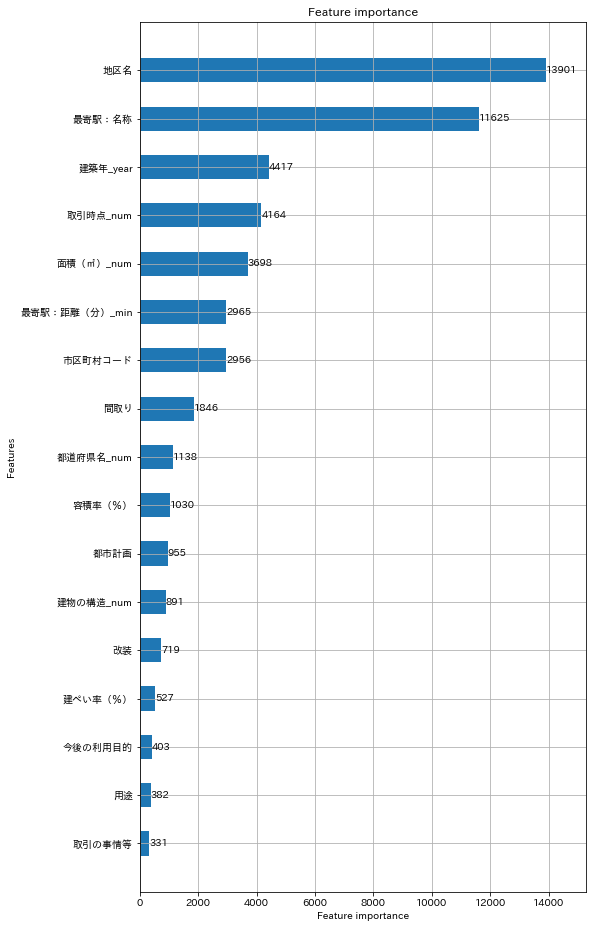

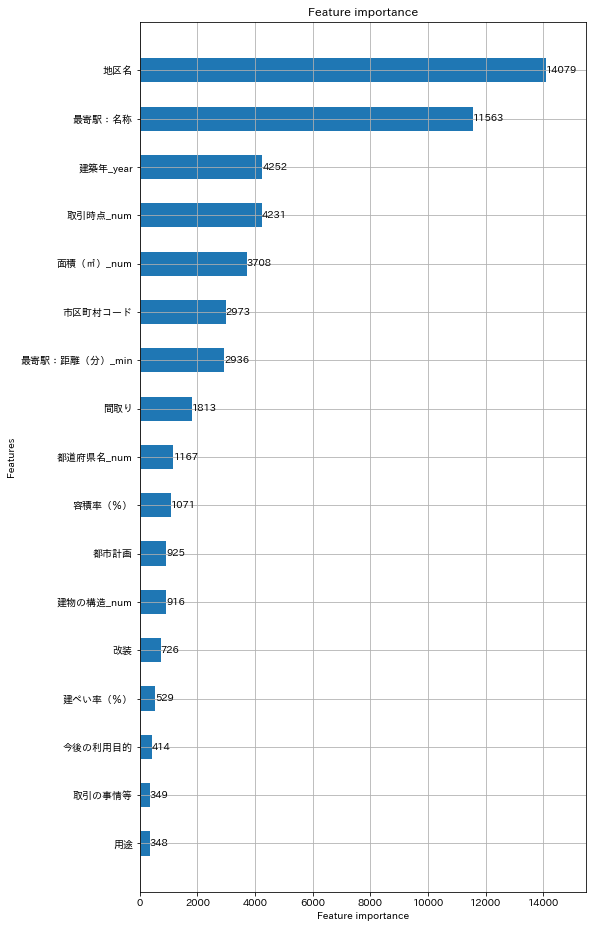

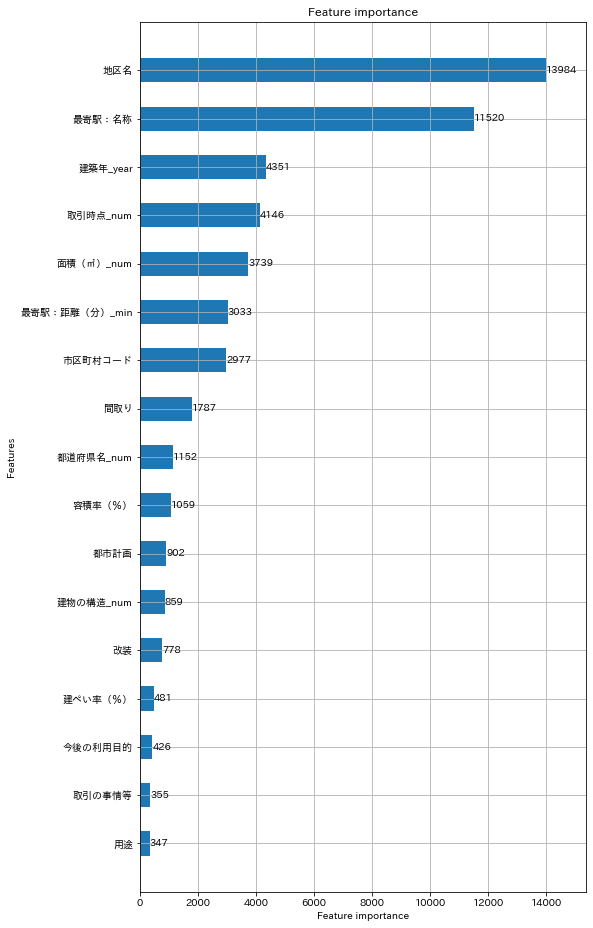

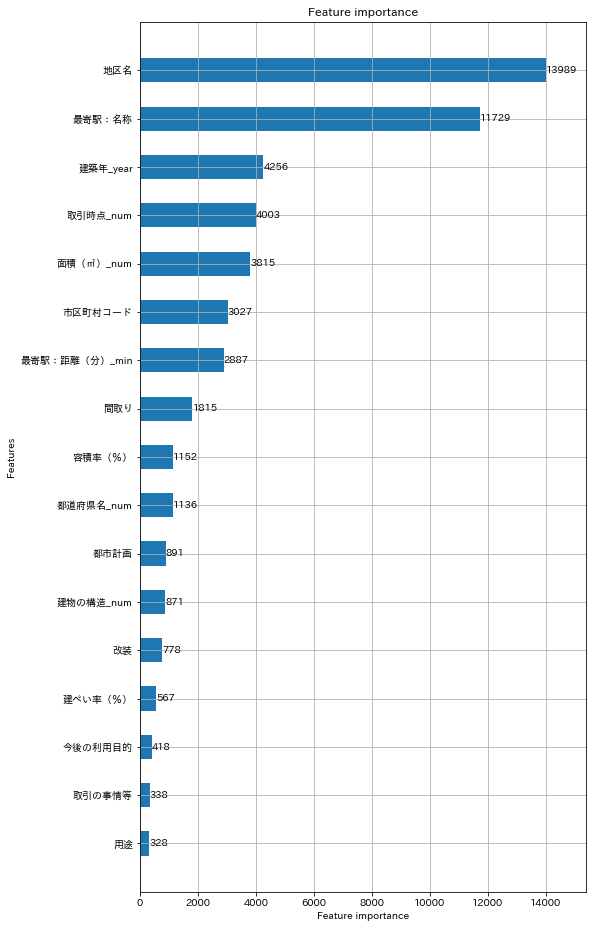

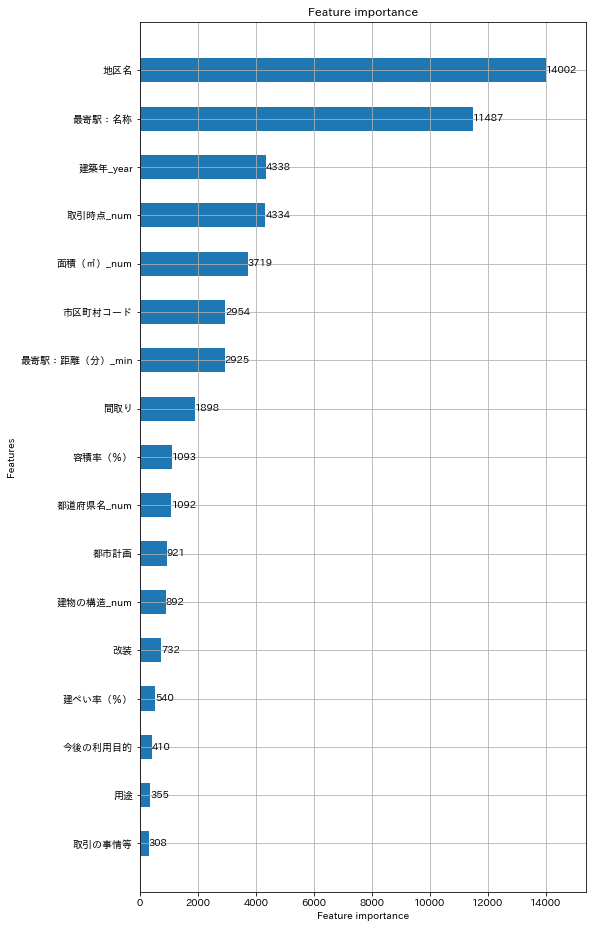

In [7]:
for model in models:
    pd.DataFrame(model.feature_importance(), index=val_x.columns, columns=["importance"]).sort_values("importance", ascending=False)
    lgb.plot_importance(model, height = 0.5, figsize = (8,16))
    lgb.create_tree_digraph(model, 1)

In [6]:
#要素の重要度を確認
pd.DataFrame(model.feature_importance(), index=val_x.columns, columns=["importance"]).sort_values("importance", ascending=False)

,importance
地区名,8621
最寄駅：名称,6414
建築年_year,3339
取引時点_num,3196
面積（㎡）_num,2025
最寄駅：距離（分）_min,1757
間取り,918
市区町村コード,827
都道府県名_num,653
改装,489


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

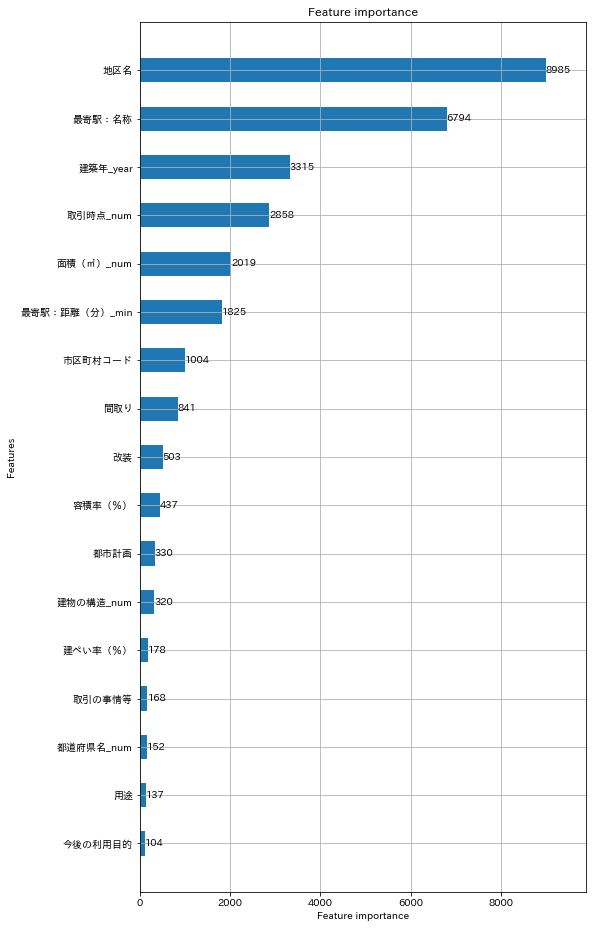

In [8]:
#要素の重要度を可視化
lgb.plot_importance(model, height = 0.5, figsize = (8,16))

In [ ]:
#要素の重要度を樹形図で表示
lgb.create_tree_digraph(model, 1)

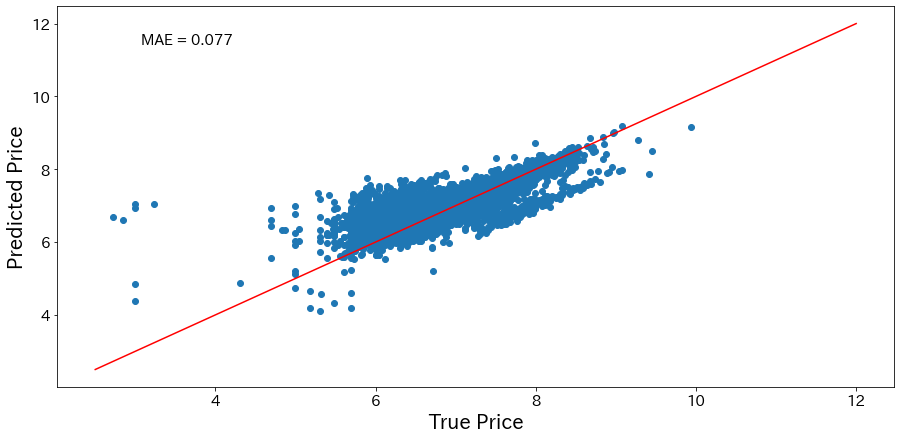

In [64]:
#予測精度の確認（視覚化）
def Prediction_accuracy(val_y, va_pred):
    predicted_df = pd.DataFrame(index=[], columns=["pred", "true"])
    predicted_df["true"] = val_y.values   #val_yがSeries型のため、np配列ndarrayに変換処理をしてから入れる
    predicted_df["pred"] = va_pred
    score_mae = mae(test_data1["pred"], test_data1["true"])
    
    plt.figure(figsize = (15,7))
    ax = plt.subplot(1, 1, 1)
    ax.scatter('true', 'pred', data = predicted_df)
    ax.set_xlabel('True Price', fontsize = 20)
    ax.set_ylabel('Predicted Price', fontsize = 20)
    plt.tick_params(labelsize = 15)
    x = np.linspace(2.5, 12)
    y = x
    ax.plot(x, y, 'r-')
    plt.text(0.1, 0.9, 'MAE = {}'.format(str(round(score_mae,3))),transform = ax.transAxes, fontsize = 15)
    
Prediction_accuracy(val_y, va_pred)